# Trabajo Practico 2 - Regresion Logistica



---

Autores:
* de Brito, Nicolas
* Giacone, Agustin

## Librerias

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import logging

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
import geopandas as gpd

import plotly.express as px
#import plotly.graph_objects as go
#import plotly.figure_factory as ff

from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ML metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, auc


from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)


from folium import GeoJson
from folium.features import GeoJsonTooltip

#MODELO BASE
from sklearn.dummy import DummyClassifier

#Optimizas Hiperparametros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#!pip install --quiet optuna
import optuna


#SHAP
import shap
from scipy.special import expit

#AutoML
#!pip install pycaret
#from pycaret.regression import setup, compare_models, predict_model, save_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.7 MB/s eta 0:00:00


## Carga de dataset

In [ ]:
### Descargar datos de una carpeta de drive - Ejecutar si se corre el archivo en Colab
#! gdown 1TQfIb5GEqbnieaRUu3_60sjiQwV-ZedO
#https://drive.google.com/file/d/1TQfIb5GEqbnieaRUu3_60sjiQwV-ZedO/view?usp=drive_link
#http://www.bom.gov.au/


Downloading...
From: https://drive.google.com/uc?id=1TQfIb5GEqbnieaRUu3_60sjiQwV-ZedO
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 99.6MB/s]


In [4]:
file_path= 'weatherAUS.csv'

df = pd.read_csv(file_path)
#df.shape

## Limpieza inicial de dataset

### Eliminacion por variable target

In [5]:
#Revisamos los valores posibles de mi variable target
print('Antes de limpiar')
print(df['RainTomorrow'].value_counts(dropna=False)) #['No', 'Yes', nan]

#Eliminamos registros con valores imposibles (NaN)
df.dropna(subset=['RainTomorrow'], inplace=True)

print('\nDespues de limpiar')
print(df['RainTomorrow'].value_counts(dropna=False)) #['No', 'Yes', nan]

Antes de limpiar
RainTomorrow
No     110316
Yes     31877
NaN      3267
Name: count, dtype: int64

Despues de limpiar
RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64


### Eliminacion por cantidad de columnas NaN por registro

In [6]:
cant_reg = df.shape[0]
nulos_por_fila = df.isnull().sum(axis=1)

# Agrupar por cantidad de columnas nulas y contar cuántas filas cumplen esa condición
df_filas_con_nulos = nulos_por_fila.value_counts().sort_index().reset_index()
df_filas_con_nulos.columns = ['cantidad_columnas_nulas', 'cantidad_registros']
df_filas_con_nulos['porcentaje_filas_nulas'] = (df_filas_con_nulos['cantidad_registros'] / cant_reg) * 100

print("Total de registros del dataset: ", df.shape[0])
print("Cantidad de columnas del dataset: ", df.shape[1])

df_filas_con_nulos.sort_values(by='cantidad_columnas_nulas', ascending = False)

Total de registros del dataset:  142193
Cantidad de columnas del dataset:  23


,cantidad_columnas_nulas,cantidad_registros,porcentaje_filas_nulas
20,20,5,0.003516
19,19,16,0.011252
18,18,49,0.034460
17,17,91,0.063998
16,16,27,0.018988
15,15,26,0.018285
14,14,39,0.027428
13,13,106,0.074547
12,12,757,0.532375
11,11,679,0.477520


In [7]:
#Eliminamos los registros que tengan X cantidad de columnas en nan

#Eliminamos registros con mas de 7 columnas en null --> Representa un 2.42% del dataset
cant_col_nan = 7

cant_eliminados = df[df.isnull().sum(axis=1) > cant_col_nan].shape[0]

df = df[df.isnull().sum(axis=1) <= cant_col_nan].reset_index(drop=True)

print('Se eliminaron',str(cant_eliminados),'registros.')

Se eliminaron 3443 registros.


### Eliminacion por cantidad de registros NaN por columna

In [8]:
cant_reg = df.shape[0]
df_columnas_nulls = df.isnull().sum().reset_index()
df_columnas_nulls.columns = ['columna', 'cant_nan']
df_columnas_nulls['porcentaje_nan'] = (df_columnas_nulls['cant_nan'] / cant_reg) * 100


print("Total de registros del dataset: ", df.shape[0])
df_columnas_nulls.sort_values(by='cant_nan', ascending=False)

Total de registros del dataset:  138750


,columna,cant_nan,porcentaje_nan
6,Sunshine,64445,46.446847
5,Evaporation,57910,41.736937
18,Cloud3pm,54085,38.980180
17,Cloud9am,51774,37.314595
15,Pressure9am,11439,8.244324
16,Pressure3pm,11398,8.214775
9,WindDir9am,8132,5.860901
7,WindGustDir,6661,4.800721
8,WindGustSpeed,6632,4.779820
14,Humidity3pm,1748,1.259820


In [9]:
#Se eliminan las columnas porque tienen un porcentaje alto de nulls

col_a_eliminar = ['Sunshine','Evaporation','Cloud3pm','Cloud9am']
df = df.drop(col_a_eliminar, axis=1)

## Limpieza de variables - Pre division del dataset

### Variable target

In [10]:
print('Antes del cambio a 1 y 0')
print(df['RainTomorrow'].value_counts(dropna=False))

#Cambiamos valores y tipo de datos (el map lo hace automaticamente)
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

print('\nDespues del cambio a 1 y 0')
print(df['RainTomorrow'].value_counts(dropna=False))

Antes del cambio a 1 y 0
RainTomorrow
No     107837
Yes     30913
Name: count, dtype: int64

Despues del cambio a 1 y 0
RainTomorrow
0    107837
1     30913
Name: count, dtype: int64


### RainToday

In [11]:
print('Antes del cambio a 1 y 0')
print(df['RainToday'].value_counts(dropna=False))

#Cambiamos valores y tipo de datos (el map lo hace automaticamente)
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

print('\nDespues del cambio a 1 y 0')
print(df['RainToday'].value_counts(dropna=False))

Antes del cambio a 1 y 0
RainToday
No     107122
Yes     30642
NaN       986
Name: count, dtype: int64

Despues del cambio a 1 y 0
RainToday
0.0    107122
1.0     30642
NaN       986
Name: count, dtype: int64


In [12]:
df.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,138584.000000,138645.000000,137764.000000,132118.000000,138557.000000,138359.000000,137868.000000,137002.000000,127311.000000,127352.00000,138615.000000,137781.000000,137764.000000,138750.000000
mean,12.211136,23.278691,2.328586,39.967658,14.058452,18.687451,68.740469,51.394111,1017.652732,1015.25451,17.000528,21.717401,0.222424,0.222796
std,6.400037,7.095753,8.394855,13.561503,8.838186,8.769035,19.074866,20.765575,7.104306,7.03623,6.501845,6.924095,0.415876,0.416124
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.10000,-7.200000,-5.400000,0.000000,0.000000
25%,7.600000,18.000000,0.000000,31.000000,7.000000,13.000000,57.000000,36.000000,1012.900000,1010.40000,12.300000,16.600000,0.000000,0.000000
50%,12.000000,22.700000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.20000,16.700000,21.100000,0.000000,0.000000
75%,16.900000,28.300000,0.600000,48.000000,19.000000,24.000000,83.000000,65.000000,1022.400000,1020.00000,21.600000,26.500000,0.000000,0.000000
max,33.900000,48.100000,371.000000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.60000,40.200000,46.700000,1.000000,1.000000


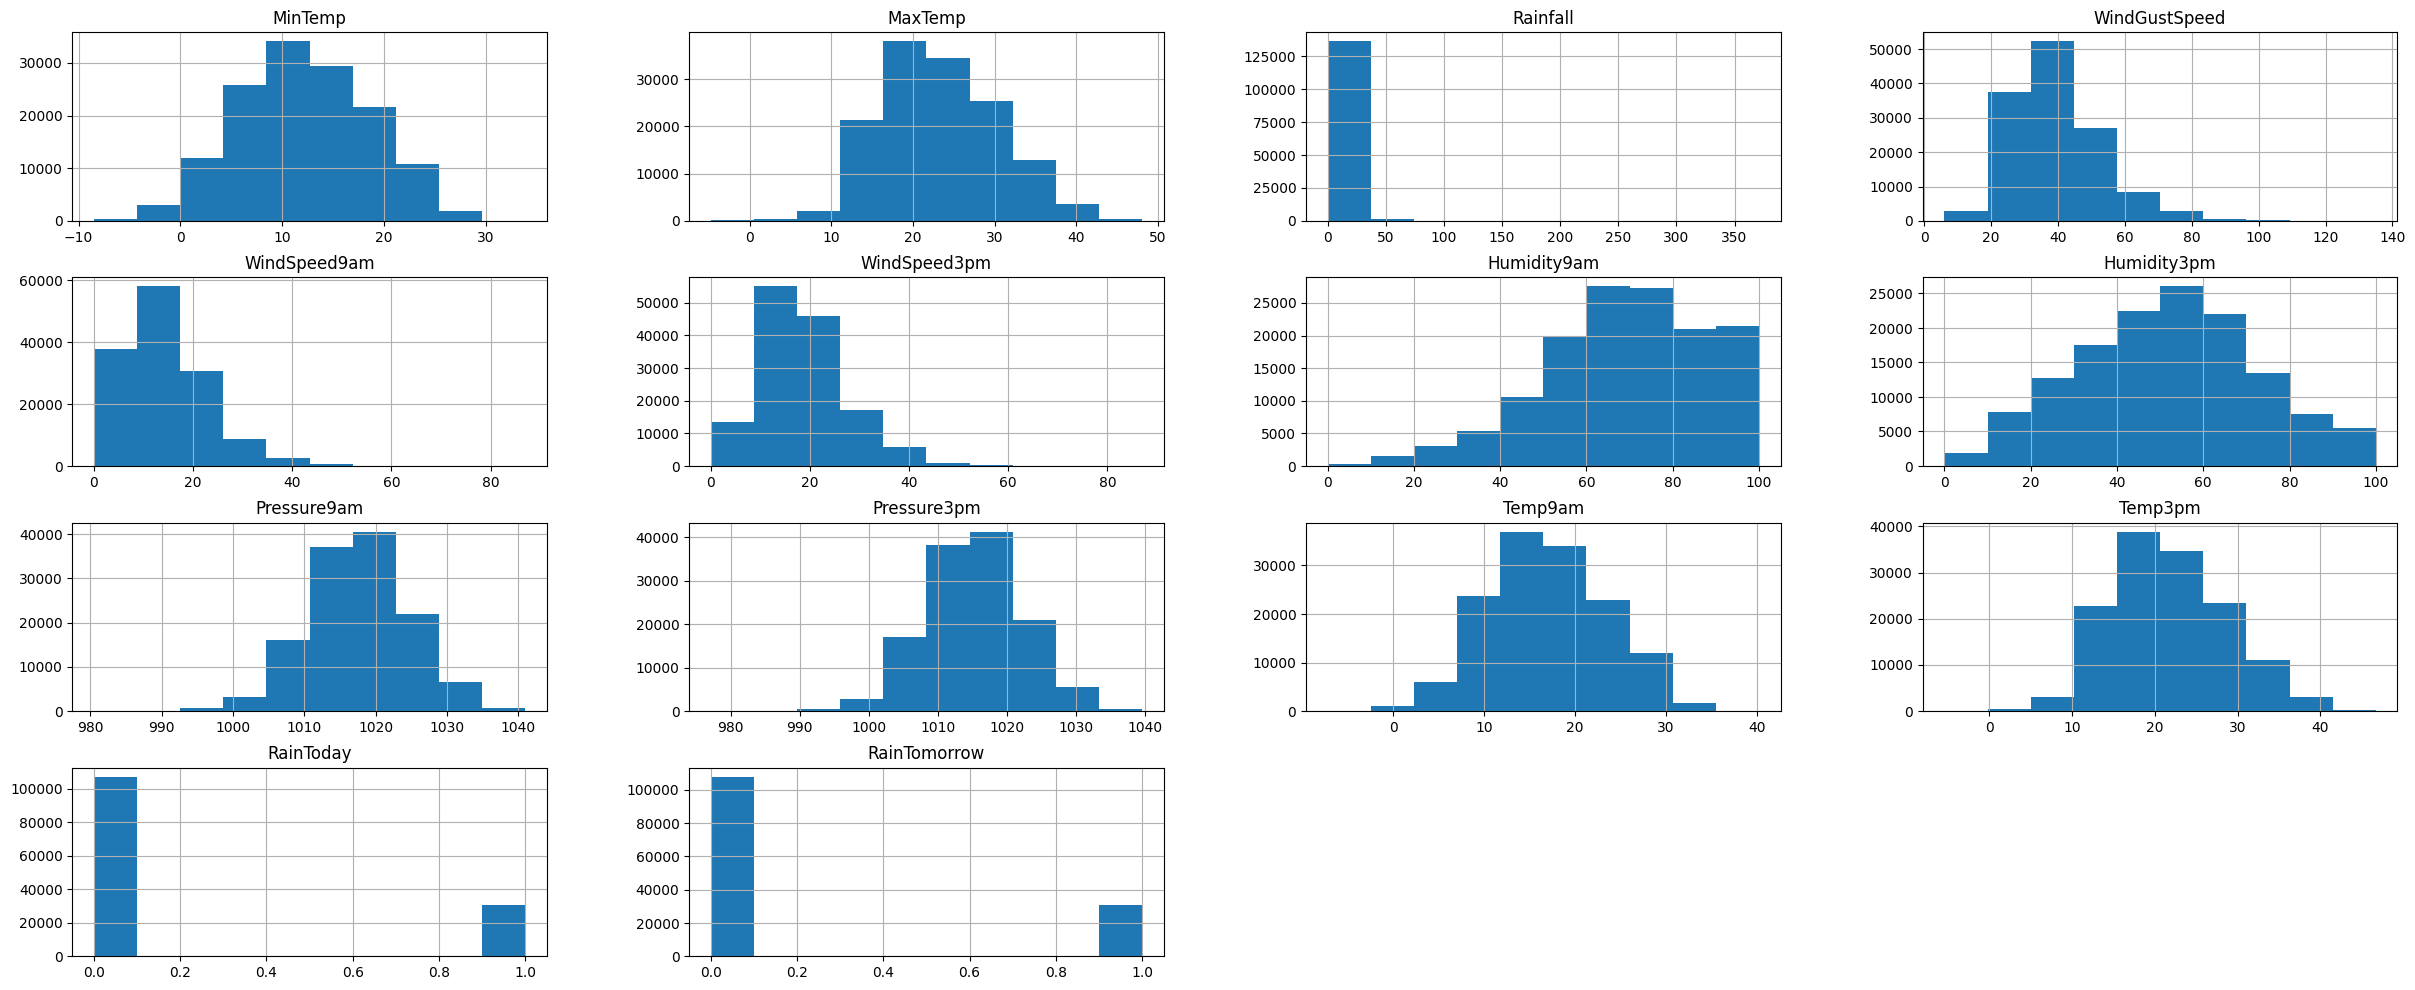

In [13]:
df.hist(figsize=(30,12))
plt.show()

### Fecha

In [14]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date
df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month
df['Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year

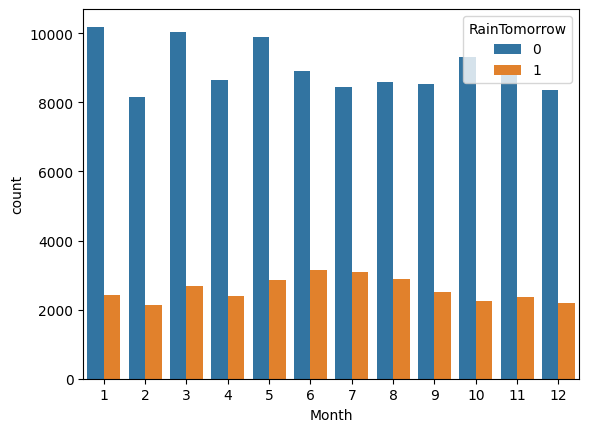

In [15]:
sns.countplot(data=df, x='Month', hue='RainTomorrow')
plt.show()

In [16]:
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12).round(5)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12).round(5)

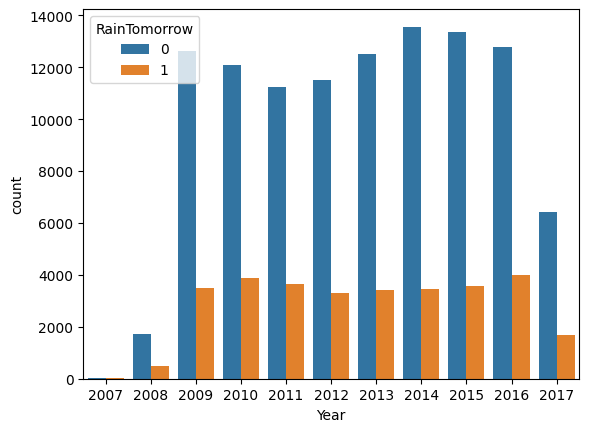

In [17]:
sns.countplot(data=df, x='Year', hue='RainTomorrow')
plt.show()

### Ciudades y zona climatica

#### Coordenadas de ciudades

In [18]:
#Generamos conexion
geolocator = Nominatim(user_agent="mi_app_geopy")

# Ignorar los warnings
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("geopy").setLevel(logging.ERROR)

#Generamos consulta
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

#Obtenemos valor unicos de las ciudades y los guardamos en un DF
df_ciudades = pd.DataFrame(df['Location'].unique(), columns=['Location'])

# Divido en dos partes el nombre de las ciudades compuestas por dos palabras
# pero que en el df aparecen sin espacio entre ellas
df_ciudades['Location_clean'] = df_ciudades['Location'].str.replace(r'(?<!^)([A-Z].*)', r' \1', regex=True)

# Buscar coordenadas
df_ciudades['ubicacion']  = df_ciudades['Location_clean'].apply(lambda x: geocode(f"{x}, Australia"))
df_ciudades['latitud']    = df_ciudades['ubicacion'].apply(lambda loc: loc.latitude if loc else None)
df_ciudades['longitud']   = df_ciudades['ubicacion'].apply(lambda loc: loc.longitude if loc else None)

#Chequeamos df de ciudades
#df_ciudades

#### Graficos de ciudades

In [19]:
#Graficamos los puntos para observan donde se concentran las ciudades del dataset
fig = px.scatter_mapbox(  df_ciudades
                          ,lat="latitud"
                          ,lon="longitud"
                          ,zoom=2.75
                          ,mapbox_style='open-street-map'
                          ,hover_name="Location_clean"
                          ,hover_data={
                                        "latitud": False,
                                        "longitud": False })
fig.update_layout(mapbox_center={"lat": -23.69839, "lon": 133.8813}, margin=dict(l=2, r=2, t=2, b=2), width=700, height=550)
fig.show()

#### Zonas climaticas de Australia

In [ ]:
### Descarga archivo de carpeta de Drive - Ejecutar si se corre el codigo en Colab
#! gdown 1o6zom89OFYHCBDP_QuylcSRSuhuVNGOs
#https://drive.google.com/file/d/1o6zom89OFYHCBDP_QuylcSRSuhuVNGOs/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1o6zom89OFYHCBDP_QuylcSRSuhuVNGOs
From (redirected): https://drive.google.com/uc?id=1o6zom89OFYHCBDP_QuylcSRSuhuVNGOs&confirm=t&uuid=58e5f080-4128-42c6-ac50-ab8d30ff273a
To: /content/abcb-climate-zone-map.zip
100% 33.8M/33.8M [00:00<00:00, 94.3MB/s]


In [21]:
#Leemos .zip del mapa de climas de Australia
gdf = gpd.read_file("zip:abcb-climate-zone-map.zip")

In [22]:
print(gdf.columns)
gdf.shape

Index(['clim_zone', 'geometry'], dtype='object')


(8, 2)

In [23]:
#Asociamos ciudades a las zonas climaticas

gdf_zonas = gdf

geometry = [Point(lon, lat) for lon, lat in zip(df_ciudades['longitud'], df_ciudades['latitud'])]

gdf_ciudades = gpd.GeoDataFrame(df_ciudades, geometry=geometry)

Grafico de las zonas geograficas junto a las ciudades

In [ ]:
#import folium
#import geopandas as gpd
#from folium import GeoJson
#from folium.features import GeoJsonTooltip

#gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Crear el mapa base centrado en Australia
m = folium.Map(location=[-25, 135], zoom_start=4, tiles='CartoDB positron')

# Asegurarse que las zonas climáticas están en lat/lon (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)
#print(gdf)
# Definir una lista de colores contrastantes para las zonas climáticas
color_palette = [
    "#FFB3B3",  # Rojo pastel
    "#FFCC99",  # Naranja pastel
    "#FFFF99",  # Amarillo pastel
    "#B3FFB3",  # Verde pastel
    "#99CCFF",  # Azul pastel
    "#C2A2D4",  # Índigo pastel
    "#E6A9D7",  # Violeta pastel
    "#B3FFFF"   # Cian pastel
]

# Agregar zonas climáticas al mapa
for i, (_, row) in enumerate(gdf.iterrows()):
    # Aseguramos que el objeto tiene las propiedades necesarias
    geojson = {
        "type": "Feature",
        "geometry": row['geometry'].__geo_interface__,
        "properties": {"clim_zone": row['clim_zone']}  # Aquí añadimos la propiedad clim_zone
    }

    # Seleccionar el color de la zona de acuerdo a su número (0-7)
    zone_color = color_palette[i]

    # Agregar cada zona climática al mapa
    folium.GeoJson(
        geojson,
        style_function=lambda feature, color=zone_color: {
            'fillColor': color,  # Usamos el color personalizado
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        tooltip=GeoJsonTooltip(fields=['clim_zone'], aliases=['Zona Climática'], labels=True)
    ).add_to(m)

# Agregar ciudades al mapa
for _, row in gdf_ciudades.iterrows():
    folium.Marker(
        location=[row['latitud'], row['longitud']],
        popup=row['Location_clean'],
        icon=folium.Icon(color='red')#, icon='info-sign'
    ).add_to(m)

# Mostrar el mapa
m


#### Asignacion de zona a cada localidad

In [25]:



gdf_zonas = gdf_zonas.to_crs(epsg=4326)  # Asegúrate que esté en el mismo CRS (WGS84)
gdf_ciudades = gdf_ciudades.set_crs(epsg=4326)  # También, las ciudades deben estar en el mismo CRS


gdf_ciudades_con_zona = gpd.sjoin(gdf_ciudades, gdf_zonas, how="left", predicate="within")


#Elimino duplicado ya que Albury pertenece a dos zonas
gdf_ciudades_con_zona = gdf_ciudades_con_zona[~((gdf_ciudades_con_zona['Location'] == 'Albury') & (gdf_ciudades_con_zona['clim_zone'] == '7'))]


In [26]:
gdf_ciudades_con_zona[gdf_ciudades_con_zona['clim_zone'].isna()]

,Location,Location_clean,ubicacion,latitud,longitud,geometry,index_right,clim_zone
5,Newcastle,Newcastle,"(Newcastle, Newcastle-Maitland, City of Newcas...",-32.919295,151.779535,POINT (151.77953 -32.9193),NaN,NaN
7,NorfolkIsland,Norfolk Island,"(Norfolk Island, Australia, (-29.0328038, 167....",-29.032804,167.948314,POINT (167.94831 -29.0328),NaN,NaN


In [27]:
#Dos ciudades no se pudieron asignar correctamente a las zonas
#Se corrige asignacion.
gdf_ciudades_con_zona.loc[gdf_ciudades_con_zona['Location'] == 'NorfolkIsland', 'clim_zone'] = 2
gdf_ciudades_con_zona.loc[gdf_ciudades_con_zona['Location'] == 'Newcastle', 'clim_zone'] = 5

In [28]:
#Agrego columna de zona a mi df
df['clim_zone'] = df['Location'].map(gdf_ciudades_con_zona.set_index('Location')['clim_zone'])
df['clim_zone'] = df['clim_zone'].astype(int)
df['clim_zone_dummies'] = df['clim_zone']

In [29]:
#Creo variables dummies en el dataset
df = pd.get_dummies(df, columns=['clim_zone_dummies'], prefix='zona', drop_first=True)

## Division del dataset

In [30]:
#Dividimos dataset en conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='RainTomorrow'), df['RainTomorrow'], test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

## Limpieza de variables - Post division del dataset

### Direcciones de vientos

In [31]:
#Para imputar vientos
columnas_moda = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

#### WindGustDir

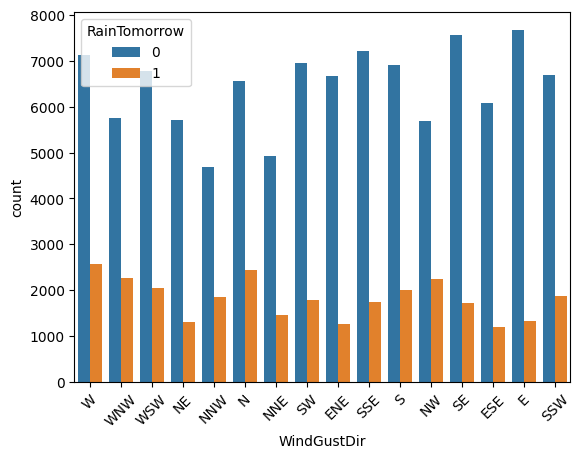


Cantidad de NaN en WindGustDir en el dataset X_train:  5362


WindGustDir,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
RainTomorrow,,,,,,,,,,,,,,,,
0,0.074515,0.064694,0.058973,0.063752,0.055544,0.047802,0.045461,0.055311,0.067016,0.073398,0.070105,0.064966,0.067599,0.069230,0.055874,0.065763
1,0.045809,0.043510,0.040867,0.083588,0.044711,0.050441,0.063617,0.077000,0.068696,0.059191,0.059877,0.064647,0.061490,0.088495,0.077480,0.070583


In [32]:
sns.countplot(data=df, x = 'WindGustDir', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en WindGustDir en el dataset X_train: ', X_train[X_train['WindGustDir'].isna()].shape[0])

proporciones = df.groupby('RainTomorrow')['WindGustDir'].value_counts(normalize=True).rename('proporcion').reset_index()
tabla_pivot = proporciones.pivot(index='RainTomorrow', columns='WindGustDir', values='proporcion')
tabla_pivot

In [33]:
print('Se imputan datos NaN de WindGustDir... \n')
modas_WindGustDir_train = X_train.groupby(['Location', 'Year', 'Month'])['WindGustDir'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
X_train = X_train.merge(modas_WindGustDir_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['WindGustDir'] = X_train['WindGustDir'].fillna(X_train['WindGustDir_moda'])

print('Cantidad de NaN en el dataset de modas de WindGustDir: ', modas_WindGustDir_train[modas_WindGustDir_train['WindGustDir'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindGustDir'].isna()].shape[0])

Se imputan datos NaN de WindGustDir... 

Cantidad de NaN en el dataset de modas de WindGustDir:  198
Cantidad de NaN en el dataset X_train:  4262


In [34]:
print('Se imputan datos NaN de WindGustDir... \n')
modas_WindGustDir_train['WindGustDir'] = modas_WindGustDir_train['WindGustDir'].fillna(X_train.groupby(['Location', 'Month'])['WindGustDir'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))
X_train=X_train.drop(columns = 'WindGustDir_moda')
X_train = X_train.merge(modas_WindGustDir_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['WindGustDir'] = X_train['WindGustDir'].fillna(X_train['WindGustDir_moda'])

print('Cantidad de NaN en el dataset de modas de WindGustDir: ', modas_WindGustDir_train[modas_WindGustDir_train['WindGustDir'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindGustDir'].isna()].shape[0])

Se imputan datos NaN de WindGustDir... 

Cantidad de NaN en el dataset de modas de WindGustDir:  8
Cantidad de NaN en el dataset X_train:  146


In [35]:
print('Se imputan datos NaN de WindGustDir... \n')
modas_WindGustDir_train['WindGustDir'] = modas_WindGustDir_train['WindGustDir'].fillna(X_train.groupby(['Location'])['WindGustDir'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))
X_train=X_train.drop(columns = 'WindGustDir_moda')
X_train = X_train.merge(modas_WindGustDir_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['WindGustDir'] = X_train['WindGustDir'].fillna(X_train['WindGustDir_moda'])

print('Cantidad de NaN en el dataset de modas de WindGustDir: ', modas_WindGustDir_train[modas_WindGustDir_train['WindGustDir'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindGustDir'].isna()].shape[0])

Se imputan datos NaN de WindGustDir... 

Cantidad de NaN en el dataset de modas de WindGustDir:  0
Cantidad de NaN en el dataset X_train:  0


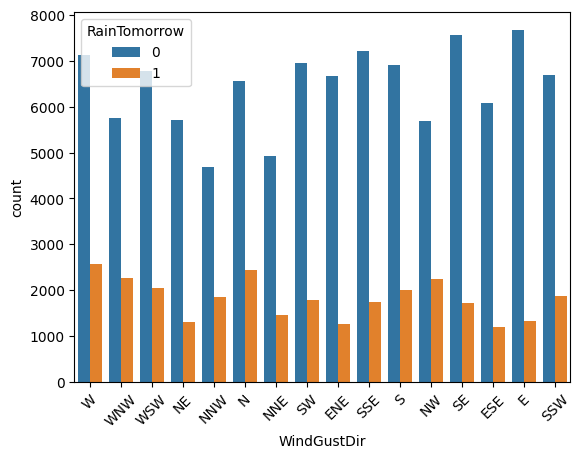


Cantidad de NaN en WindGustDir en el dataset X_train:  0


WindGustDir,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
RainTomorrow,,,,,,,,,,,,,,,,
0,0.074515,0.064694,0.058973,0.063752,0.055544,0.047802,0.045461,0.055311,0.067016,0.073398,0.070105,0.064966,0.067599,0.069230,0.055874,0.065763
1,0.045809,0.043510,0.040867,0.083588,0.044711,0.050441,0.063617,0.077000,0.068696,0.059191,0.059877,0.064647,0.061490,0.088495,0.077480,0.070583


In [36]:
sns.countplot(data=df, x = 'WindGustDir', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en WindGustDir en el dataset X_train: ', X_train[X_train['WindGustDir'].isna()].shape[0])

proporciones = df.groupby('RainTomorrow')['WindGustDir'].value_counts(normalize=True).rename('proporcion').reset_index()
tabla_pivot = proporciones.pivot(index='RainTomorrow', columns='WindGustDir', values='proporcion')
tabla_pivot

#### WindDir9am

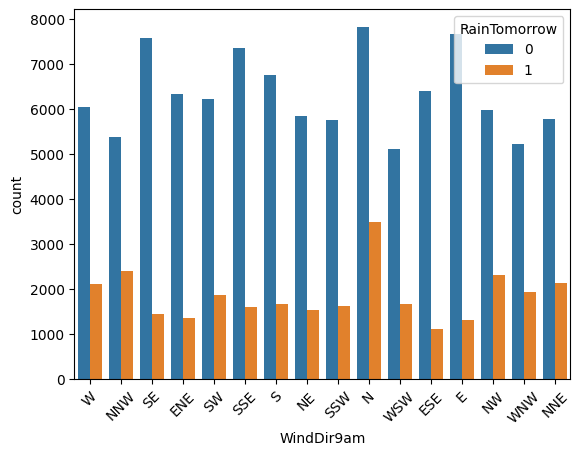


Cantidad de NaN en WindDir9am en el dataset X_train:  6550


WindDir9am,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
RainTomorrow,,,,,,,,,,,,,,,,
0,0.075705,0.062573,0.063295,0.077237,0.057817,0.057124,0.053140,0.059013,0.066805,0.074854,0.072540,0.056788,0.061505,0.059646,0.051518,0.050440
1,0.044187,0.045646,0.037439,0.118082,0.052123,0.072029,0.081491,0.078167,0.056260,0.048901,0.053988,0.055005,0.063450,0.071690,0.065145,0.056396


In [37]:
sns.countplot(data=df, x = 'WindDir9am', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en WindDir9am en el dataset X_train: ', X_train[X_train['WindDir9am'].isna()].shape[0])

proporciones = df.groupby('RainTomorrow')['WindDir9am'].value_counts(normalize=True).rename('proporcion').reset_index()
tabla_pivot = proporciones.pivot(index='RainTomorrow', columns='WindDir9am', values='proporcion')
tabla_pivot

In [38]:
print('Se imputan datos NaN de WindDir9am... \n')
modas_WindDir9am_train = X_train.groupby(['Location', 'Year', 'Month'])['WindDir9am'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
X_train = X_train.merge(modas_WindDir9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['WindDir9am'] = X_train['WindDir9am'].fillna(X_train['WindDir9am_moda'])

print('Cantidad de NaN en el dataset de modas de WindDir9am: ', modas_WindDir9am_train[modas_WindDir9am_train['WindDir9am'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindDir9am'].isna()].shape[0])

Se imputan datos NaN de WindDir9am... 

Cantidad de NaN en el dataset de modas de WindDir9am:  0
Cantidad de NaN en el dataset X_train:  0


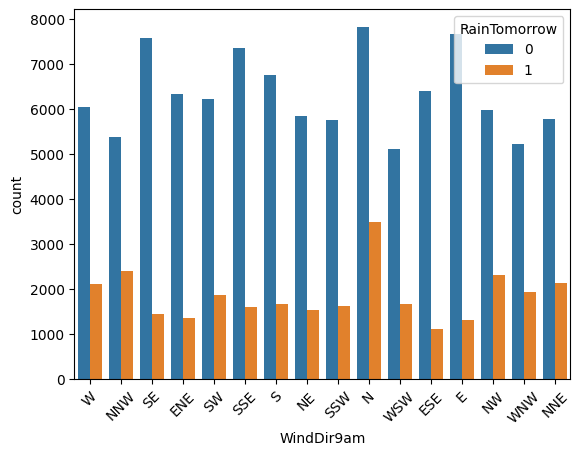


Cantidad de NaN en WindDir9am en el dataset X_train:  0


WindDir9am,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
RainTomorrow,,,,,,,,,,,,,,,,
0,0.075705,0.062573,0.063295,0.077237,0.057817,0.057124,0.053140,0.059013,0.066805,0.074854,0.072540,0.056788,0.061505,0.059646,0.051518,0.050440
1,0.044187,0.045646,0.037439,0.118082,0.052123,0.072029,0.081491,0.078167,0.056260,0.048901,0.053988,0.055005,0.063450,0.071690,0.065145,0.056396


In [39]:
sns.countplot(data=df, x = 'WindDir9am', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en WindDir9am en el dataset X_train: ', X_train[X_train['WindDir9am'].isna()].shape[0])

proporciones = df.groupby('RainTomorrow')['WindDir9am'].value_counts(normalize=True).rename('proporcion').reset_index()
tabla_pivot = proporciones.pivot(index='RainTomorrow', columns='WindDir9am', values='proporcion')
tabla_pivot

#### WindDir3pm

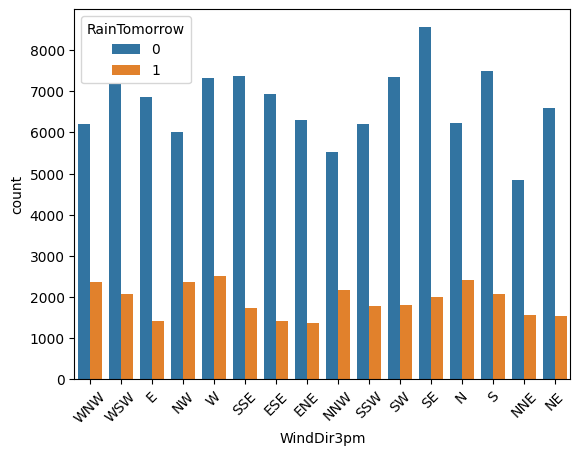


Cantidad de NaN en WindDir3pm en el dataset X_train:  971


WindDir3pm,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
RainTomorrow,,,,,,,,,,,,,,,,
0,0.064234,0.058839,0.064776,0.058138,0.061579,0.045228,0.051697,0.056269,0.070067,0.080061,0.068852,0.058026,0.068646,0.068422,0.057961,0.067206
1,0.046352,0.044682,0.046254,0.078791,0.050149,0.051164,0.071001,0.077548,0.067498,0.065730,0.056958,0.058300,0.058594,0.081705,0.077548,0.067727


In [40]:
sns.countplot(data=df, x = 'WindDir3pm', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en WindDir3pm en el dataset X_train: ', X_train[X_train['WindDir3pm'].isna()].shape[0])

proporciones = df.groupby('RainTomorrow')['WindDir3pm'].value_counts(normalize=True).rename('proporcion').reset_index()
tabla_pivot = proporciones.pivot(index='RainTomorrow', columns='WindDir3pm', values='proporcion')
tabla_pivot

In [41]:
print('Se imputan datos NaN de WindDir3pm... \n')
modas_WindDir3pm_train = X_train.groupby(['Location', 'Year', 'Month'])['WindDir3pm'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
X_train = X_train.merge(modas_WindDir3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['WindDir3pm'] = X_train['WindDir3pm'].fillna(X_train['WindDir3pm_moda'])

print('Cantidad de NaN en el dataset de modas de WindDir3pm: ', modas_WindDir3pm_train[modas_WindDir3pm_train['WindDir3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindDir3pm'].isna()].shape[0])

Se imputan datos NaN de WindDir3pm... 

Cantidad de NaN en el dataset de modas de WindDir3pm:  9
Cantidad de NaN en el dataset X_train:  170


In [42]:
print('Se imputan datos NaN de WindDir3pm... \n')
modas_WindDir3pm_train['WindDir3pm'] = modas_WindDir3pm_train['WindDir3pm'].fillna(X_train.groupby(['Location', 'Month'])['WindDir3pm'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))
X_train=X_train.drop(columns = 'WindDir3pm_moda')
X_train = X_train.merge(modas_WindDir3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['WindDir3pm'] = X_train['WindDir3pm'].fillna(X_train['WindDir3pm_moda'])

print('Cantidad de NaN en el dataset de modas de WindDir3pm: ', modas_WindDir3pm_train[modas_WindDir3pm_train['WindDir3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindDir3pm'].isna()].shape[0])

Se imputan datos NaN de WindDir3pm... 

Cantidad de NaN en el dataset de modas de WindDir3pm:  0
Cantidad de NaN en el dataset X_train:  0


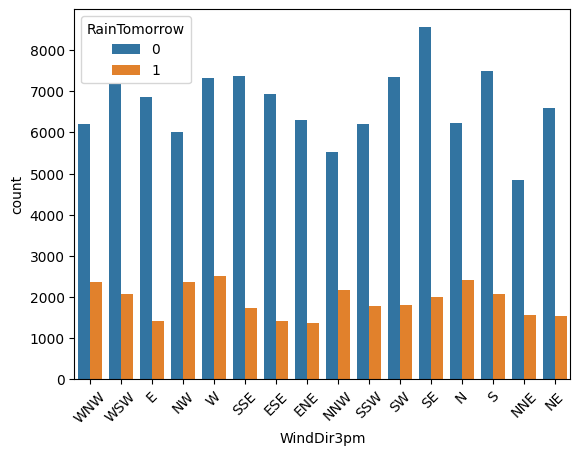


Cantidad de NaN en WindDir3pm en el dataset X_train:  0


WindDir3pm,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
RainTomorrow,,,,,,,,,,,,,,,,
0,0.064234,0.058839,0.064776,0.058138,0.061579,0.045228,0.051697,0.056269,0.070067,0.080061,0.068852,0.058026,0.068646,0.068422,0.057961,0.067206
1,0.046352,0.044682,0.046254,0.078791,0.050149,0.051164,0.071001,0.077548,0.067498,0.065730,0.056958,0.058300,0.058594,0.081705,0.077548,0.067727


In [43]:
sns.countplot(data=df, x = 'WindDir3pm', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en WindDir3pm en el dataset X_train: ', X_train[X_train['WindDir3pm'].isna()].shape[0])

proporciones = df.groupby('RainTomorrow')['WindDir3pm'].value_counts(normalize=True).rename('proporcion').reset_index()
tabla_pivot = proporciones.pivot(index='RainTomorrow', columns='WindDir3pm', values='proporcion')
tabla_pivot

#### Tranformacion de variables de direccion vientos

In [44]:
#Seteo grados a cada direccion
puntos_cardinales = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

X_train['WindGustDir_grad'] = X_train['WindGustDir'].map(puntos_cardinales)
X_train['WindDir9am_grad'] = X_train['WindDir9am'].map(puntos_cardinales)
X_train['WindDir3pm_grad'] = X_train['WindDir3pm'].map(puntos_cardinales)

# Convertimos los grados a radianes
X_train['WindGustDir_rad'] = np.deg2rad(X_train['WindGustDir_grad'])
X_train['WindDir9am_rad'] = np.deg2rad(X_train['WindDir9am_grad'])
X_train['WindDir3pm_rad'] = np.deg2rad(X_train['WindDir3pm_grad'])

# Creamos las variables cíclicas
X_train['WindGustDir_sin'] = np.sin(X_train['WindGustDir_rad']).round(5)
X_train['WindGustDir_cos'] = np.cos(X_train['WindGustDir_rad']).round(5)

X_train['WindDir9am_sin'] = np.sin(X_train['WindDir9am_rad']).round(5)
X_train['WindDir9am_cos'] = np.cos(X_train['WindDir9am_rad']).round(5)

X_train['WindDir3pm_sin'] = np.sin(X_train['WindDir3pm_rad']).round(5)
X_train['WindDir3pm_cos'] = np.cos(X_train['WindDir3pm_rad']).round(5)


#Creo variables dummies en el dataset
#X_train = pd.get_dummies(X_train, columns=['WindGustDir'], prefix='WindGustDir', drop_first=True, dtype=int)
#X_train = pd.get_dummies(X_train, columns=['WindDir9am'], prefix='WindDir9am', drop_first=True, dtype=int)
#X_train = pd.get_dummies(X_train, columns=['WindDir3pm'], prefix='WindDir3pm', drop_first=True, dtype=int)

#vientos = ['WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos']
#X_train[vientos]

### Temperaturas

In [45]:
var_temperaturas = ['MinTemp','MaxTemp','Temp9am','Temp3pm']
X_train[var_temperaturas].head(1)

,MinTemp,MaxTemp,Temp9am,Temp3pm
0,13.5,34.5,24.9,NaN


#### MinTemp

Observamos distribucion de la variable

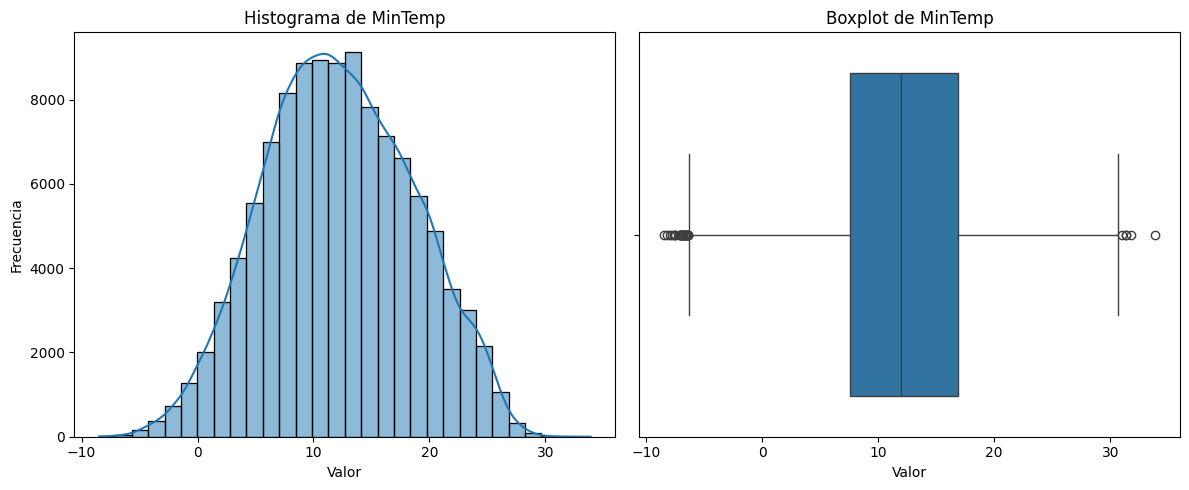



count    110870.000000
mean         12.207233
std           6.400636
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.900000
max          33.900000
Name: MinTemp, dtype: float64
Cantidad de NaN:  130


In [46]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['MinTemp'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de MinTemp')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['MinTemp'], ax=axes[1])
axes[1].set_title('Boxplot de MinTemp')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['MinTemp'].describe())
print('Cantidad de NaN: ',X_train['MinTemp'].isna().sum())

Imputamos valores faltantes por la mediana

In [47]:
print('Se imputan datos NaN de MinTemp... \n')

medianas_MinTemp_train = X_train.groupby(['Location', 'Year', 'Month'])['MinTemp'].median().reset_index()
X_train = X_train.merge(medianas_MinTemp_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['MinTemp'] = X_train['MinTemp'].fillna(X_train['MinTemp_mediana'])

print('Cantidad de NaN en el dataset de medianas de MinTemp: ', medianas_MinTemp_train[medianas_MinTemp_train['MinTemp'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['MinTemp'].isna()].shape[0])


Se imputan datos NaN de MinTemp... 

Cantidad de NaN en el dataset de medianas de MinTemp:  0
Cantidad de NaN en el dataset X_train:  0


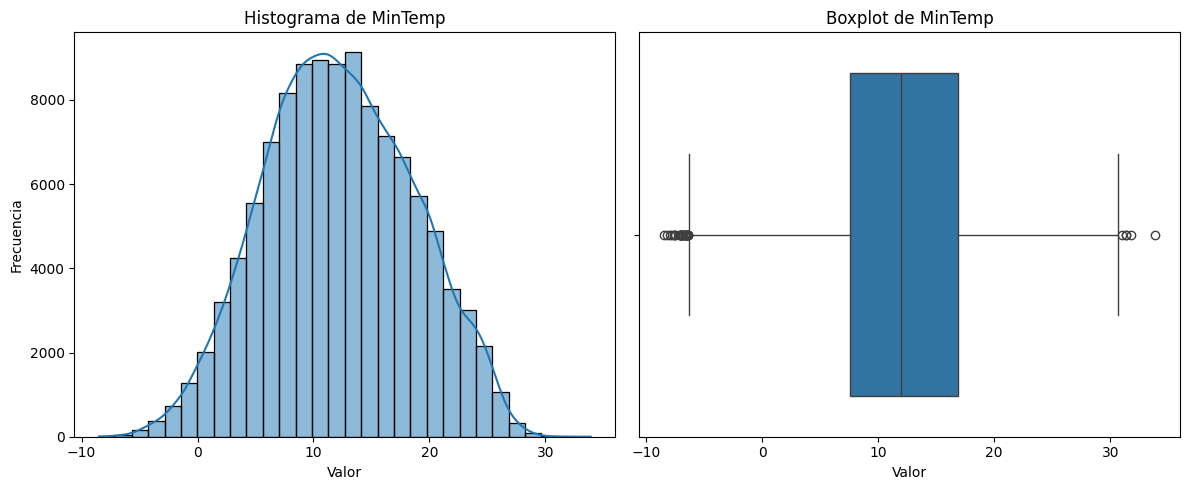



count    111000.000000
mean         12.208530
std           6.399727
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.900000
max          33.900000
Name: MinTemp, dtype: float64
Cantidad de NaN:  0


In [48]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['MinTemp'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de MinTemp')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['MinTemp'], ax=axes[1])
axes[1].set_title('Boxplot de MinTemp')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()

print('\n')
print(X_train['MinTemp'].describe())
print('Cantidad de NaN: ',X_train['MinTemp'].isna().sum())

#### MaxTemp

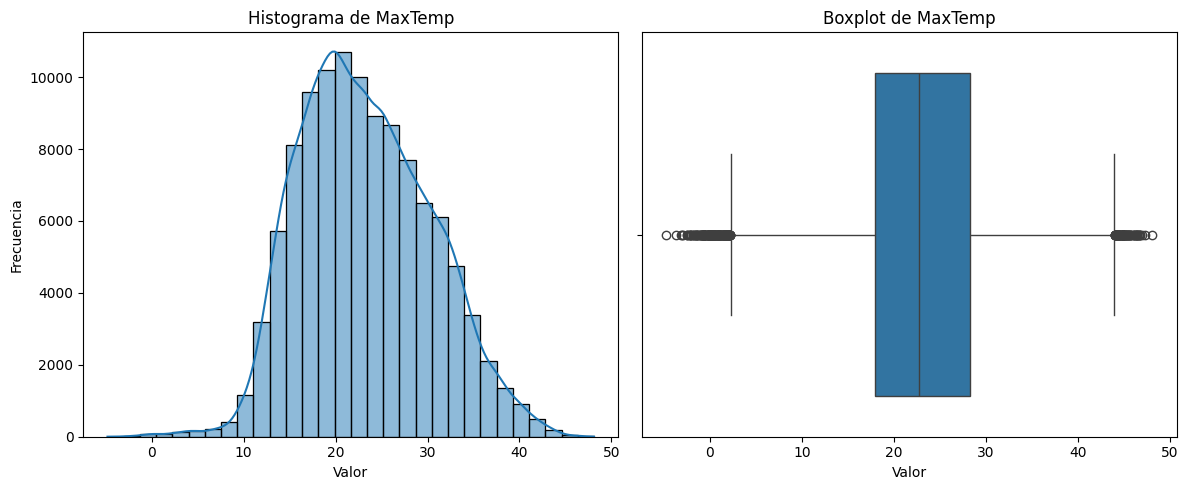



count    110914.000000
mean         23.265468
std           7.100569
min          -4.800000
25%          17.900000
50%          22.700000
75%          28.300000
max          48.100000
Name: MaxTemp, dtype: float64
Cantidad de NaN:  86


In [49]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['MaxTemp'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de MaxTemp')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['MaxTemp'], ax=axes[1])
axes[1].set_title('Boxplot de MaxTemp')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()

print('\n')
print(X_train['MaxTemp'].describe())
print('Cantidad de NaN: ',X_train['MaxTemp'].isna().sum())

In [50]:
print('Se imputan datos NaN de MaxTemp... \n')

medianas_MaxTemp_train = X_train.groupby(['Location', 'Year', 'Month'])['MaxTemp'].median().reset_index()
X_train = X_train.merge(medianas_MaxTemp_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['MaxTemp'] = X_train['MaxTemp'].fillna(X_train['MaxTemp_mediana'])

print('Cantidad de NaN en el dataset de medianas de MaxTemp: ', medianas_MaxTemp_train[medianas_MaxTemp_train['MaxTemp'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['MaxTemp'].isna()].shape[0])

Se imputan datos NaN de MaxTemp... 

Cantidad de NaN en el dataset de medianas de MaxTemp:  0
Cantidad de NaN en el dataset X_train:  0


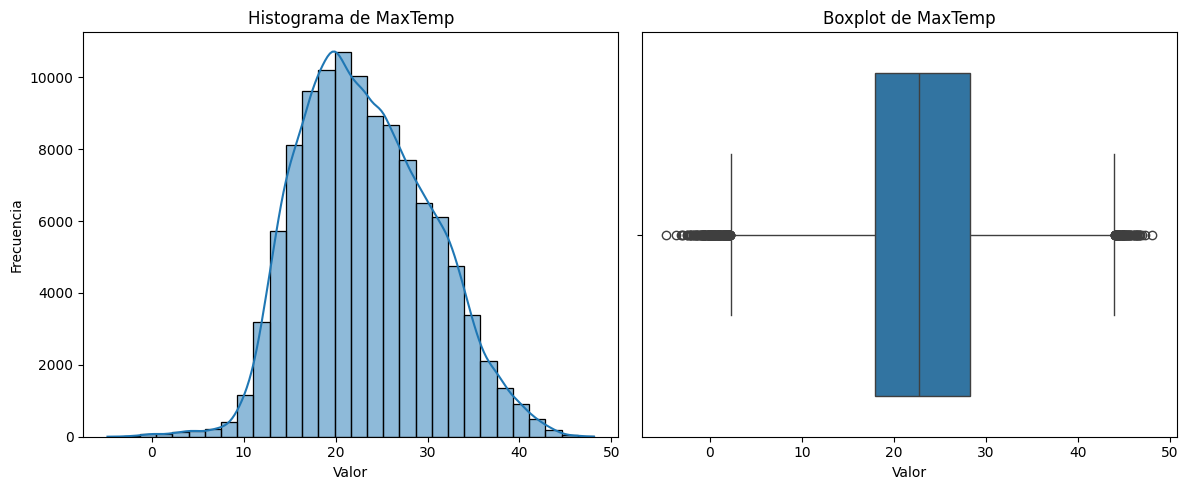



count    111000.000000
mean         23.268031
std           7.100723
min          -4.800000
25%          17.900000
50%          22.700000
75%          28.300000
max          48.100000
Name: MaxTemp, dtype: float64
Cantidad de NaN:  0


In [51]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['MaxTemp'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de MaxTemp')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['MaxTemp'], ax=axes[1])
axes[1].set_title('Boxplot de MaxTemp')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['MaxTemp'].describe())
print('Cantidad de NaN: ',X_train['MaxTemp'].isna().sum())

#### Temp9am

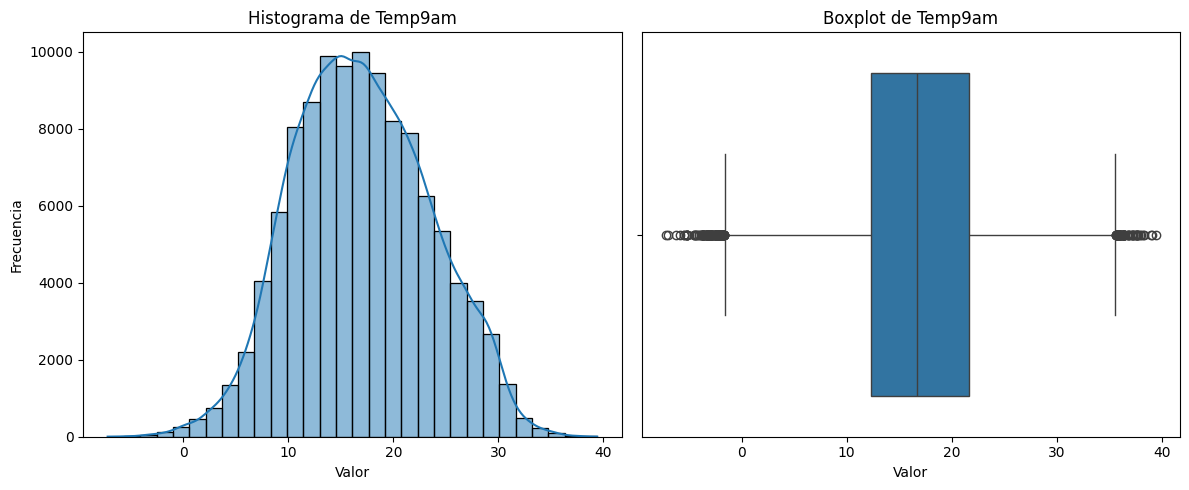



count    110892.000000
mean         16.994986
std           6.502327
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.600000
max          39.400000
Name: Temp9am, dtype: float64
Cantidad de NaN:  108


In [52]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Temp9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Temp9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Temp9am'], ax=axes[1])
axes[1].set_title('Boxplot de Temp9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Temp9am'].describe())
print('Cantidad de NaN: ',X_train['Temp9am'].isna().sum())

In [53]:
print('Se imputan datos NaN de Temp9am... \n')

medianas_Temp9am_train = X_train.groupby(['Location', 'Year', 'Month'])['Temp9am'].median().reset_index()
X_train = X_train.merge(medianas_Temp9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Temp9am'] = X_train['Temp9am'].fillna(X_train['Temp9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de Temp9am: ', medianas_Temp9am_train[medianas_Temp9am_train['Temp9am'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Temp9am'].isna()].shape[0])

Se imputan datos NaN de Temp9am... 

Cantidad de NaN en el dataset de medianas de Temp9am:  0
Cantidad de NaN en el dataset X_train:  0


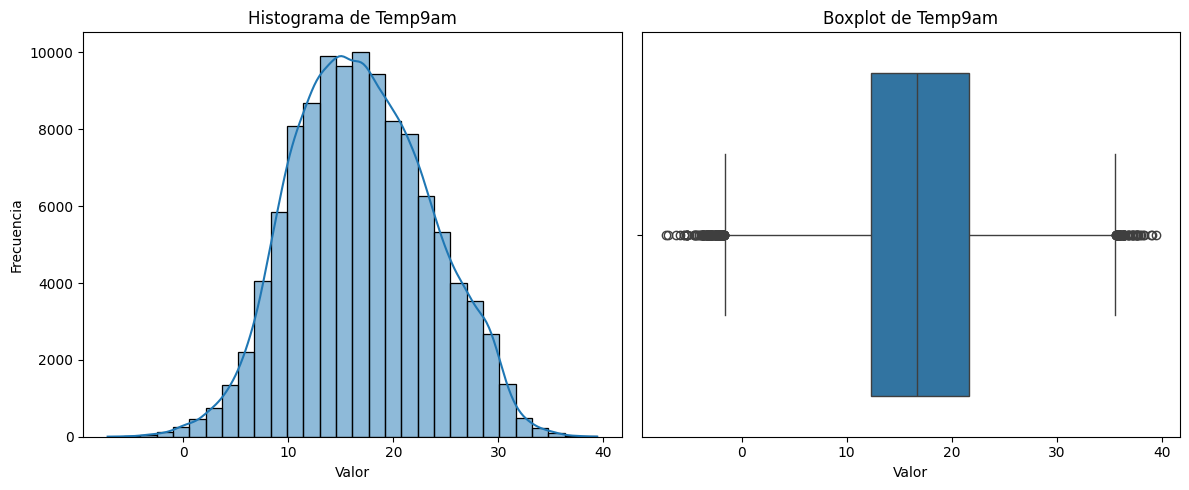



count    111000.000000
mean         16.992256
std           6.501977
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.600000
max          39.400000
Name: Temp9am, dtype: float64
Cantidad de NaN:  0


In [54]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Temp9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Temp9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Temp9am'], ax=axes[1])
axes[1].set_title('Boxplot de Temp9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Temp9am'].describe())
print('Cantidad de NaN: ',X_train['Temp9am'].isna().sum())

#### Temp3pm

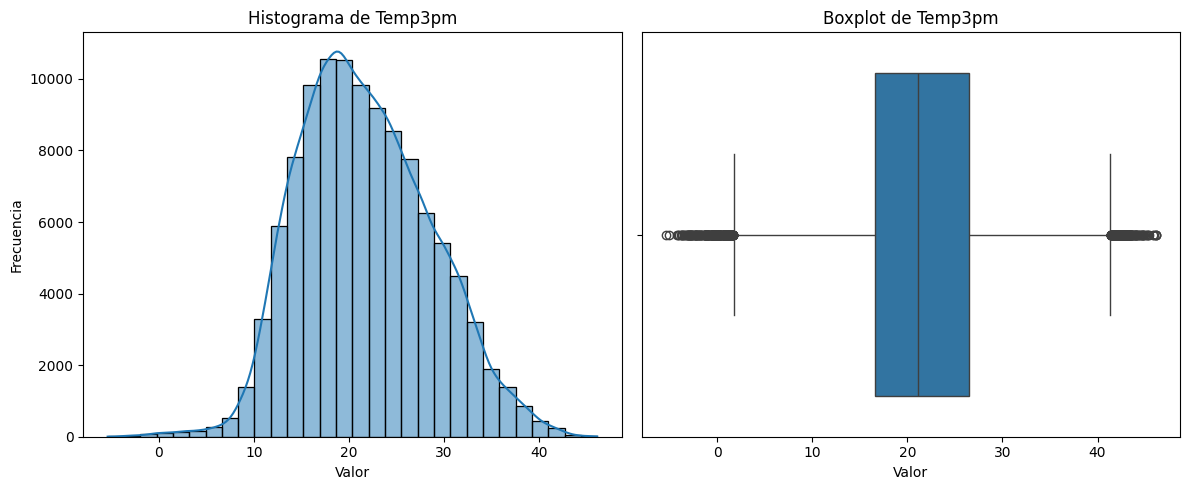



count    110219.000000
mean         21.702207
std           6.931289
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.500000
max          46.100000
Name: Temp3pm, dtype: float64
Cantidad de NaN:  781


In [55]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Temp3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Temp3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Temp3pm'], ax=axes[1])
axes[1].set_title('Boxplot de Temp3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Temp3pm'].describe())
print('Cantidad de NaN: ',X_train['Temp3pm'].isna().sum())

In [56]:
print('Se imputan datos NaN de Temp3pm... \n')
medianas_Temp3pm_train = X_train.groupby(['Location', 'Year', 'Month'])['Temp3pm'].median().reset_index()
X_train = X_train.merge(medianas_Temp3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Temp3pm'] = X_train['Temp3pm'].fillna(X_train['Temp3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Temp3pm: ', medianas_Temp3pm_train[medianas_Temp3pm_train['Temp3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Temp3pm'].isna()].shape[0])

Se imputan datos NaN de Temp3pm... 

Cantidad de NaN en el dataset de medianas de Temp3pm:  32
Cantidad de NaN en el dataset X_train:  691


In [57]:
print('Se imputan datos NaN de Temp3pm... \n')
medianas_Temp3pm_train['Temp3pm'] = medianas_Temp3pm_train['Temp3pm'].fillna(X_train.groupby(['Location', 'Month'])['Temp3pm'].transform('median'))
X_train=X_train.drop(columns = 'Temp3pm_mediana')
X_train = X_train.merge(medianas_Temp3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Temp3pm'] = X_train['Temp3pm'].fillna(X_train['Temp3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Temp3pm: ', medianas_Temp3pm_train[medianas_Temp3pm_train['Temp3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Temp3pm'].isna()].shape[0])

Se imputan datos NaN de Temp3pm... 

Cantidad de NaN en el dataset de medianas de Temp3pm:  0
Cantidad de NaN en el dataset X_train:  0


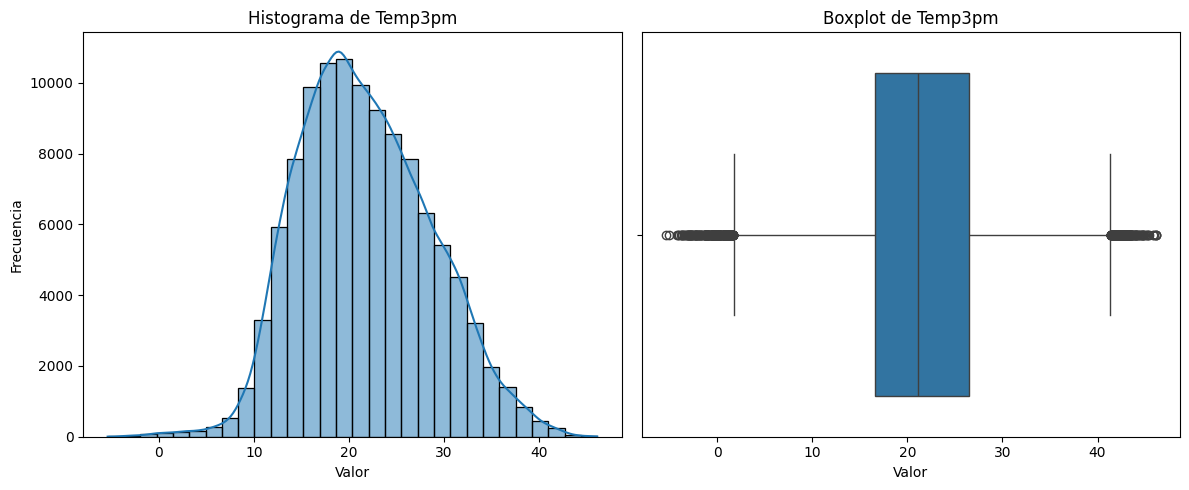



count    111000.000000
mean         21.706988
std           6.935318
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.500000
max          46.100000
Name: Temp3pm, dtype: float64
Cantidad de NaN:  0


In [58]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Temp3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Temp3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Temp3pm'], ax=axes[1])
axes[1].set_title('Boxplot de Temp3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Temp3pm'].describe())
print('Cantidad de NaN: ',X_train['Temp3pm'].isna().sum())

### Rainfall

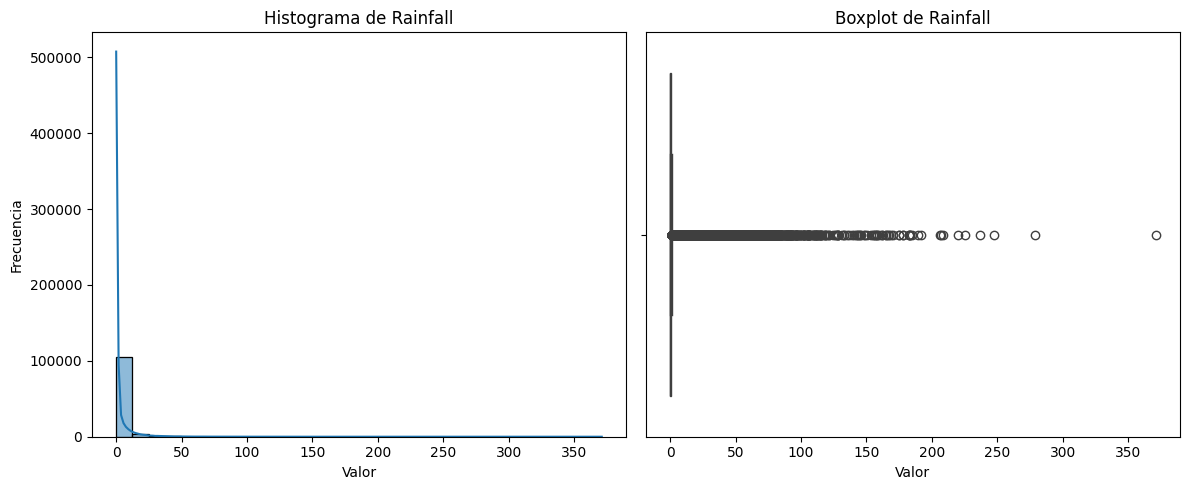



count    110189.00000
mean          2.32420
std           8.35591
min           0.00000
25%           0.00000
50%           0.00000
75%           0.60000
max         371.00000
Name: Rainfall, dtype: float64
Cantidad de NaN:  811


In [59]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Rainfall'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Rainfall')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Rainfall'], ax=axes[1])
axes[1].set_title('Boxplot de Rainfall')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Rainfall'].describe())
print('Cantidad de NaN: ',X_train['Rainfall'].isna().sum())

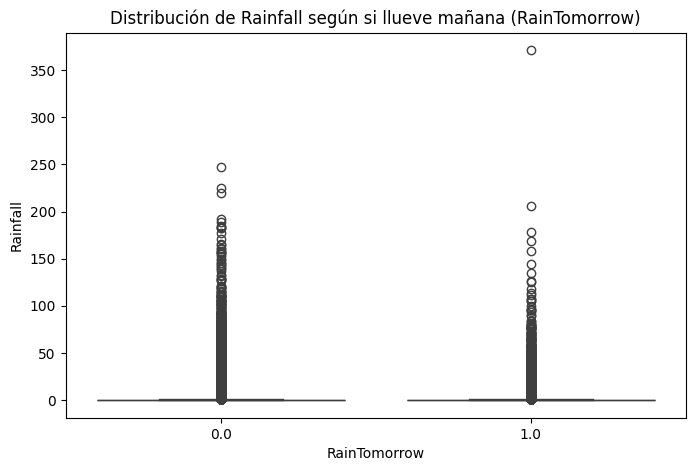

In [60]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Rainfall', data=X_train)
plt.title('Distribución de Rainfall según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Rainfall')
plt.show()

In [61]:
mediana_Rainfall_train = X_train['Rainfall'].median()
print('Mediana Rainfall: ',mediana_Rainfall_train)
X_train['Rainfall'] = X_train['Rainfall'].fillna(mediana_Rainfall_train)

Mediana Rainfall:  0.0


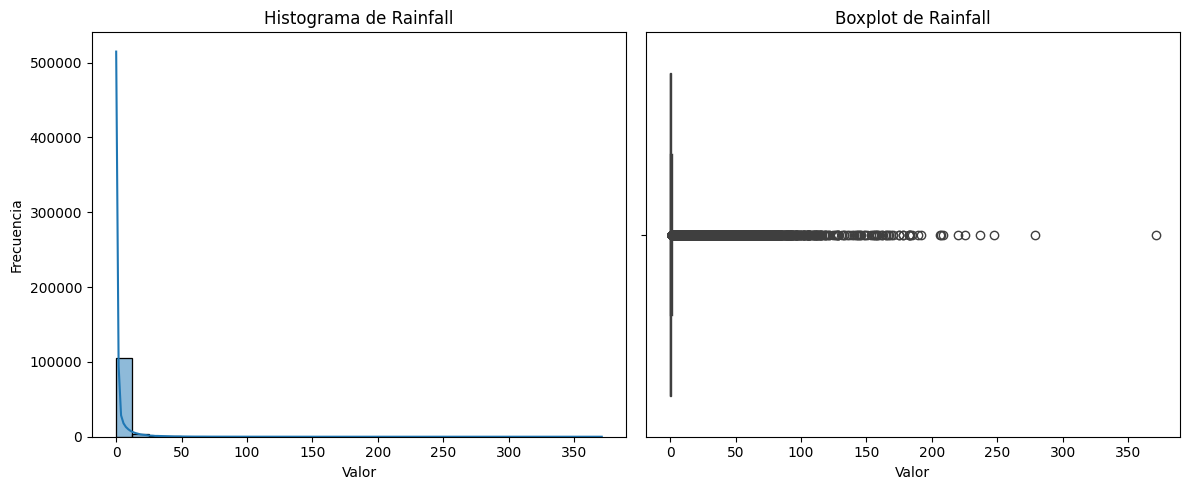



count    111000.000000
mean          2.307219
std           8.327681
min           0.000000
25%           0.000000
50%           0.000000
75%           0.600000
max         371.000000
Name: Rainfall, dtype: float64
Cantidad de NaN:  0


In [62]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Rainfall'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Rainfall')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Rainfall'], ax=axes[1])
axes[1].set_title('Boxplot de Rainfall')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Rainfall'].describe())
print('Cantidad de NaN: ',X_train['Rainfall'].isna().sum())

### Velocidades de viento

In [63]:
['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

#### WindGustSpeed

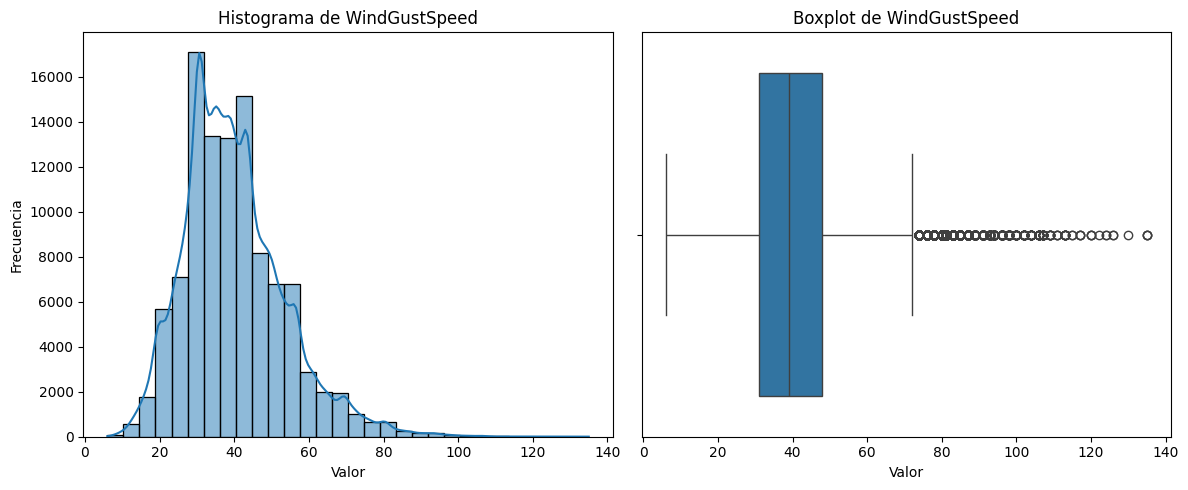



count    105662.000000
mean         39.976359
std          13.589603
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64
Cantidad de NaN:  5338


In [64]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['WindGustSpeed'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de WindGustSpeed')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['WindGustSpeed'], ax=axes[1])
axes[1].set_title('Boxplot de WindGustSpeed')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['WindGustSpeed'].describe())
print('Cantidad de NaN: ',X_train['WindGustSpeed'].isna().sum())

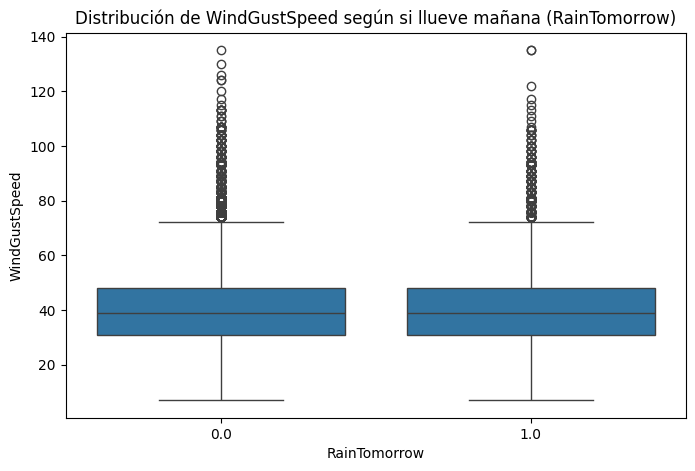

In [65]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='WindGustSpeed', data=X_train)
plt.title('Distribución de WindGustSpeed según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('WindGustSpeed')
plt.show()

Imputamos valores NaN

In [66]:
print('Se imputan datos NaN de WindGustSpeed...\n')
medianas_WindGustSpeed_train = X_train.groupby(['Location', 'Year', 'Month'])['WindGustSpeed'].median().reset_index()
X_train = X_train.merge(medianas_WindGustSpeed_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['WindGustSpeed'] = X_train['WindGustSpeed'].fillna(X_train['WindGustSpeed_mediana'])

print('Cantidad de NaN en el dataset de medianas de WindGustSpeed: ', medianas_WindGustSpeed_train[medianas_WindGustSpeed_train['WindGustSpeed'].isna()].shape[0])
print('Cantidad de NaN en WindGustSpeed en el dataset X_train: ', X_train[X_train['WindGustSpeed'].isna()].shape[0])

Se imputan datos NaN de WindGustSpeed...

Cantidad de NaN en el dataset de medianas de WindGustSpeed:  198
Cantidad de NaN en WindGustSpeed en el dataset X_train:  4262


Como seguimos teniendo valores NaN en nuestro dataset de medianas, imputamos teniendo en cuenta Location y Month

In [67]:
print('Se imputan datos NaN de WindGustSpeed... \n')
medianas_WindGustSpeed_train['WindGustSpeed'] = medianas_WindGustSpeed_train['WindGustSpeed'].fillna(X_train.groupby(['Location', 'Month'])['WindGustSpeed'].transform('median'))
X_train=X_train.drop(columns = 'WindGustSpeed_mediana')
X_train = X_train.merge(medianas_WindGustSpeed_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['WindGustSpeed'] = X_train['WindGustSpeed'].fillna(X_train['WindGustSpeed_mediana'])

print('Cantidad de NaN en el dataset de medianas de WindGustSpeed: ', medianas_WindGustSpeed_train[medianas_WindGustSpeed_train['WindGustSpeed'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindGustSpeed'].isna()].shape[0])

Se imputan datos NaN de WindGustSpeed... 

Cantidad de NaN en el dataset de medianas de WindGustSpeed:  8
Cantidad de NaN en el dataset X_train:  146


Como seguimos teniendo valores NaN en nuestro dataset de medianas, imputamos teniendo en cuenta Location

In [68]:
print('Se imputan datos NaN de WindGustSpeed... \n')
medianas_WindGustSpeed_train['WindGustSpeed'] = medianas_WindGustSpeed_train['WindGustSpeed'].fillna(X_train.groupby(['Location'])['WindGustSpeed'].transform('median'))
X_train=X_train.drop(columns = 'WindGustSpeed_mediana')
X_train = X_train.merge(medianas_WindGustSpeed_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['WindGustSpeed'] = X_train['WindGustSpeed'].fillna(X_train['WindGustSpeed_mediana'])

print('Cantidad de NaN en el dataset de medianas de WindGustSpeed: ', medianas_WindGustSpeed_train[medianas_WindGustSpeed_train['WindGustSpeed'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindGustSpeed'].isna()].shape[0])

Se imputan datos NaN de WindGustSpeed... 

Cantidad de NaN en el dataset de medianas de WindGustSpeed:  0
Cantidad de NaN en el dataset X_train:  0


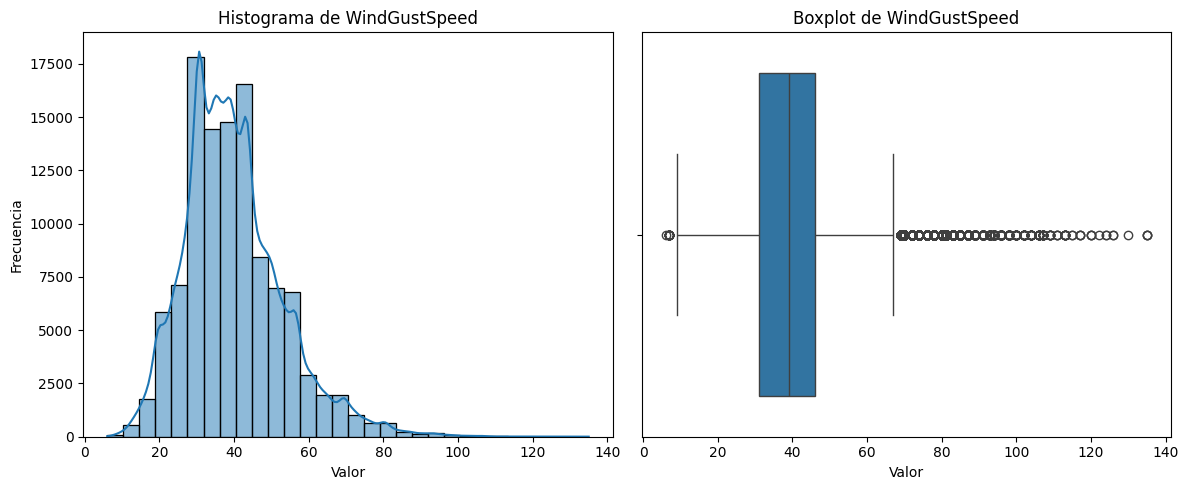



count    111000.000000
mean         39.878455
std          13.334897
min           6.000000
25%          31.000000
50%          39.000000
75%          46.000000
max         135.000000
Name: WindGustSpeed, dtype: float64
Cantidad de NaN:  0


In [69]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['WindGustSpeed'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de WindGustSpeed')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['WindGustSpeed'], ax=axes[1])
axes[1].set_title('Boxplot de WindGustSpeed')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['WindGustSpeed'].describe())
print('Cantidad de NaN: ',X_train['WindGustSpeed'].isna().sum())

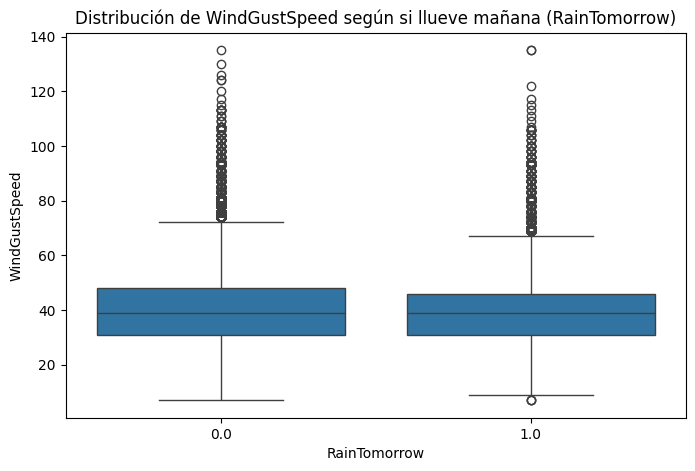

In [70]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='WindGustSpeed', data=X_train)
plt.title('Distribución de WindGustSpeed según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('WindGustSpeed')
plt.show()

#### WindSpeed9am

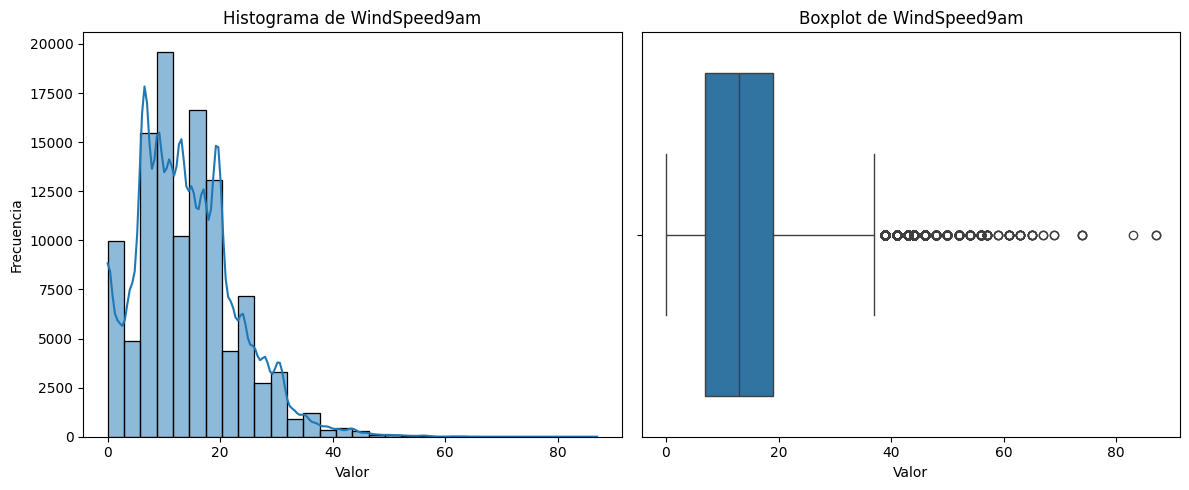



count    110839.000000
mean         14.070923
std           8.859405
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max          87.000000
Name: WindSpeed9am, dtype: float64
Cantidad de NaN:  161


In [71]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['WindSpeed9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de WindSpeed9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['WindSpeed9am'], ax=axes[1])
axes[1].set_title('Boxplot de WindSpeed9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['WindSpeed9am'].describe())
print('Cantidad de NaN: ',X_train['WindSpeed9am'].isna().sum())

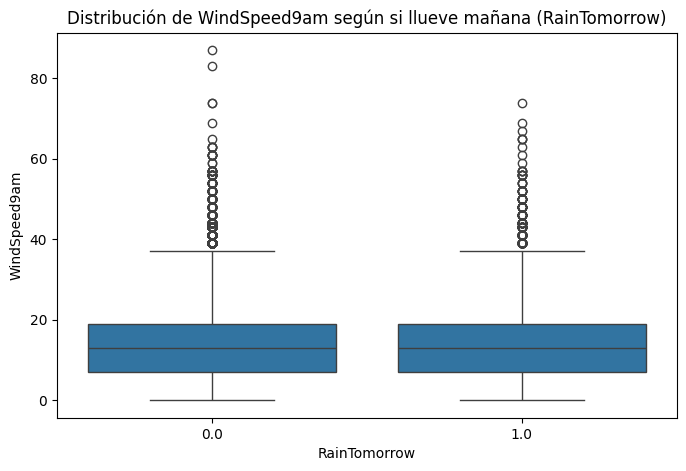

In [72]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='WindSpeed9am', data=X_train)
plt.title('Distribución de WindSpeed9am según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('WindSpeed9am')
plt.show()

Se imputan valores NaN

In [73]:
print('Se imputan datos NaN de WindSpeed9am...\n')
medianas_WindSpeed9am_train = X_train.groupby(['Location', 'Year', 'Month'])['WindSpeed9am'].median().reset_index()
X_train = X_train.merge(medianas_WindSpeed9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['WindSpeed9am'] = X_train['WindSpeed9am'].fillna(X_train['WindSpeed9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de WindSpeed9am: ', medianas_WindSpeed9am_train[medianas_WindSpeed9am_train['WindSpeed9am'].isna()].shape[0])
print('Cantidad de NaN en WindSpeed9am en el dataset X_train: ', X_train[X_train['WindSpeed9am'].isna()].shape[0])

Se imputan datos NaN de WindSpeed9am...

Cantidad de NaN en el dataset de medianas de WindSpeed9am:  0
Cantidad de NaN en WindSpeed9am en el dataset X_train:  0


#### WindSpeed3pm

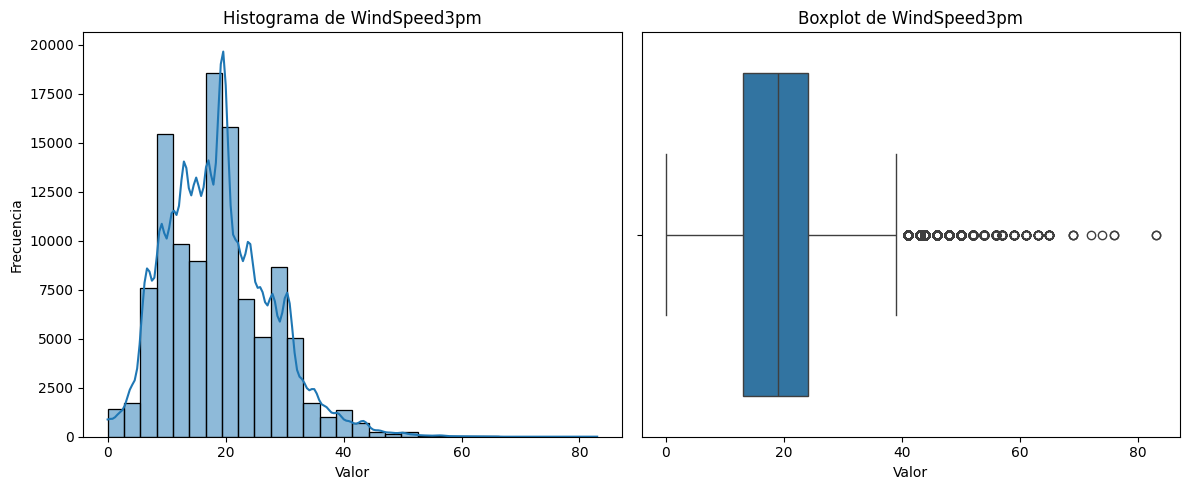



count    110680.000000
mean         18.688336
std           8.768681
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          83.000000
Name: WindSpeed3pm, dtype: float64
Cantidad de NaN:  320


In [74]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['WindSpeed3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de WindSpeed3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['WindSpeed3pm'], ax=axes[1])
axes[1].set_title('Boxplot de WindSpeed3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['WindSpeed3pm'].describe())
print('Cantidad de NaN: ',X_train['WindSpeed3pm'].isna().sum())

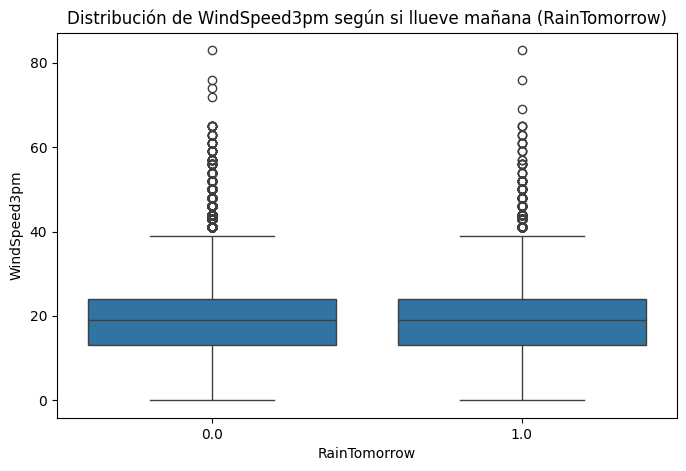

In [75]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='WindSpeed3pm', data=X_train)
plt.title('Distribución de WindSpeed3pm según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('WindSpeed3pm')
plt.show()

Se imputan valores NaN

In [76]:
print('Se imputan datos NaN de WindSpeed3pm...\n')
medianas_WindSpeed3pm_train = X_train.groupby(['Location', 'Year', 'Month'])['WindSpeed3pm'].median().reset_index()
X_train = X_train.merge(medianas_WindSpeed3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['WindSpeed3pm'] = X_train['WindSpeed3pm'].fillna(X_train['WindSpeed3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de WindSpeed3pm: ', medianas_WindSpeed3pm_train[medianas_WindSpeed3pm_train['WindSpeed3pm'].isna()].shape[0])
print('Cantidad de NaN en WindSpeed3pm en el dataset X_train: ', X_train[X_train['WindSpeed3pm'].isna()].shape[0])

Se imputan datos NaN de WindSpeed3pm...

Cantidad de NaN en el dataset de medianas de WindSpeed3pm:  9
Cantidad de NaN en WindSpeed3pm en el dataset X_train:  170


Como seguimos teniendo valores NaN en nuestro dataset de medianas, imputamos teniendo en cuenta Location y Month

In [77]:
print('Se imputan datos NaN de WindSpeed3pm... \n')
medianas_WindSpeed3pm_train['WindSpeed3pm'] = medianas_WindSpeed3pm_train['WindSpeed3pm'].fillna(X_train.groupby(['Location', 'Month'])['WindSpeed3pm'].transform('median'))
X_train = X_train.drop(columns = 'WindSpeed3pm_mediana')
X_train = X_train.merge(medianas_WindSpeed3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['WindSpeed3pm'] = X_train['WindSpeed3pm'].fillna(X_train['WindSpeed3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de WindSpeed3pm: ', medianas_WindSpeed3pm_train[medianas_WindSpeed3pm_train['WindSpeed3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['WindSpeed3pm'].isna()].shape[0])

Se imputan datos NaN de WindSpeed3pm... 

Cantidad de NaN en el dataset de medianas de WindSpeed3pm:  0
Cantidad de NaN en el dataset X_train:  0


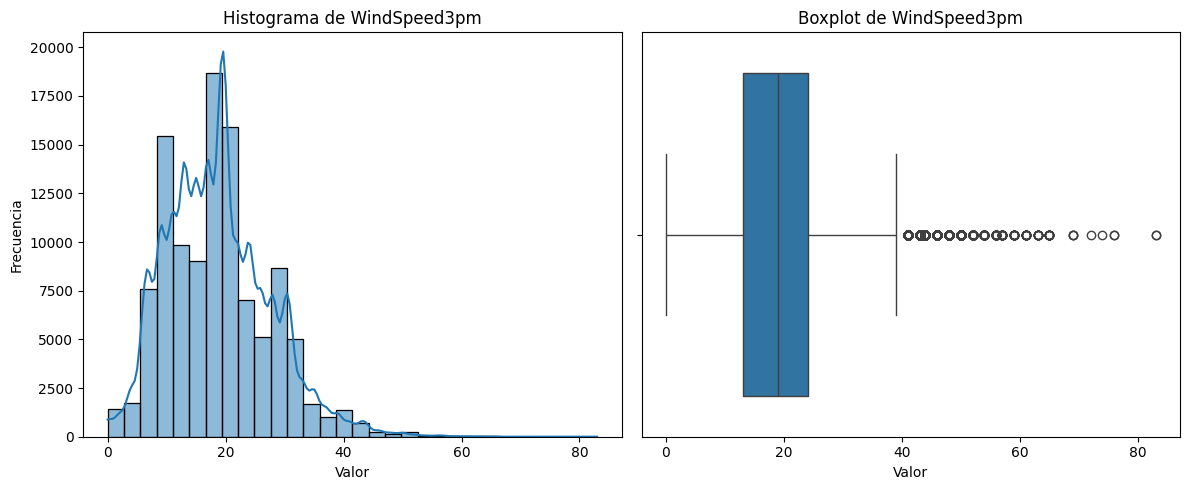



count    111000.000000
mean         18.686167
std           8.757854
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          83.000000
Name: WindSpeed3pm, dtype: float64
Cantidad de NaN:  0


In [78]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['WindSpeed3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de WindSpeed3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['WindSpeed3pm'], ax=axes[1])
axes[1].set_title('Boxplot de WindSpeed3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['WindSpeed3pm'].describe())
print('Cantidad de NaN: ',X_train['WindSpeed3pm'].isna().sum())

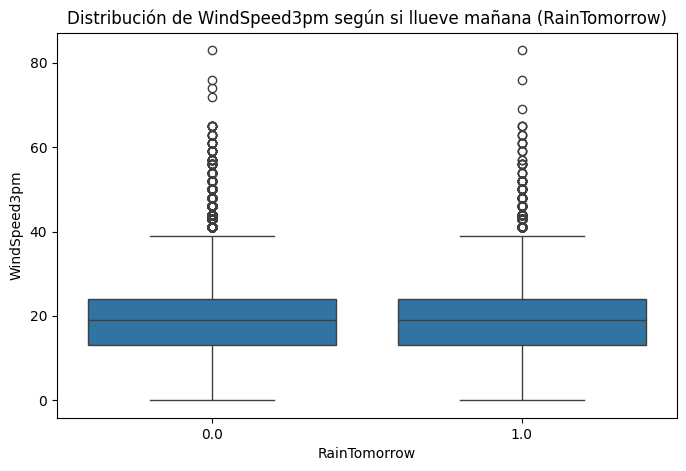

In [79]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='WindSpeed3pm', data=X_train)
plt.title('Distribución de WindSpeed3pm según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('WindSpeed3pm')
plt.show()

### Humedad

#### Humidity9am

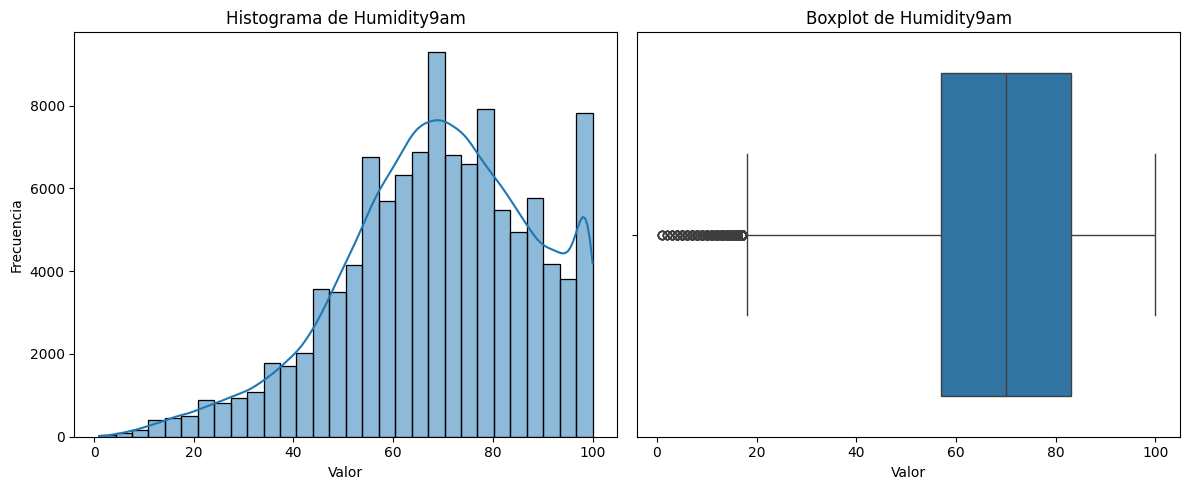



count    110296.000000
mean         68.737316
std          19.061128
min           1.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64
Cantidad de NaN:  704


In [80]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Humidity9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Humidity9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Humidity9am'], ax=axes[1])
axes[1].set_title('Boxplot de Humidity9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Humidity9am'].describe())
print('Cantidad de NaN: ',X_train['Humidity9am'].isna().sum())

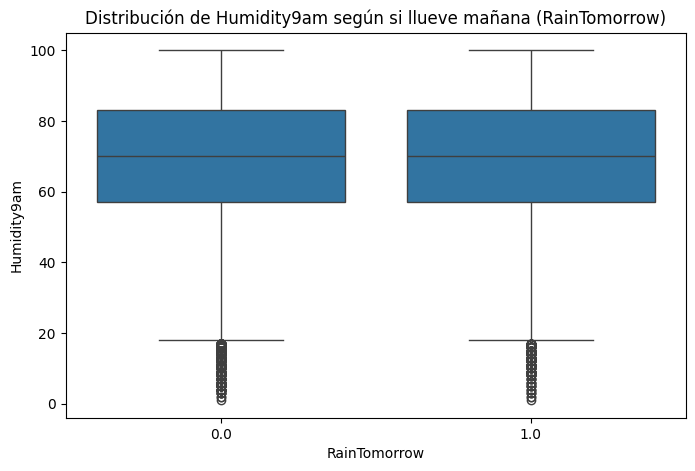

In [81]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Humidity9am', data=X_train)
plt.title('Distribución de Humidity9am según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Humidity9am')
plt.show()

In [82]:
print('Se imputan datos NaN de Humidity9am...\n')
medianas_Humidity9am_train = X_train.groupby(['Location', 'Year', 'Month'])['Humidity9am'].median().reset_index()
X_train = X_train.merge(medianas_Humidity9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Humidity9am'] = X_train['Humidity9am'].fillna(X_train['Humidity9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de Humidity9am: ', medianas_Humidity9am_train[medianas_Humidity9am_train['Humidity9am'].isna()].shape[0])
print('Cantidad de NaN en Humidity9am en el dataset X_train: ', X_train[X_train['Humidity9am'].isna()].shape[0])

Se imputan datos NaN de Humidity9am...

Cantidad de NaN en el dataset de medianas de Humidity9am:  14
Cantidad de NaN en Humidity9am en el dataset X_train:  320


In [83]:
print('Se imputan datos NaN de Humidity9am... \n')
medianas_Humidity9am_train['Humidity9am'] = medianas_Humidity9am_train['Humidity9am'].fillna(X_train.groupby(['Location', 'Month'])['Humidity9am'].transform('median'))
X_train = X_train.drop(columns = 'Humidity9am_mediana')
X_train = X_train.merge(medianas_Humidity9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Humidity9am'] = X_train['Humidity9am'].fillna(X_train['Humidity9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de Humidity9am: ', medianas_Humidity9am_train[medianas_Humidity9am_train['Humidity9am'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Humidity9am'].isna()].shape[0])

Se imputan datos NaN de Humidity9am... 

Cantidad de NaN en el dataset de medianas de Humidity9am:  0
Cantidad de NaN en el dataset X_train:  0


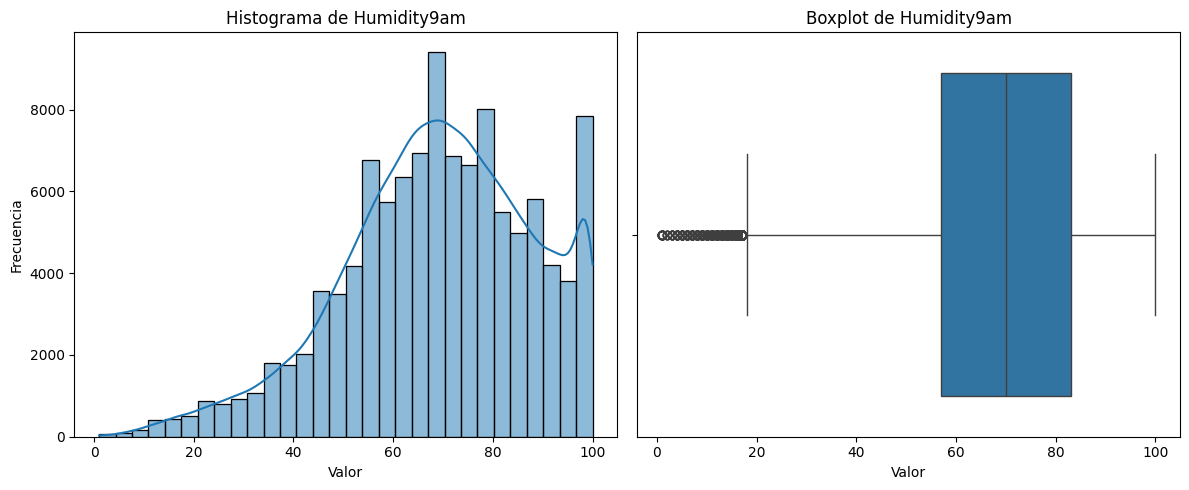



count    111000.000000
mean         68.735554
std          19.056412
min           1.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64
Cantidad de NaN:  0


In [84]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Humidity9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Humidity9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Humidity9am'], ax=axes[1])
axes[1].set_title('Boxplot de Humidity9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Humidity9am'].describe())
print('Cantidad de NaN: ',X_train['Humidity9am'].isna().sum())

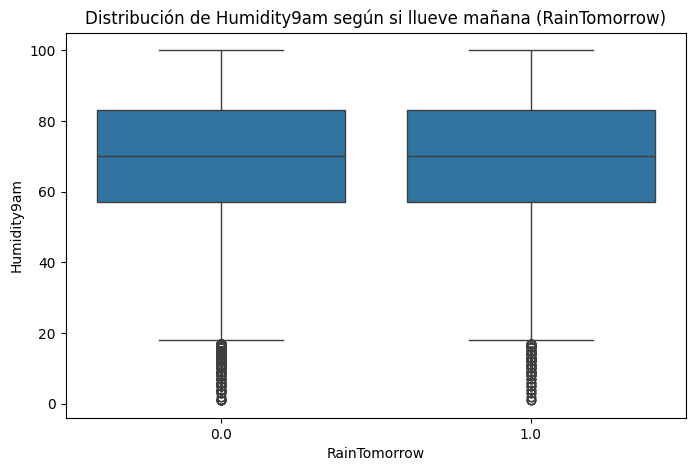

In [85]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Humidity9am', data=X_train)
plt.title('Distribución de Humidity9am según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Humidity9am')
plt.show()

#### Humidity3pm

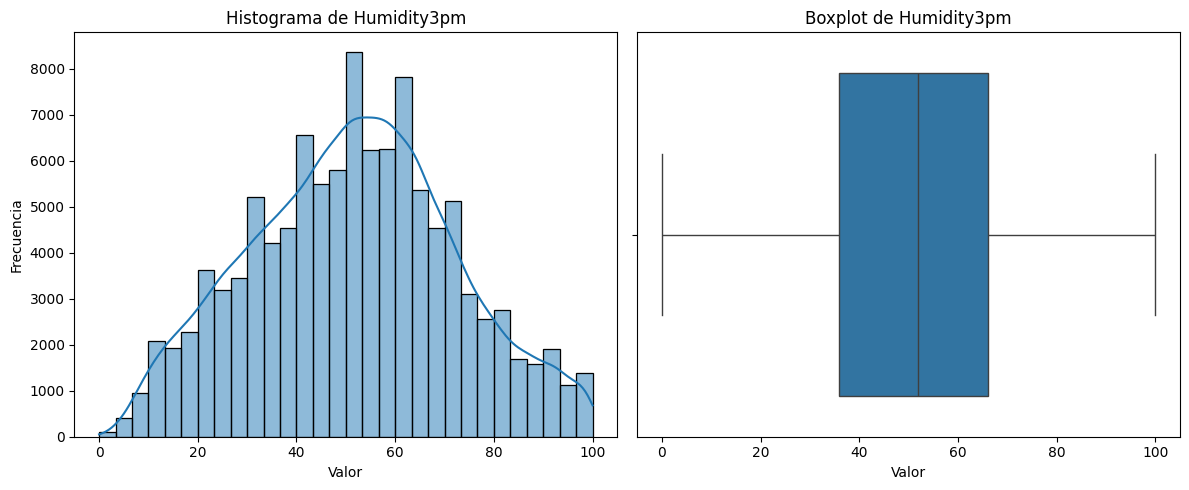



count    109596.00000
mean         51.43831
std          20.78030
min           0.00000
25%          36.00000
50%          52.00000
75%          66.00000
max         100.00000
Name: Humidity3pm, dtype: float64
Cantidad de NaN:  1404


In [86]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Humidity3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Humidity3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Humidity3pm'], ax=axes[1])
axes[1].set_title('Boxplot de Humidity3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Humidity3pm'].describe())
print('Cantidad de NaN: ',X_train['Humidity3pm'].isna().sum())

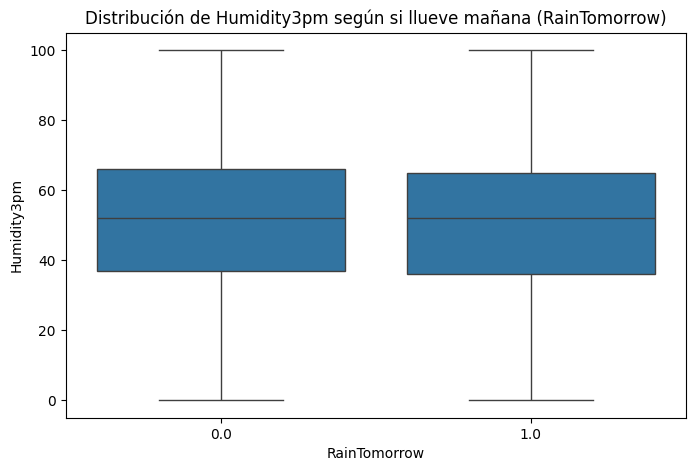

In [87]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Humidity3pm', data=X_train)
plt.title('Distribución de Humidity3pm según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Humidity3pm')
plt.show()

In [88]:
print('Se imputan datos NaN de Humidity3pm...\n')
medianas_Humidity3pm_train = X_train.groupby(['Location', 'Year', 'Month'])['Humidity3pm'].median().reset_index()
X_train = X_train.merge(medianas_Humidity3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Humidity3pm'] = X_train['Humidity3pm'].fillna(X_train['Humidity3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Humidity3pm: ', medianas_Humidity3pm_train[medianas_Humidity3pm_train['Humidity3pm'].isna()].shape[0])
print('Cantidad de NaN en Humidity3pm en el dataset X_train: ', X_train[X_train['Humidity3pm'].isna()].shape[0])

Se imputan datos NaN de Humidity3pm...

Cantidad de NaN en el dataset de medianas de Humidity3pm:  46
Cantidad de NaN en Humidity3pm en el dataset X_train:  1011


In [89]:
print('Se imputan datos NaN de Humidity3pm... \n')
medianas_Humidity3pm_train['Humidity3pm'] = medianas_Humidity3pm_train['Humidity3pm'].fillna(X_train.groupby(['Location', 'Month'])['Humidity3pm'].transform('median'))
X_train = X_train.drop(columns = 'Humidity3pm_mediana')
X_train = X_train.merge(medianas_Humidity3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Humidity3pm'] = X_train['Humidity3pm'].fillna(X_train['Humidity3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Humidity3pm: ', medianas_Humidity3pm_train[medianas_Humidity3pm_train['Humidity3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Humidity3pm'].isna()].shape[0])

Se imputan datos NaN de Humidity3pm... 

Cantidad de NaN en el dataset de medianas de Humidity3pm:  0
Cantidad de NaN en el dataset X_train:  0


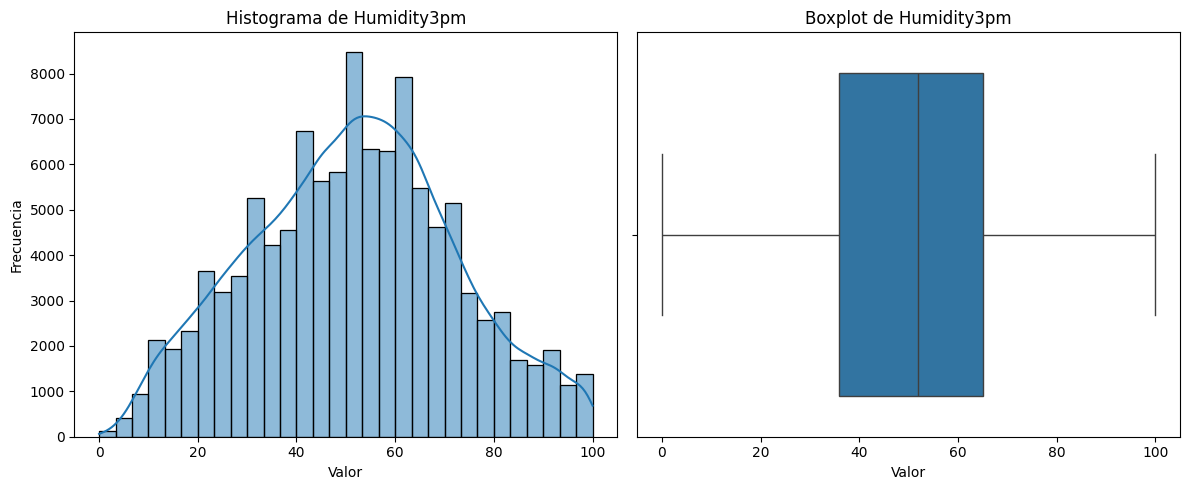



count    111000.000000
mean         51.392392
std          20.755704
min           0.000000
25%          36.000000
50%          52.000000
75%          65.000000
max         100.000000
Name: Humidity3pm, dtype: float64
Cantidad de NaN:  0


In [90]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Humidity3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Humidity3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Humidity3pm'], ax=axes[1])
axes[1].set_title('Boxplot de Humidity3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Humidity3pm'].describe())
print('Cantidad de NaN: ',X_train['Humidity3pm'].isna().sum())

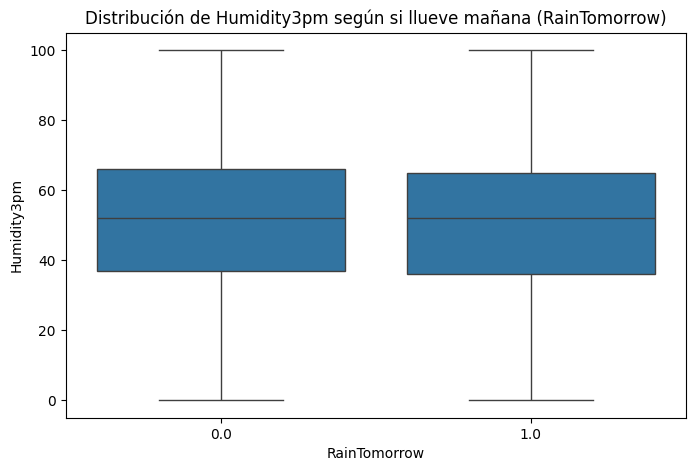

In [91]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Humidity3pm', data=X_train)
plt.title('Distribución de Humidity3pm según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Humidity3pm')
plt.show()

### Presion

#### Pressure9am

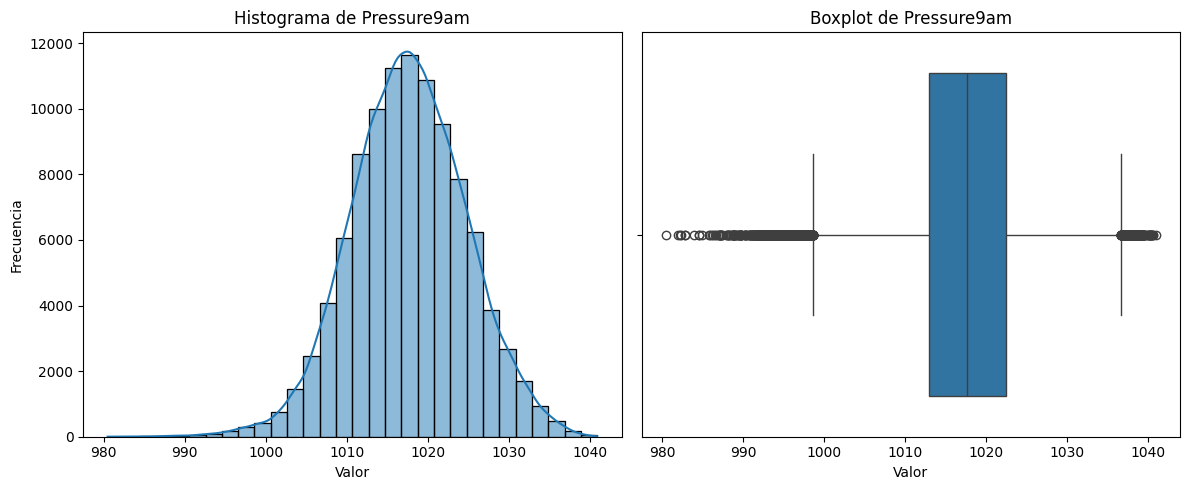



count    101793.000000
mean       1017.648279
std           7.112648
min         980.500000
25%        1012.900000
50%        1017.600000
75%        1022.400000
max        1040.900000
Name: Pressure9am, dtype: float64
Cantidad de NaN:  9207


In [92]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Pressure9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Pressure9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Pressure9am'], ax=axes[1])
axes[1].set_title('Boxplot de Pressure9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Pressure9am'].describe())
print('Cantidad de NaN: ',X_train['Pressure9am'].isna().sum())

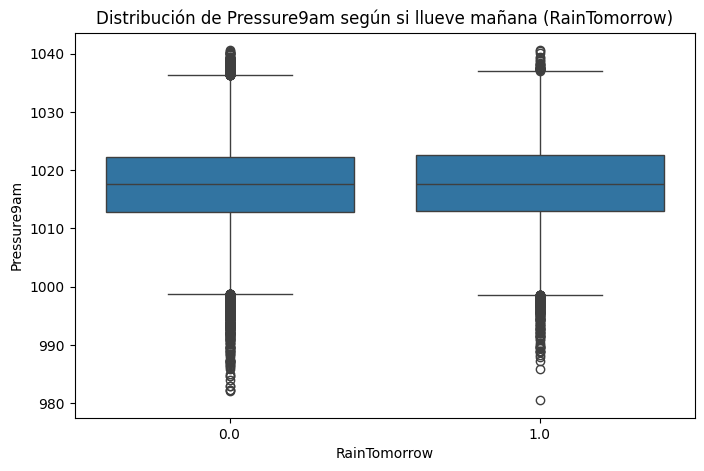

In [93]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Pressure9am', data=X_train)
plt.title('Distribución de Pressure9am según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Pressure9am')
plt.show()

In [94]:
print('Se imputan datos NaN de Pressure9am...\n')
medianas_Pressure9am_train = X_train.groupby(['Location', 'Year', 'Month'])['Pressure9am'].median().reset_index()
X_train = X_train.merge(medianas_Pressure9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Pressure9am'] = X_train['Pressure9am'].fillna(X_train['Pressure9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de Pressure9am: ', medianas_Pressure9am_train[medianas_Pressure9am_train['Pressure9am'].isna()].shape[0])
print('Cantidad de NaN en Pressure9am en el dataset X_train: ', X_train[X_train['Pressure9am'].isna()].shape[0])

Se imputan datos NaN de Pressure9am...

Cantidad de NaN en el dataset de medianas de Pressure9am:  416
Cantidad de NaN en Pressure9am en el dataset X_train:  8935


In [95]:
print('Se imputan datos NaN de Pressure9am... \n')
medianas_Pressure9am_train['Pressure9am'] = medianas_Pressure9am_train['Pressure9am'].fillna(X_train.groupby(['Location', 'Month'])['Pressure9am'].transform('median'))
X_train = X_train.drop(columns = 'Pressure9am_mediana')
X_train = X_train.merge(medianas_Pressure9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Pressure9am'] = X_train['Pressure9am'].fillna(X_train['Pressure9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de Pressure9am: ', medianas_Pressure9am_train[medianas_Pressure9am_train['Pressure9am'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Pressure9am'].isna()].shape[0])

Se imputan datos NaN de Pressure9am... 

Cantidad de NaN en el dataset de medianas de Pressure9am:  34
Cantidad de NaN en el dataset X_train:  784


In [96]:
print('Se imputan datos NaN de Pressure9am... \n')
medianas_Pressure9am_train['Pressure9am'] = medianas_Pressure9am_train['Pressure9am'].fillna(X_train.groupby(['Location'])['Pressure9am'].transform('median'))
X_train = X_train.drop(columns = 'Pressure9am_mediana')
X_train = X_train.merge(medianas_Pressure9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Pressure9am'] = X_train['Pressure9am'].fillna(X_train['Pressure9am_mediana'])

print('Cantidad de NaN en el dataset de medianas de Pressure9am: ', medianas_Pressure9am_train[medianas_Pressure9am_train['Pressure9am'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Pressure9am'].isna()].shape[0])

Se imputan datos NaN de Pressure9am... 

Cantidad de NaN en el dataset de medianas de Pressure9am:  0
Cantidad de NaN en el dataset X_train:  0


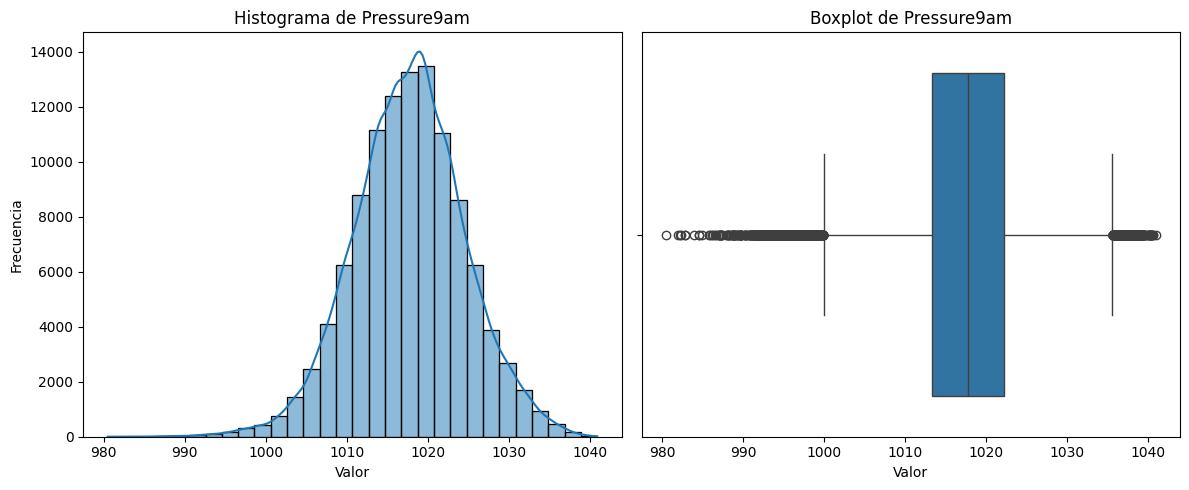



count    111000.000000
mean       1017.717064
std           6.877042
min         980.500000
25%        1013.300000
50%        1017.800000
75%        1022.200000
max        1040.900000
Name: Pressure9am, dtype: float64
Cantidad de NaN:  0


In [97]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Pressure9am'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Pressure9am')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Pressure9am'], ax=axes[1])
axes[1].set_title('Boxplot de Pressure9am')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Pressure9am'].describe())
print('Cantidad de NaN: ',X_train['Pressure9am'].isna().sum())

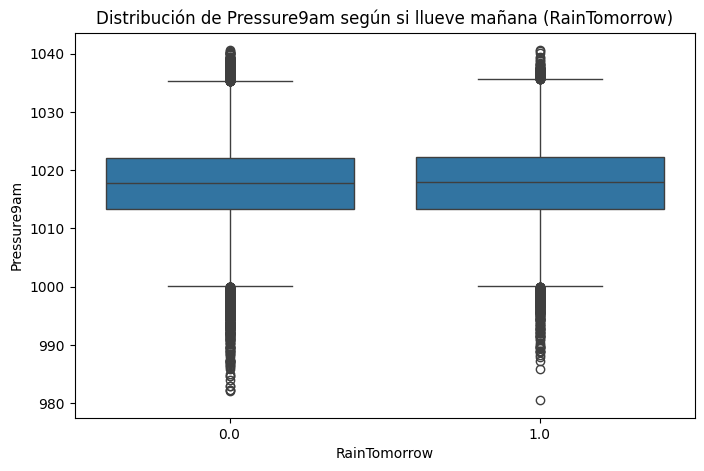

In [98]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Pressure9am', data=X_train)
plt.title('Distribución de Pressure9am según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Pressure9am')
plt.show()

#### Pressure3pm

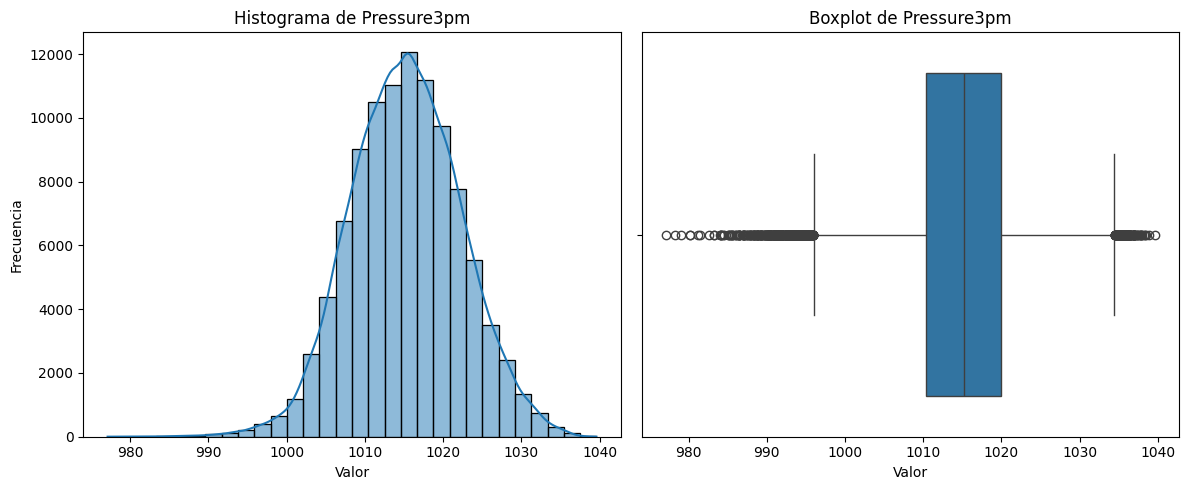



count    101830.000000
mean       1015.252713
std           7.037538
min         977.100000
25%        1010.400000
50%        1015.200000
75%        1020.000000
max        1039.600000
Name: Pressure3pm, dtype: float64
Cantidad de NaN:  9170


In [99]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Pressure3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Pressure3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Pressure3pm'], ax=axes[1])
axes[1].set_title('Boxplot de Pressure3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Pressure3pm'].describe())
print('Cantidad de NaN: ',X_train['Pressure3pm'].isna().sum())

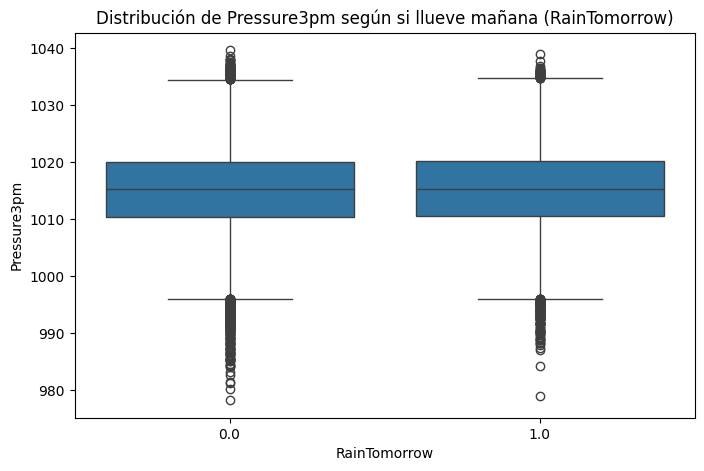

In [100]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Pressure3pm', data=X_train)
plt.title('Distribución de Pressure3pm según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Pressure3pm')
plt.show()

In [101]:
print('Se imputan datos NaN de Pressure3pm...\n')
medianas_Pressure3pm_train = X_train.groupby(['Location', 'Year', 'Month'])['Pressure3pm'].median().reset_index()
X_train = X_train.merge(medianas_Pressure3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Pressure3pm'] = X_train['Pressure3pm'].fillna(X_train['Pressure3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Pressure3pm: ', medianas_Pressure3pm_train[medianas_Pressure3pm_train['Pressure3pm'].isna()].shape[0])
print('Cantidad de NaN en Pressure3pm en el dataset X_train: ', X_train[X_train['Pressure3pm'].isna()].shape[0])

Se imputan datos NaN de Pressure3pm...

Cantidad de NaN en el dataset de medianas de Pressure3pm:  416
Cantidad de NaN en Pressure3pm en el dataset X_train:  8935


In [102]:
print('Se imputan datos NaN de Pressure3pm... \n')
medianas_Pressure3pm_train['Pressure3pm'] = medianas_Pressure3pm_train['Pressure3pm'].fillna(X_train.groupby(['Location', 'Month'])['Pressure3pm'].transform('median'))
X_train = X_train.drop(columns = 'Pressure3pm_mediana')
X_train = X_train.merge(medianas_Pressure3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Pressure3pm'] = X_train['Pressure3pm'].fillna(X_train['Pressure3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Pressure3pm: ', medianas_Pressure3pm_train[medianas_Pressure3pm_train['Pressure3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Pressure3pm'].isna()].shape[0])

Se imputan datos NaN de Pressure3pm... 

Cantidad de NaN en el dataset de medianas de Pressure3pm:  34
Cantidad de NaN en el dataset X_train:  784


In [103]:
print('Se imputan datos NaN de Pressure3pm... \n')
medianas_Pressure3pm_train['Pressure3pm'] = medianas_Pressure3pm_train['Pressure3pm'].fillna(X_train.groupby(['Location'])['Pressure3pm'].transform('median'))
X_train = X_train.drop(columns = 'Pressure3pm_mediana')
X_train = X_train.merge(medianas_Pressure3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
X_train['Pressure3pm'] = X_train['Pressure3pm'].fillna(X_train['Pressure3pm_mediana'])

print('Cantidad de NaN en el dataset de medianas de Pressure3pm: ', medianas_Pressure3pm_train[medianas_Pressure3pm_train['Pressure3pm'].isna()].shape[0])
print('Cantidad de NaN en el dataset X_train: ', X_train[X_train['Pressure3pm'].isna()].shape[0])

Se imputan datos NaN de Pressure3pm... 

Cantidad de NaN en el dataset de medianas de Pressure3pm:  0
Cantidad de NaN en el dataset X_train:  0


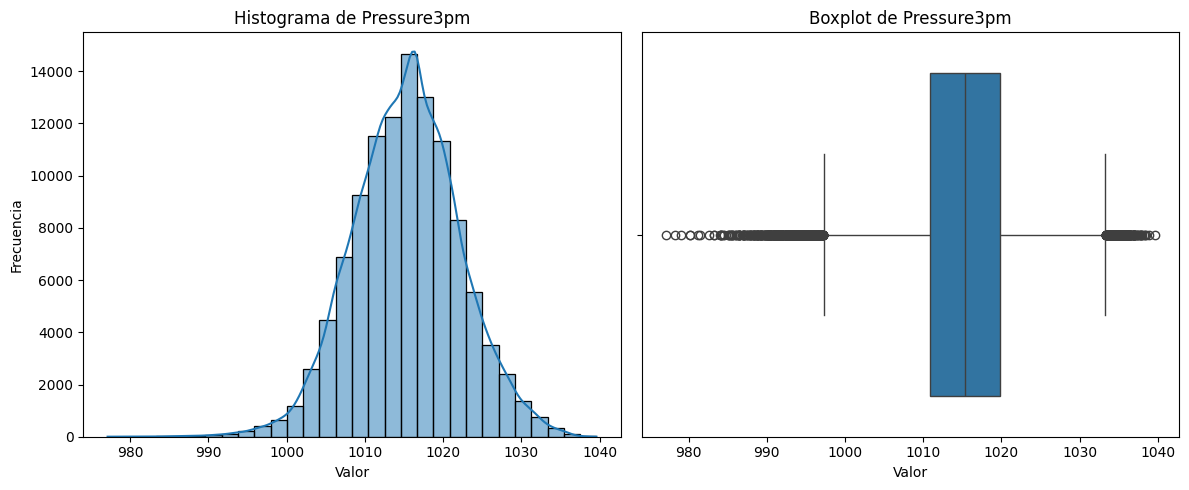



count    111000.000000
mean       1015.319069
std           6.808702
min         977.100000
25%        1010.800000
50%        1015.400000
75%        1019.800000
max        1039.600000
Name: Pressure3pm, dtype: float64
Cantidad de NaN:  0


In [104]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(X_train['Pressure3pm'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Pressure3pm')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=X_train['Pressure3pm'], ax=axes[1])
axes[1].set_title('Boxplot de Pressure3pm')
axes[1].set_xlabel('Valor')

plt.tight_layout()
plt.show()


print('\n')
print(X_train['Pressure3pm'].describe())
print('Cantidad de NaN: ',X_train['Pressure3pm'].isna().sum())

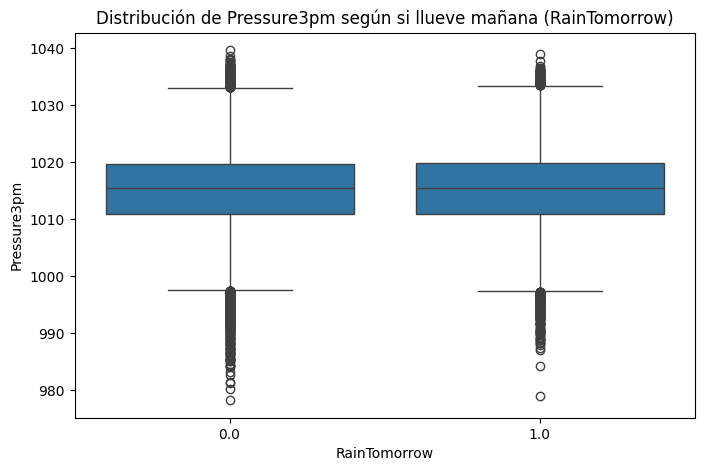

In [105]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y='Pressure3pm', data=X_train)
plt.title('Distribución de Pressure3pm según si llueve mañana (RainTomorrow)')
plt.xlabel('RainTomorrow')
plt.ylabel('Pressure3pm')
plt.show()

### RainToday

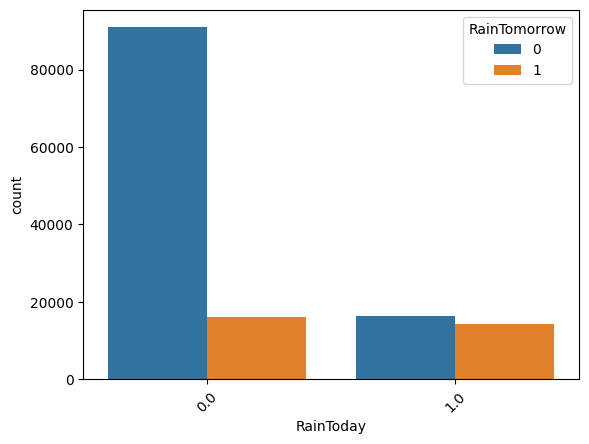


Cantidad de NaN en RainToday en el dataset X_train:  811


In [106]:
sns.countplot(data=df, x = 'RainToday', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en RainToday en el dataset X_train: ', X_train[X_train['RainToday'].isna()].shape[0])

In [107]:
print('Se imputan datos NaN de RainToday...\n')
medianas_RainToday_train = X_train.groupby(['Location', 'Year', 'Month'])['RainToday'].agg(lambda x: x.mode().iloc[0]).reset_index()
X_train = X_train.merge(medianas_RainToday_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_train['RainToday'] = X_train['RainToday'].fillna(X_train['RainToday_moda'])

print('Cantidad de NaN en el dataset de medianas de RainToday: ', medianas_RainToday_train[medianas_RainToday_train['RainToday'].isna()].shape[0])
print('Cantidad de NaN en PrRainTodayessure3pm en el dataset X_train: ', X_train[X_train['RainToday'].isna()].shape[0])

Se imputan datos NaN de RainToday...

Cantidad de NaN en el dataset de medianas de RainToday:  0
Cantidad de NaN en PrRainTodayessure3pm en el dataset X_train:  0


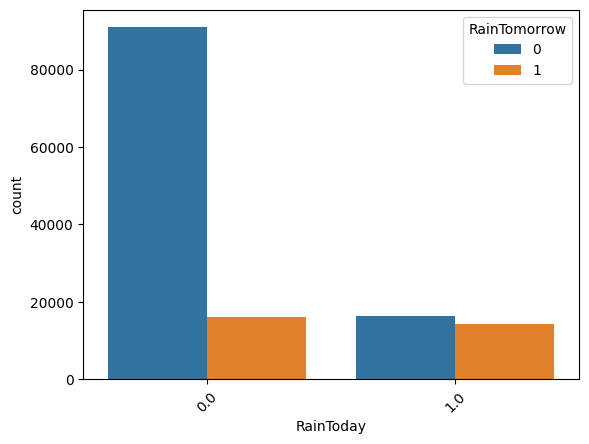


Cantidad de NaN en RainToday en el dataset X_train:  0


In [108]:
sns.countplot(data=df, x = 'RainToday', hue='RainTomorrow')
plt.xticks(rotation=45)
plt.show()

print('\nCantidad de NaN en RainToday en el dataset X_train: ', X_train[X_train['RainToday'].isna()].shape[0])

## Escalado

In [109]:
X_train.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Month', 'Year',
       'month_sin', 'month_cos', 'clim_zone', 'zona_2', 'zona_3', 'zona_4',
       'zona_5', 'zona_6', 'zona_7', 'zona_8', 'WindGustDir_moda',
       'WindDir9am_moda', 'WindDir3pm_moda', 'WindGustDir_grad',
       'WindDir9am_grad', 'WindDir3pm_grad', 'WindGustDir_rad',
       'WindDir9am_rad', 'WindDir3pm_rad', 'WindGustDir_sin',
       'WindGustDir_cos', 'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin',
       'WindDir3pm_cos', 'MinTemp_mediana', 'MaxTemp_mediana',
       'Temp9am_mediana', 'Temp3pm_mediana', 'WindGustSpeed_mediana',
       'WindSpeed9am_mediana', 'WindSpeed3pm_mediana', 'Humidity9am_mediana',
       'Humidity3pm_mediana', 'Pressure9am_mediana', 'Pressure3pm_mediana',
       'RainT

In [110]:
columnas_a_escalar = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',  'WindSpeed9am',
    'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
    'Pressure3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos',
    'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin', 'WindDir9am_cos',
    'WindDir3pm_sin', 'WindDir3pm_cos']

columnas_sin_escalar = [
    'zona_2', 'zona_3', 'zona_4','zona_5', 'zona_6', 'zona_7', 'zona_8','RainToday']


In [111]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[columnas_a_escalar])

columnas_escaladas = [col + '_escalada' for col in columnas_a_escalar]

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columnas_escaladas, index=X_train.index)

X_train = pd.concat([X_train, X_train_scaled_df], axis=1)

In [112]:
X_train[columnas_escaladas + columnas_sin_escalar].describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
MinTemp_escalada,111000.0,0.0000,1.0000,-3.2359,-0.7201,-0.0326,0.7331,3.3895
MaxTemp_escalada,111000.0,-0.0000,1.0000,-3.9529,-0.7560,-0.0800,0.7087,3.4971
Rainfall_escalada,111000.0,0.0000,1.0000,-0.2771,-0.2771,-0.2771,-0.2050,44.2734
WindGustSpeed_escalada,111000.0,0.0000,1.0000,-2.5406,-0.6658,-0.0659,0.4591,7.1333
WindSpeed9am_escalada,111000.0,-0.0000,1.0000,-1.5890,-0.7985,-0.1210,0.5566,8.2354
WindSpeed3pm_escalada,111000.0,0.0000,1.0000,-2.1337,-0.6493,0.0358,0.6068,7.3436
Humidity9am_escalada,111000.0,0.0000,1.0000,-3.5545,-0.6158,0.0664,0.7485,1.6406
Humidity3pm_escalada,111000.0,0.0000,1.0000,-2.4761,-0.7416,0.0293,0.6556,2.3419
Pressure9am_escalada,111000.0,0.0000,1.0000,-5.4118,-0.6423,0.0121,0.6519,3.3711
Pressure3pm_escalada,111000.0,-0.0000,1.0000,-5.6133,-0.6637,0.0119,0.6581,3.5662


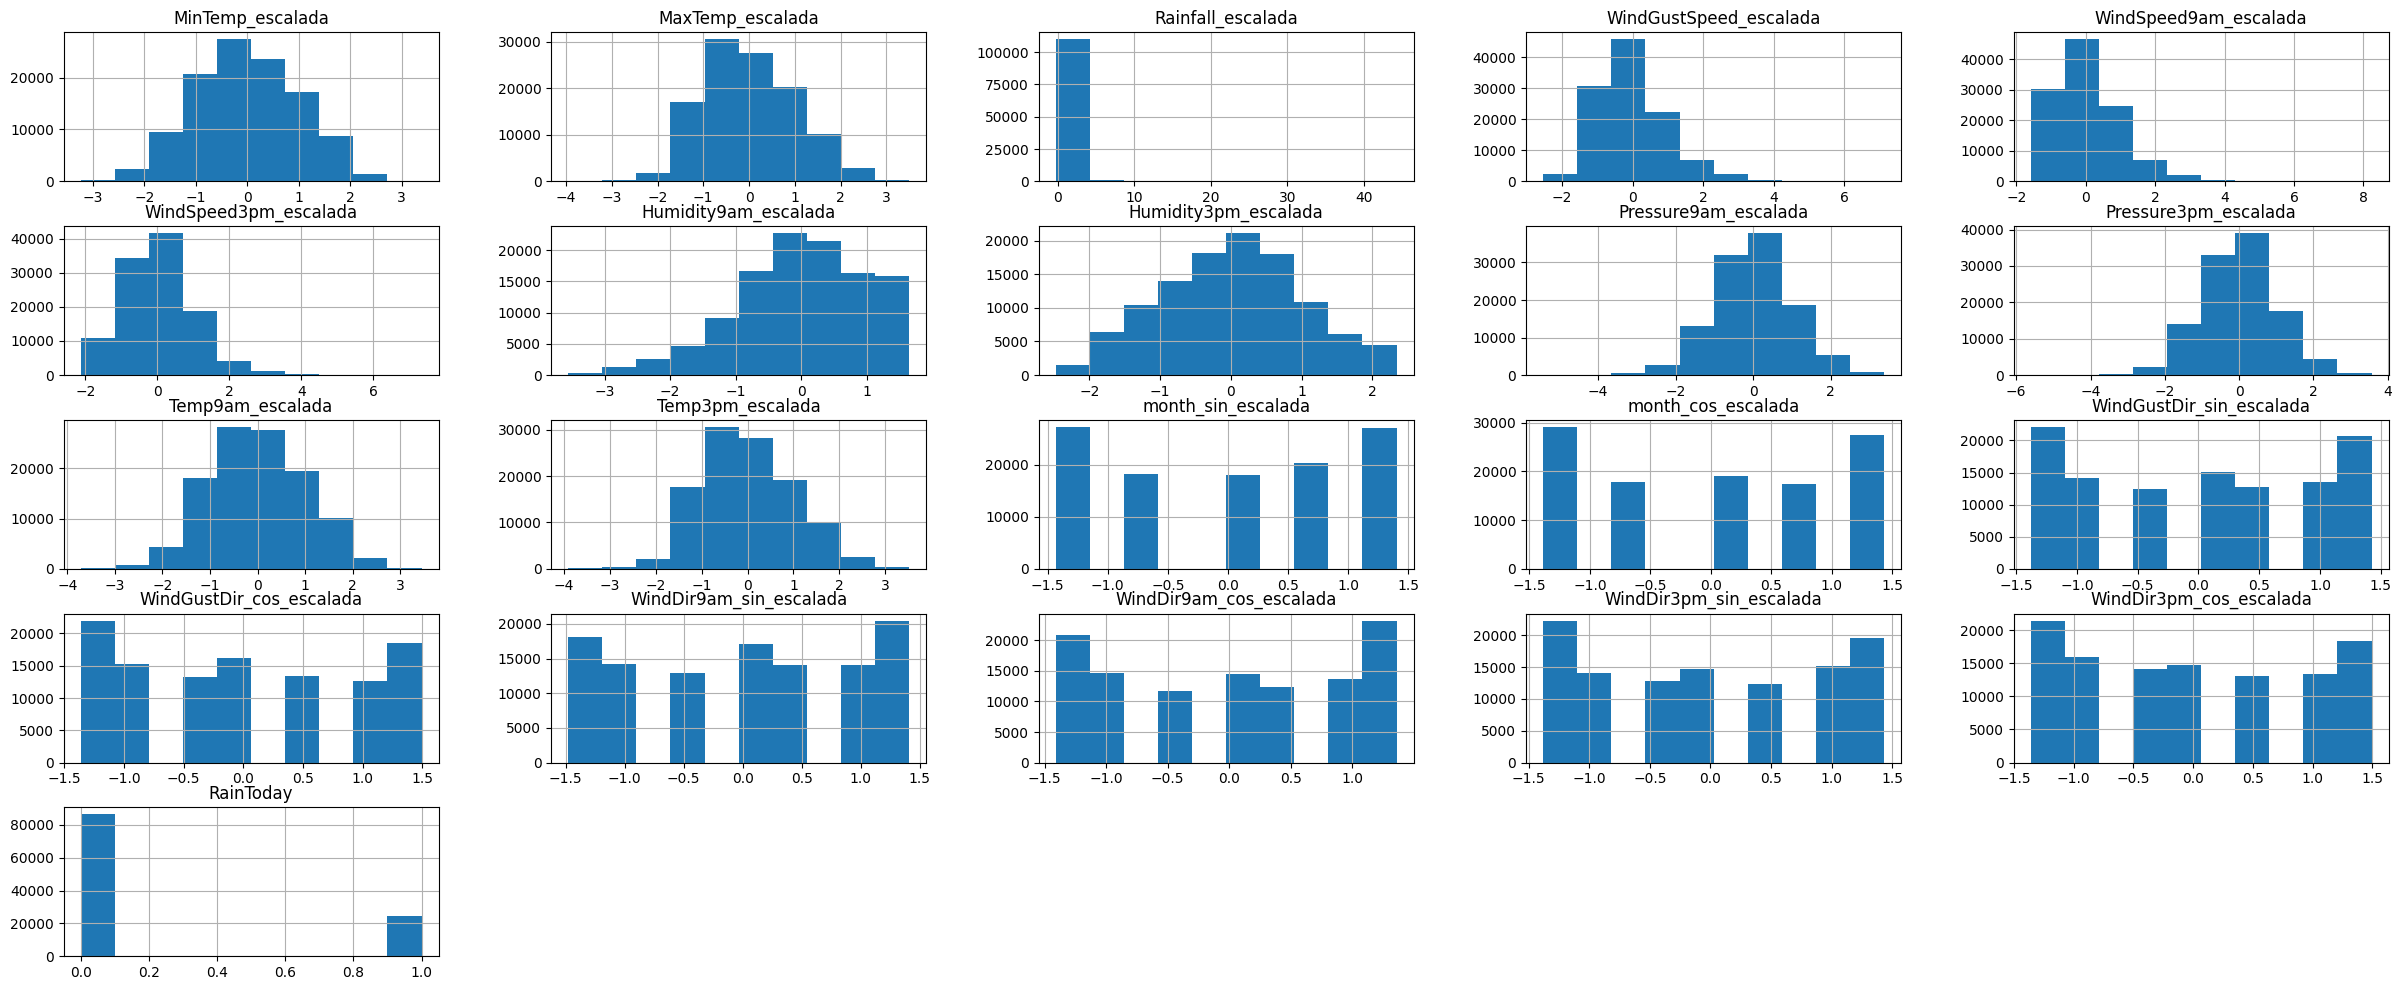

In [113]:
X_train[columnas_escaladas + columnas_sin_escalar].hist(figsize=(30,12))
plt.show()

## X_test

### Imputacion de variables cuantitativas

In [114]:
imputadores_dict = {
    'MinTemp'       :['medianas_MinTemp_train'      , medianas_MinTemp_train       ],
    'MaxTemp'       :['medianas_MaxTemp_train'      , medianas_MaxTemp_train       ],
    'WindGustSpeed' :['medianas_WindGustSpeed_train', medianas_WindGustSpeed_train ],
    'WindSpeed9am'  :['medianas_WindSpeed9am_train' , medianas_WindSpeed9am_train  ],
    'WindSpeed3pm'  :['medianas_WindSpeed3pm_train' , medianas_WindSpeed3pm_train  ],
    'Humidity9am'   :['medianas_Humidity9am_train'  , medianas_Humidity9am_train   ],
    'Humidity3pm'   :['medianas_Humidity3pm_train'  , medianas_Humidity3pm_train   ],
    'Pressure9am'   :['medianas_Pressure9am_train'  , medianas_Pressure9am_train   ],
    'Pressure3pm'   :['medianas_Pressure3pm_train'  , medianas_Pressure3pm_train   ],
    'Temp9am'       :['medianas_Temp9am_train'      , medianas_Temp9am_train       ],
    'Temp3pm'       :['medianas_Temp3pm_train'      , medianas_Temp3pm_train       ]
}

In [115]:
for col , imputador in imputadores_dict.items():
  print('Se esta usando el dataframe', imputador[0] ,'para crear la columna',col+'_mediana...')
  X_test = X_test.merge(imputador[1], on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_mediana'))
  print('Se van a imputar',X_test[X_test[col].isna()].shape[0],'valores faltantes')
  print('Se esta imputando los faltantes de la columna ',col, 'con la columna ',col+'_mediana','\n\n')
  X_test[col] = X_test[col].fillna(X_test[col+'_mediana'])
  print('Cantidad de valores NaN en ',col,':',X_test[X_test[col].isna()].shape[0])


Se esta usando el dataframe medianas_MinTemp_train para crear la columna MinTemp_mediana...
Se van a imputar 36 valores faltantes
Se esta imputando los faltantes de la columna  MinTemp con la columna  MinTemp_mediana 


Cantidad de valores NaN en  MinTemp : 0
Se esta usando el dataframe medianas_MaxTemp_train para crear la columna MaxTemp_mediana...
Se van a imputar 19 valores faltantes
Se esta imputando los faltantes de la columna  MaxTemp con la columna  MaxTemp_mediana 


Cantidad de valores NaN en  MaxTemp : 0
Se esta usando el dataframe medianas_WindGustSpeed_train para crear la columna WindGustSpeed_mediana...
Se van a imputar 1294 valores faltantes
Se esta imputando los faltantes de la columna  WindGustSpeed con la columna  WindGustSpeed_mediana 


Cantidad de valores NaN en  WindGustSpeed : 0
Se esta usando el dataframe medianas_WindSpeed9am_train para crear la columna WindSpeed9am_mediana...
Se van a imputar 32 valores faltantes
Se esta imputando los faltantes de la columna  W

In [116]:
X_test['Rainfall'] = X_test['Rainfall'].fillna(mediana_Rainfall_train)

### Imputacion de variables cualitativas

#### Imputacion

In [117]:
X_test = X_test.merge(modas_WindGustDir_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_test['WindGustDir'] = X_test['WindGustDir'].fillna(X_test['WindGustDir_moda'])

X_test = X_test.merge(modas_WindDir9am_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_test['WindDir9am'] = X_test['WindDir9am'].fillna(X_test['WindDir9am_moda'])

X_test = X_test.merge(modas_WindDir3pm_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_test['WindDir3pm'] = X_test['WindDir3pm'].fillna(X_test['WindDir3pm_moda'])

#medianas_RainToday_train dice medianas pero son modas
X_test = X_test.merge(medianas_RainToday_train, on=['Location', 'Year', 'Month'], how='left', suffixes=('', '_moda'))
X_test['RainToday'] = X_test['RainToday'].fillna(X_test['RainToday_moda'])

#### Transformacion

In [118]:
#Seteo grados a cada direccion
puntos_cardinales = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

X_test['WindGustDir_grad'] = X_test['WindGustDir'].map(puntos_cardinales)
X_test['WindDir9am_grad'] = X_test['WindDir9am'].map(puntos_cardinales)
X_test['WindDir3pm_grad'] = X_test['WindDir3pm'].map(puntos_cardinales)

# Convertimos los grados a radianes
X_test['WindGustDir_rad'] = np.deg2rad(X_test['WindGustDir_grad'])
X_test['WindDir9am_rad'] = np.deg2rad(X_test['WindDir9am_grad'])
X_test['WindDir3pm_rad'] = np.deg2rad(X_test['WindDir3pm_grad'])

# Creamos las variables cíclicas
X_test['WindGustDir_sin'] = np.sin(X_test['WindGustDir_rad']).round(5)
X_test['WindGustDir_cos'] = np.cos(X_test['WindGustDir_rad']).round(5)

X_test['WindDir9am_sin'] = np.sin(X_test['WindDir9am_rad']).round(5)
X_test['WindDir9am_cos'] = np.cos(X_test['WindDir9am_rad']).round(5)

X_test['WindDir3pm_sin'] = np.sin(X_test['WindDir3pm_rad']).round(5)
X_test['WindDir3pm_cos'] = np.cos(X_test['WindDir3pm_rad']).round(5)

#### Elimina columnas de X_test

In [119]:
X_test = X_test[columnas_a_escalar + columnas_sin_escalar]

#### Escalado

In [120]:
#scaler creado en train
#columnas_a_escalar: lista de columnas. Creada en train
#columnas_escaladas: lista de columnas escaladas. Creada en train

X_test_scaled = scaler.transform(X_test[columnas_a_escalar])

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columnas_escaladas, index=X_test.index)

X_test = pd.concat([X_test, X_test_scaled_df], axis=1)

In [121]:
X_test[columnas_escaladas + columnas_sin_escalar].describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
MinTemp_escalada,27750.0,0.0033,0.9996,-3.1890,-0.7045,-0.0326,0.7331,3.0769
MaxTemp_escalada,27750.0,0.0091,0.9967,-3.7275,-0.7419,-0.0659,0.7227,3.3845
Rainfall_escalada,27750.0,0.0029,1.0236,-0.2771,-0.2771,-0.2771,-0.2050,43.8651
WindGustSpeed_escalada,27750.0,-0.0026,0.9907,-2.4656,-0.6658,-0.0659,0.4591,6.1584
WindSpeed9am_escalada,27750.0,-0.0071,0.9880,-1.5890,-0.7985,-0.1210,0.5566,6.5416
WindSpeed3pm_escalada,27750.0,-0.0004,1.0005,-2.1337,-0.6493,0.0358,0.6068,7.8003
Humidity9am_escalada,27750.0,0.0003,1.0040,-3.6070,-0.6158,0.0664,0.7485,1.6406
Humidity3pm_escalada,27750.0,-0.0106,0.9970,-2.4761,-0.7416,0.0293,0.6556,2.3419
Pressure9am_escalada,27750.0,0.0031,0.9950,-4.9465,-0.6278,0.0266,0.6373,3.3856
Pressure3pm_escalada,27750.0,0.0019,0.9998,-4.9083,-0.6637,0.0266,0.6508,3.3165


In [122]:
X_test = X_test[columnas_escaladas + columnas_sin_escalar]
X_test

,MinTemp_escalada,MaxTemp_escalada,Rainfall_escalada,WindGustSpeed_escalada,WindSpeed9am_escalada,WindSpeed3pm_escalada,Humidity9am_escalada,Humidity3pm_escalada,Pressure9am_escalada,Pressure3pm_escalada,Temp9am_escalada,Temp3pm_escalada,month_sin_escalada,month_cos_escalada,WindGustDir_sin_escalada,WindGustDir_cos_escalada,WindDir9am_sin_escalada,WindDir9am_cos_escalada,WindDir3pm_sin_escalada,WindDir3pm_cos_escalada,zona_2,zona_3,zona_4,zona_5,zona_6,zona_7,zona_8,RainToday
0,1.061217,-0.389826,0.443437,-0.215860,0.104859,-0.420900,1.063397,2.052824,-0.453259,0.232194,0.324171,-0.635444,-0.015038,1.434317,0.558580,-1.255380,1.300984,0.505809,0.025548,-1.359956,False,False,False,False,True,False,False,1.0
1,0.545568,0.300248,-0.277055,0.459064,0.330708,0.606753,-0.143551,-0.163445,0.186554,0.276255,0.031951,0.244116,1.403449,0.023790,1.013581,-0.945470,1.300984,-0.554958,1.019407,-0.942087,False,False,False,False,True,False,False,0.0
2,-1.407649,-1.713640,-0.277055,2.408844,4.057214,2.547877,1.325777,1.426487,1.073568,0.643434,-1.705990,-1.543842,-0.724282,-1.197769,0.021886,1.495134,-0.034569,1.361396,0.025548,1.493462,False,False,False,False,False,True,False,0.0
3,0.936211,0.455163,0.155240,-0.365843,-1.589007,-1.334370,0.643589,0.751971,-0.482341,-0.516851,0.693291,0.445982,-0.724282,1.245349,1.317593,0.612570,0.987623,-1.004609,1.019407,-0.942087,False,False,False,True,False,False,False,1.0
4,0.795580,1.539564,-0.277055,-0.740801,-0.572687,-0.649268,-1.927735,-1.319758,-0.642294,-0.884030,1.339252,1.585084,0.694206,1.245349,0.021886,1.495134,0.518630,1.255896,-1.379976,0.066753,False,False,False,True,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27745,1.170597,0.553745,-0.277055,0.609047,1.121179,0.835121,-0.773263,-0.018905,-0.976742,-0.942779,1.000891,0.489239,-0.015038,1.434317,1.013581,-0.945470,1.411022,-0.024575,1.019407,-0.942087,False,False,False,True,False,False,False,0.0
27746,-0.610737,-1.600975,0.251305,0.909013,-0.572687,0.035835,1.063397,1.281948,-1.631096,-1.486203,-1.121549,-1.861060,-0.724282,-1.197769,-0.514808,1.386308,-0.034569,1.361396,-1.272988,0.612726,False,False,True,False,False,False,False,1.0
27747,-0.516982,0.441079,-0.277055,-0.740801,-1.589007,-0.877635,0.171305,-0.934320,0.099307,0.144071,-0.552489,0.518077,1.403449,0.023790,-1.273820,-0.481642,0.987623,-1.004609,-1.272988,-0.479220,False,False,True,False,False,False,False,0.0
27748,1.186223,0.694576,-0.253039,0.309081,-0.346838,0.035835,0.276257,0.703791,-0.424176,-0.443415,1.246971,0.647848,-0.015038,1.434317,0.558580,1.386308,1.300984,-0.554958,1.019407,1.075593,True,False,False,False,False,False,False,0.0


## Balanceo

In [123]:
X_train = X_train[columnas_escaladas + columnas_sin_escalar]

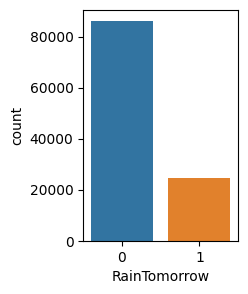

RainTomorrow
0    86225
1    24775
Name: count, dtype: int64


In [124]:
colores = ["lightpink","lightgreen"]
plt.figure(figsize=(2, 3))
sns.countplot(x=y_train, hue=y_train, legend=False)
plt.show()

print(y_train.value_counts())


In [125]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

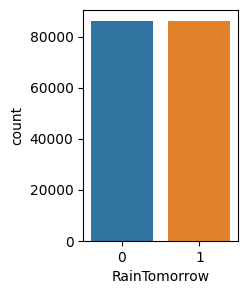

RainTomorrow
0    86225
1    24775
Name: count, dtype: int64


In [126]:
colores = ["lightpink","lightgreen"]
plt.figure(figsize=(2, 3))
sns.countplot(x=y_train_bal, hue=y_train_bal, legend=False)
plt.show()

print(y_train.value_counts())

## Modelo de Regresion Logistica

### Sin balancear

In [127]:
# Modelo de regresión logística
model = LogisticRegression(random_state=42)

# Entrenamiento
model.fit(X_train, y_train)

# Obtener las probabilidades predichas
y_prob = model.predict_proba(X_test)[:, 1]

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [128]:
# Calcular el ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

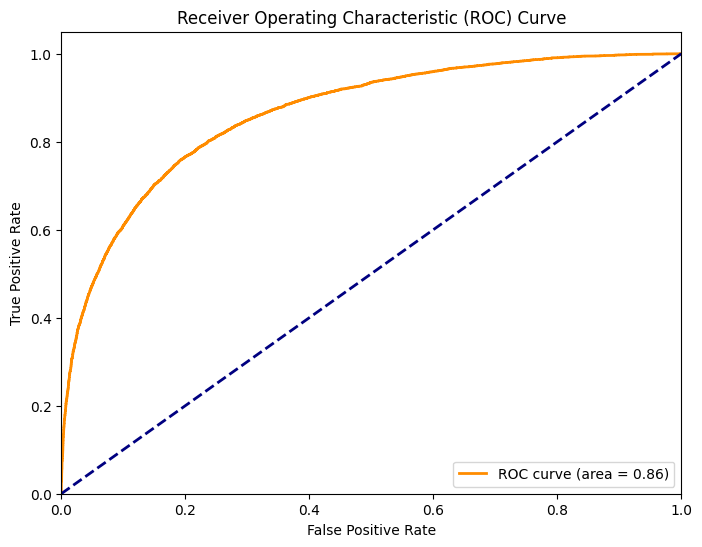

In [129]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [130]:
# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print('Metricas con umbral de 0.5: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas con umbral de 0.5: 
Accuracy: 0.8448
Precision: 0.7246
Recall: 0.4809
F1-Score: 0.5781


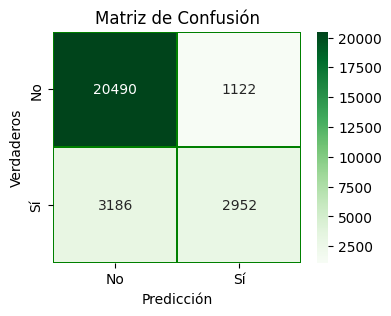

In [131]:
# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", linewidths=0.1, linecolor='green', cbar=True)
plt.xlabel('Predicción')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.show()

In [132]:
# Umbral personalizado
custom_threshold = 0.2
y_pred_custom = (y_prob >= custom_threshold).astype(int)

# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

# Imprimir las métricas
print('Metricas con umbral de: ',custom_threshold)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas con umbral de:  0.2
Accuracy: 0.7746
Precision: 0.4941
Recall: 0.7941
F1-Score: 0.6092


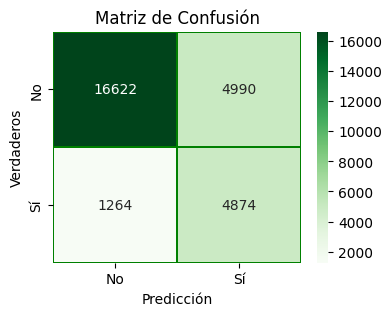

In [133]:
# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", linewidths=0.1, linecolor='green', cbar=True)
plt.xlabel('Predicción')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.show()

Si bien calculamos varias metricas, decidimos utilizar el recall como metrica unica para tomar decisiones. El recall mide qué porcentaje de los días que efectivamente llueven son correctamente identificados como tales por nuestro modelo. Consideramos que es una medida correcta para este contexto ya que es importante disminuir los falsos negativos. Si el modelo dice que no va a llover, pero luego llueve, entendemos que es muy costoso para la gente, cuestiones logisticas (transporte de cargas, viajes aereos, etc), accidentes, decisiones que deben tomar las personas relacionadas con la agro, etc. En cambio, si el modelo dice que al otro dia va a llover pero luego no llueve, consideramos que los daños serian menores en comparacion con la anterior situacion.

Vemos que el modelo sin balancear tiene un recall bajo (0,48). Bajando el umbral a 0,2 logramos subir el recall a 0,79.

### Balanceado - class_weight='balanced'

In [134]:
# Modelo de regresión logística
model = LogisticRegression(random_state=42, class_weight='balanced')

# Entrenamiento
model.fit(X_train, y_train)

# Obtener las probabilidades predichas
y_prob = model.predict_proba(X_test)[:, 1]

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [135]:
# Calcular el ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

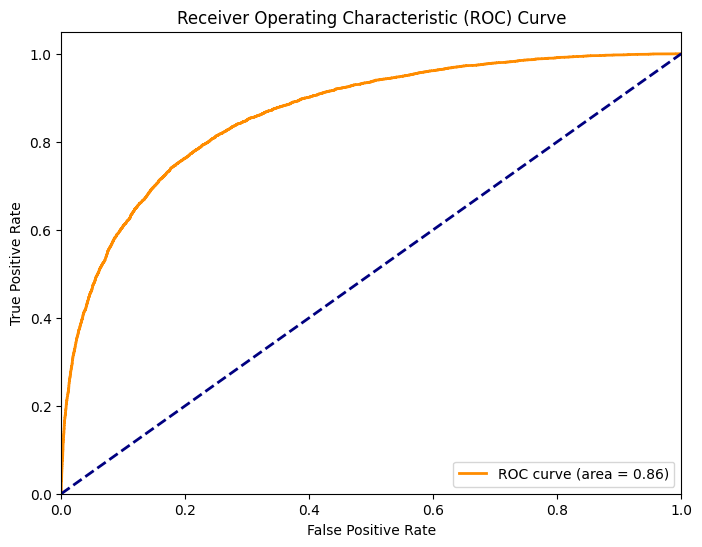

In [136]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [137]:
# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print('Metricas: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas: 
Accuracy: 0.7889
Precision: 0.5153
Recall: 0.7680
F1-Score: 0.6168


El area de la curva ROC no varia si balanceamos con class_weight='balanced'. Obtenemos un mejor recall (0,79 vs 0,48) que el modelo sin balancear con mismo umbral de 0,5.

### Balanceado - SMOTE

In [138]:
# Modelo de regresión logística
model = LogisticRegression(random_state=42)

# Entrenamiento
model.fit(X_train_bal, y_train_bal)

# Obtener las probabilidades predichas
y_prob = model.predict_proba(X_test)[:, 1]

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [139]:
np.set_printoptions(suppress=True, precision=6)
print('Parametros: \n',np.round(model.coef_, 6))

Parametros: 
 [[ 0.396742 -0.40694   0.089192  0.675053 -0.031942 -0.195282  0.176217
   1.371968  1.117637 -1.5817    0.431134  0.175237 -0.220205 -0.338781
  -0.006009 -0.070407  0.001229  0.029836 -0.1087    0.128553  1.387313
   1.629012  2.094441  1.862272  2.08161   2.007191  1.111928  0.472995]]


In [140]:
# Calcular el ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

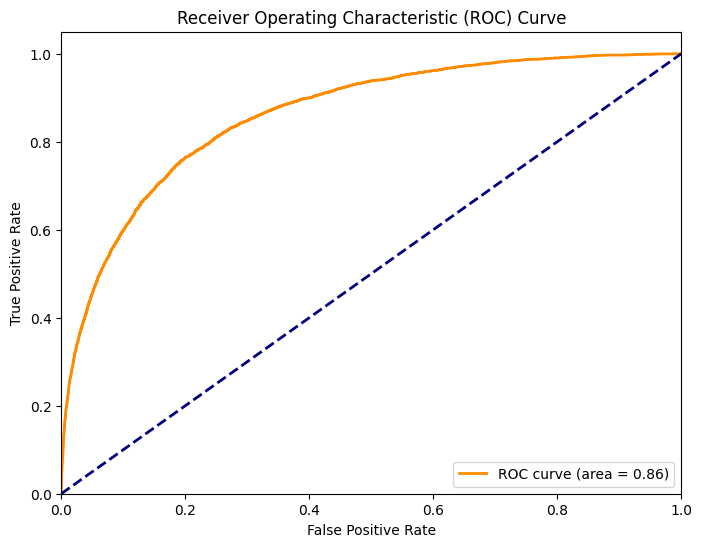

In [141]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [142]:
# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print('Metricas con umbral de 0,5: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas con umbral de 0,5: 
Accuracy: 0.7946
Precision: 0.5248
Recall: 0.7569
F1-Score: 0.6198


Este modelo se entrena con datos balanceados por el metodo SMOTE. El area de la curva ROC no varia con respecto al modelo entrenado con datos sin balancear y datos balanceados con el metodo class_weight='balanced'. Para un umbral de 0,5 se obtiene practicamente el mismo recall que con el modelo balanceado por el metodo anterior.

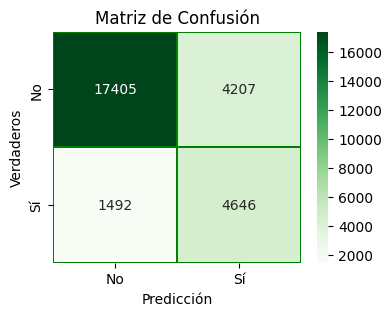

In [143]:
# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", linewidths=0.1, linecolor='green', cbar=True)
plt.xlabel('Predicción')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.show()

In [144]:
# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print('Metricas con umbral de 0,5: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas con umbral de 0,5: 
Accuracy: 0.7946
Precision: 0.5248
Recall: 0.7569
F1-Score: 0.6198


In [145]:
print('Testeo de diferentes umbrales: \n')
umbrales = [0.15,0.20,0.25,0.27,0.30,0.35,0.4,0.45]
for custom_threshold in umbrales:
  y_pred_custom = (y_prob >= custom_threshold).astype(int)

  # Calcular métricas de evaluación del modelo
  accuracy = accuracy_score(y_test, y_pred_custom)
  precision = precision_score(y_test, y_pred_custom)
  recall = recall_score(y_test, y_pred_custom)
  f1 = f1_score(y_test, y_pred_custom)

  # Imprimir las métricas
  print('Metricas con umbral de: ',custom_threshold)
  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-Score: {f1:.4f}')
  print('\n')


Testeo de diferentes umbrales: 

Metricas con umbral de:  0.15
Accuracy: 0.5188
Precision: 0.3104
Recall: 0.9622
F1-Score: 0.4694


Metricas con umbral de:  0.2
Accuracy: 0.5896
Precision: 0.3436
Recall: 0.9399
F1-Score: 0.5032


Metricas con umbral de:  0.25
Accuracy: 0.6415
Precision: 0.3733
Recall: 0.9143
F1-Score: 0.5301


Metricas con umbral de:  0.27
Accuracy: 0.6607
Precision: 0.3859
Recall: 0.9034
F1-Score: 0.5408


Metricas con umbral de:  0.3
Accuracy: 0.6869
Precision: 0.4053
Recall: 0.8886
F1-Score: 0.5566


Metricas con umbral de:  0.35
Accuracy: 0.7227
Precision: 0.4356
Recall: 0.8583
F1-Score: 0.5779


Metricas con umbral de:  0.4
Accuracy: 0.7523
Precision: 0.4662
Recall: 0.8271
F1-Score: 0.5963


Metricas con umbral de:  0.45
Accuracy: 0.7746
Precision: 0.4940
Recall: 0.7884
F1-Score: 0.6074




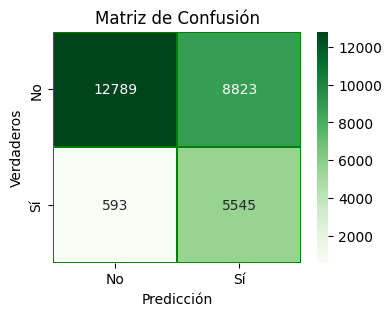

In [146]:
# Calcular la matriz de confusión
custom_threshold = 0.27
y_pred_custom = (y_prob >= custom_threshold).astype(int)

confusion_mat = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", linewidths=0.1, linecolor='green', cbar=True)
plt.xlabel('Predicción')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.show()

Si consideramos que el modelo va a ser utilizado por usuarios que deben anticiparse a eventos climáticos importantes, una buena configuracion seria bajar el umbral a un valor cercano a 0,27. Esto nos da una mejora de nuestro recall de 0,75 a 0,90. Nuestros falsos positivos aumentarian de 4207 a 8823 (casi el doble) pero es un costo que estamos dispuestos a pagar por mejorar nuestro recall.

Si nuestro modelo va a ser utilizado por usuarios que toman decisiones personales no tan criticas, podriamos optar por un umbral de entre 0,4 y 0,5. Nuestro recall seria mas bajo pero reduciriamos la cantidad de falsas alarmas (falsos positivos).

## Modelo Base

DummyClassifier con estrategia "stratified".
Genera predicciones aleatorias según la proporción real de clases en y_train.

In [182]:
base = DummyClassifier(strategy='stratified', random_state=42) #most_frequent stratified
base.fit(X_train, y_train)
y_pred_base = base.predict(X_test)

In [183]:
# Obtener las probabilidades predichas
y_prob_base = base.predict_proba(X_test)[:, 1]

In [184]:
# Calcular el ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_base)
roc_auc = auc(fpr, tpr)

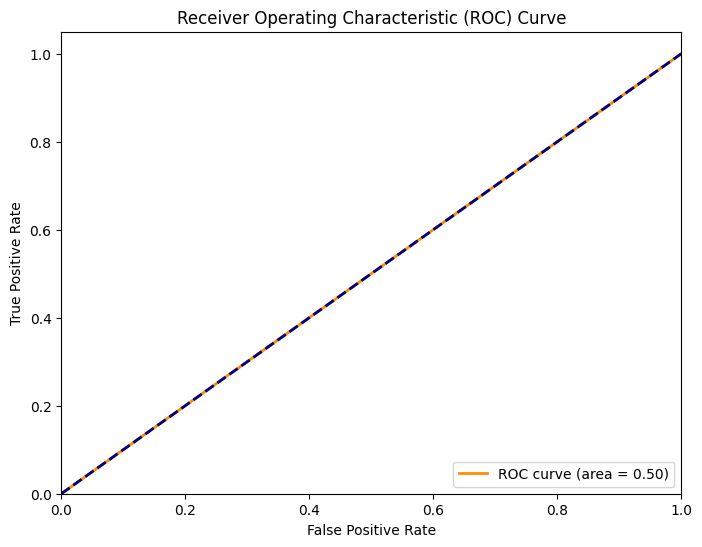

In [185]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [186]:
# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base)
recall = recall_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

# Imprimir las métricas
print('Metricas con umbral de 0.5: ')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas con umbral de 0.5: 
Accuracy: 0.6547
Precision: 0.2214
Recall: 0.2229
F1-Score: 0.2221


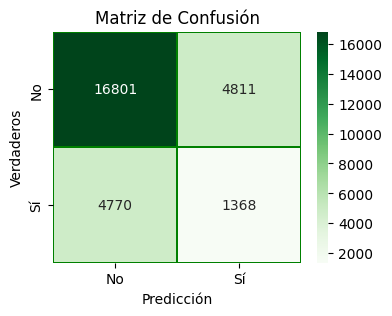

In [187]:
# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", linewidths=0.1, linecolor='green', cbar=True)
plt.xlabel('Predicción')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
plt.show()

Por mas que cambiemos el umbral, segun curva ROC = 0.5, las metricas no deberian cambiar.

In [188]:
# Umbral personalizado
custom_threshold_base = 0.2
y_pred_custom_base = (y_prob_base >= custom_threshold_base).astype(int)

# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred_custom_base)
precision = precision_score(y_test, y_pred_custom_base)
recall = recall_score(y_test, y_pred_custom_base)
f1 = f1_score(y_test, y_pred_custom_base)

# Imprimir las métricas
print('Metricas con umbral de: ',custom_threshold_base)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Metricas con umbral de:  0.2
Accuracy: 0.6547
Precision: 0.2214
Recall: 0.2229
F1-Score: 0.2221


Nuestro modelo original de regresion logistica tiene las sigueintes metricas:

* Accuracy: 0.7746
* Precision: 0.4941
* Recall: 0.7941
* F1-Score: 0.6092

El modelo base creado no es muy exigente, el valor de curva ROC = 0.5 nos indica que basicamente simula el azar. El modelo base tiene un recall mas bajo. Puede que el modelo base no sea muy exigente, pero es válido ya que nos da una referencia mínima: cualquier modelo con performance inferior o igual se lo puede considerar malo.

## Optimizacion de hiperparametros

Se decide variar los valores para los siguientes hiperparametros:
* penalty: indica el tipo de regularizacion que se esta utilizando.
* C: inverso del alpha de la regularización. Cuanto menor, más regularización. Cuanto mayor, menos regularización.
* solver: algoritmo de optimización que usa LogisticRegression. No todos son soportados por todos los tipos de regularizacion. Se eligieron valores que representan algoritmos soportados tanto por L1 y L2.

In [ ]:
# Definimos el modelo
model = LogisticRegression(random_state=42, max_iter=1000)

# Grid de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'recall',
    n_jobs = -1,
    error_score = 'raise'
)

# Entrenamiento con los datos balanceados
grid_search.fit(X_train_bal, y_train_bal)

# Resultados
print("Mejores parámetros (GridSearch):", grid_search.best_params_)
print("Mejor score (GridSearch):", grid_search.best_score_)

# Evaluamos sobre test
best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)
print("\nRecall en test:", recall_score(y_test, y_pred))

Mejores parámetros (GridSearch): {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score (GridSearch): 0.7786720788634388

Recall en test: 0.7577386770935158


Mejores parámetros (GridSearch): {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

El recall en test  de 0.7577 indica que no hay una mejora optimizando los parametros.

Se vuelve a correr GridSearchCV variando los valores de C alrededor del mejor valor detectado dentro de las opciones dadas anteriormente para detectar si se puede mejorar el modelo.

In [ ]:
# Definimos el modelo
model = LogisticRegression(random_state=42, max_iter=1000)

# Grid de hiperparámetros
param_grid = {
    'C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.3, 0.4, 0.5],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Evitamos combinaciones inválidas automáticamente con error_score='raise'
grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'recall',
    n_jobs = -1,
    error_score = 'raise'
)

# Entrenamiento con los datos balanceados
grid_search.fit(X_train_bal, y_train_bal)

# Resultados
print("Mejores parámetros (GridSearch):", grid_search.best_params_)
print("Mejor score (GridSearch):", grid_search.best_score_)

# Evaluamos sobre test
best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)
print("\nRecall en test:", recall_score(y_test, y_pred))

No se logra mejorar el recall pero el C optimo resulta ser uno de los valores extremos de nuestra lista. Se decide hacer un RandomSearch con una lista mas amplia de valores que tengan como centro el valor 0.05

In [ ]:
# Definimos el modelo
model = LogisticRegression(random_state=42, max_iter=1000)

# Grid de hiperparámetros
param_distributions = {
    'C': list(np.linspace(0.01, 0.1, 20)),  # Valores alrededor de 0.05
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# RandomizedSearchCV usa param_distributions
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,  # Elegí cuántas combinaciones querés probar (podés subirlo)
    cv=5,
    scoring='recall',
    n_jobs=-1,
    error_score='raise',
    random_state=42
)

# Entrenamiento con los datos balanceados
grid_search.fit(X_train_bal, y_train_bal)

# Resultados
print("Mejores parámetros (RandomizedSearch):", grid_search.best_params_)
print("Mejor score (RandomizedSearch):", grid_search.best_score_)

# Evaluamos sobre test
best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print("\nRecall en test:", recall_score(y_test, y_pred))

El recall sigue sin mejorar de manera significativa. El C optimo vuelve a caer en uno de los extremos de nuestra lista. Se decide volver a probar con un RandomSearch con valores menores a 0.01

In [ ]:
# Definimos el modelo
model = LogisticRegression(random_state=42, max_iter=1000)

# Grid de hiperparámetros
param_distributions = {
    'C': list(np.linspace(0.001, 0.01, 20)),  # Valores alrededor de 0.05
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# RandomizedSearchCV usa param_distributions
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,  # Elegí cuántas combinaciones querés probar (podés subirlo)
    cv=5,
    scoring='recall',
    n_jobs=-1,
    error_score='raise',
    random_state=42
)

# Entrenamiento con los datos balanceados
random_search.fit(X_train_bal, y_train_bal)

# Resultados
print("Mejores parámetros (RandomizedSearch):", random_search.best_params_)
print("Mejor score (RandomizedSearch):", random_search.best_score_)

# Evaluamos sobre test
best_model = random_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print("\nRecall en test:", recall_score(y_test, y_pred))

Finalmente no se logra mejorar significativamente el recall del modelo original (0.756 vs 0.759)

Dado que parece haber una mejora en valores bajos de C, se decide probar con Optuna para un conjunto de valores bajos de C y comprobar si se logra un modelo con una mejor metrica.

Como valores bajos de C indican alta regularizacion, se decide probar solo con Ridge ya que, en pruebas anteriores, Lasso llevaba al extremo la regularizacion y convertia en cero todos los Beta del modelo.

Al probar solo con Ridge, se agrega un valor nuevo para el hiperparametro Solver. Dicho valor representa un algoritmo que solo es compatible con Ridge.

Dado que Optuna corre bastante rapido, se prueban 100 combinaciones distintas.

In [ ]:
def objective(trial):
    # Hiperparámetros a optimizar
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        random_state=42,
        max_iter=1000
    )

    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_test)
    recall = recall_score(y_test, preds, average='binary')  # Para problemas binarios

    return 1.0 - recall  # Minimizar (Optuna minimiza por defecto)

# Ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Entrenar modelo final con mejores hiperparámetros
best_params = study.best_params
best_model = LogisticRegression(**best_params, random_state=42, max_iter=1000)
best_model.fit(X_train_bal, y_train_bal)
final_preds = best_model.predict(X_test)
final_proba = best_model.predict_proba(X_test)[:, 1]  # Para ROC AUC

# Calcular métricas
final_recall = recall_score(y_test, final_preds)
final_precision = precision_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds)
final_accuracy = accuracy_score(y_test, final_preds)
final_roc_auc = roc_auc_score(y_test, final_proba)

print("\nMejores parámetros encontrados:", best_params)
print("Metricas en test:")
print(f"  Recall     : {final_recall:.4f}")
print(f"  Precision  : {final_precision:.4f}")
print(f"  F1-score   : {final_f1:.4f}")
print(f"  Accuracy   : {final_accuracy:.4f}")
print(f"  ROC AUC    : {final_roc_auc:.4f}")

[I 2025-06-01 17:46:06,511] A new study created in memory with name: no-name-4d6d2063-8bf9-45ef-bc8f-5fe1f0068199
[I 2025-06-01 17:46:22,324] Trial 0 finished with value: 0.24275008145975885 and parameters: {'C': 1.1952860820570963, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.24275008145975885.
[I 2025-06-01 17:46:23,594] Trial 1 finished with value: 0.21717171717171713 and parameters: {'C': 0.00014016993900622132, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.21717171717171713.
[I 2025-06-01 17:46:24,382] Trial 2 finished with value: 0.2375366568914956 and parameters: {'C': 0.00012880662297177201, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.21717171717171713.
[I 2025-06-01 17:46:27,955] Trial 3 finished with value: 0.24242424242424243 and parameters: {'C': 0.40600547854525854, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.21717171717171713.
[I 2025-06-01 17:46:31,254] Trial 4 finished with v


Mejores parámetros encontrados: {'C': 1.0095693959774445e-05, 'penalty': 'l2', 'solver': 'liblinear'}
Metricas en test:
  Recall     : 0.8218
  Precision  : 0.4288
  F1-score   : 0.5635
  Accuracy   : 0.7185
  ROC AUC    : 0.8391


In [ ]:
# Modelo de regresión logística
model = LogisticRegression(random_state=42)

# Entrenamiento
model.fit(X_train_bal, y_train_bal)

# Obtener las probabilidades predichas
y_prob = model.predict_proba(X_test)[:, 1]

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Se observa que Optuna nos marca como mejores parametros un C = 1.0095693959774445e-05, un valor muy cercano a uno de los extremos seteados en el conjunto de valores de C a probar. Esto nos indica que el modelo encuentra un mejor recall cuando se le aplica un gran nivel de regularizacion.

Comparemos los valores de los parametros entre nuestro modelo original y el propuesto por Optuna:

In [ ]:
print('Valores de parametros - Modelo Optuna: \n')
print(np.round(best_model.coef_, 6))

print('\nValores de parametros - Modelo original: \n')
np.set_printoptions(suppress=True, precision=6)
print(np.round(model.coef_, 6))

Valores de parametros - Modelo Optuna: 

[[ 0.069439 -0.063073  0.093317  0.110459  0.031217  0.022258  0.126324
   0.247043 -0.103419 -0.102979  0.011436 -0.080498 -0.006931 -0.023272
  -0.024189  0.019023 -0.026915  0.042431 -0.01485   0.032168  0.006862
  -0.005247 -0.016613  0.006232  0.004304 -0.00736  -0.002149  0.052614]]

Valores de parametros - Modelo original: 

[[ 0.396742 -0.40694   0.089192  0.675053 -0.031942 -0.195282  0.176217
   1.371968  1.117637 -1.5817    0.431134  0.175237 -0.220205 -0.338781
  -0.006009 -0.070407  0.001229  0.029836 -0.1087    0.128553  1.387313
   1.629012  2.094441  1.862272  2.08161   2.007191  1.111928  0.472995]]


En corridas pasadas, al ultilziar Lasso para valores de C similares, los coeficientes se convertian todos en cero. En este caso, en general, se ve una disminucion de los valores de los coeficientes.

Comparamos las metricas:

In [ ]:
print("Metricas en test - Optuna:")
print(f"Recall    : {final_recall:.4f}")
print(f"Precision : {final_precision:.4f}")
print(f"F1-score  : {final_f1:.4f}")
print(f"Accuracy  : {final_accuracy:.4f}")
print('\n')
print('Metricas en test - Modelo original: ')
print(f'Recall    : {recall:.4f}')
print(f'Precision : {precision:.4f}')
print(f'F1-Score  : {f1:.4f}')
print(f'Accuracy  : {accuracy:.4f}')
print('\n')
print('Variación en puntos porcentuales entre modelos (Optuna - Original):')
print(f"Recall    : {((final_recall - recall) * 100):+.2f} pts")
print(f"Precision : {((final_precision - precision) * 100):+.2f} pts")
print(f"F1-score  : {((final_f1 - f1) * 100):+.2f} pts")
print(f"Accuracy  : {((final_accuracy - accuracy) * 100):+.2f} pts")

Metricas en test - Optuna:
Recall    : 0.8218
Precision : 0.4288
F1-score  : 0.5635
Accuracy  : 0.7185


Metricas en test - Modelo original: 
Recall    : 0.7569
Precision : 0.5248
F1-Score  : 0.6198
Accuracy  : 0.7946


Variación en puntos porcentuales entre modelos (Optuna - Original):
Recall    : +6.48 pts
Precision : -9.60 pts
F1-score  : -5.63 pts
Accuracy  : -7.62 pts


Se visualiza una mejora significativa en el recall (nuestra metrica elegida para comparar modelos). Con respecto a las metricas restantes, no esta mal mencionar que se observa una caida todas ellas.

Como comentario extra, es interesante ver el grafico de como fue evolucionando la minimizacion del recall a medida que fueron pasando las corridas de Optuna. El Objective Value, para nuestro caso, es igual a 1-recall (como recall es nuestra metrica para comparar modelos, cuanto mas chiquito el 1-recall, mejor el modelo). Trial representa cada ejecución distinta del modelo con una combinación diferente de hiperparámetros sugerida por Optuna.

<ipython-input-207-ac4060dc92c4>:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



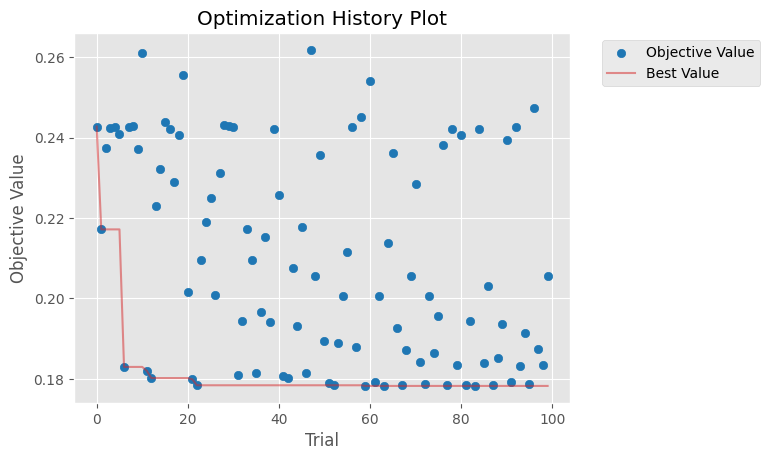

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

Se puede observar que ya para la corrida 20 el algoritmo encuentra valores objetivos bastante similares a los que se observan durante el resto de las corridas. Seguramente con menos iteraciones el algoritmo nos iba a encontrar un conjunto de valores para los hiperparametros que generen un modelo con un recall similar al obtenido.

In [ ]:
print('Variacion del umbral del modelo Optuna: \n')
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidad clase 1

# 2. Evaluar varios umbrales
umbrales = np.arange(0.1, 0.9, 0.05)
print("Umbral\tPrecision\tRecall\t\tF1")
for umbral in umbrales:
    y_pred_umb = (y_proba >= umbral).astype(int)
    p = precision_score(y_test, y_pred_umb)
    r = recall_score(y_test, y_pred_umb)
    f1 = f1_score(y_test, y_pred_umb)
    print(f"{umbral:.2f}\t{p:.4f}\t\t{r:.4f}\t\t{f1:.4f}")

Variacion del umbral del modelo Optuna: 

Umbral	Precision	Recall		F1
0.10	0.2212		1.0000		0.3623
0.15	0.2212		1.0000		0.3623
0.20	0.2213		1.0000		0.3624
0.25	0.2241		0.9997		0.3661
0.30	0.2347		0.9982		0.3800
0.35	0.2566		0.9884		0.4074
0.40	0.2929		0.9609		0.4490
0.45	0.3496		0.9066		0.5046
0.50	0.4288		0.8218		0.5635
0.55	0.5177		0.6994		0.5950
0.60	0.6146		0.5456		0.5781
0.65	0.7088		0.3847		0.4987
0.70	0.7892		0.2361		0.3634
0.75	0.8648		0.1292		0.2248
0.80	0.8992		0.0552		0.1041
0.85	0.9244		0.0179		0.0352


In [ ]:
print('Variacion del umbral del modelo original: \n')
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad clase 1

# 2. Evaluar varios umbrales
umbrales = np.arange(0.1, 0.9, 0.05)
print("Umbral\tPrecision\tRecall\t\tF1")
for umbral in umbrales:
    y_pred_umb = (y_proba >= umbral).astype(int)
    p = precision_score(y_test, y_pred_umb)
    r = recall_score(y_test, y_pred_umb)
    f1 = f1_score(y_test, y_pred_umb)
    print(f"{umbral:.2f}\t{p:.4f}\t\t{r:.4f}\t\t{f1:.4f}")

Variacion del umbral del modelo original: 

Umbral	Precision	Recall		F1
0.10	0.2774		0.9840		0.4329
0.15	0.3104		0.9622		0.4694
0.20	0.3436		0.9399		0.5032
0.25	0.3733		0.9143		0.5301
0.30	0.4053		0.8886		0.5566
0.35	0.4356		0.8583		0.5779
0.40	0.4662		0.8271		0.5963
0.45	0.4940		0.7884		0.6074
0.50	0.5248		0.7569		0.6198
0.55	0.5536		0.7110		0.6225
0.60	0.5856		0.6704		0.6251
0.65	0.6143		0.6196		0.6169
0.70	0.6488		0.5692		0.6064
0.75	0.6882		0.5121		0.5872
0.80	0.7266		0.4464		0.5530
0.85	0.7694		0.3729		0.5024


Es interesante visualizar lo siguiente:

Optuna:

|Umbral	|Recall		|F1    |
|-------|---------|------|
|0.40	  |0.9609		|0.4490|
|0.45	  |0.9066		|0.5046|
|***0.50***	  |***0.8218***		|***0.5635***|

Modelo original:

|Umbral		|Recall		|F1    |
|---------|---------|------|
|0.35			|0.8583		|0.5779|
|***0.40***			|***0.8271***		|***0.5963***|
|0.45			|0.7884		|0.6074|
|0.50			|0.7569		|0.6198|

Si intento mejorar el recall de mi modelo original disminuyendo el umbral a 0.4, obtengo practicamente el mismo recall que el modelo calculado por Optuna pero con un F1 mucho mejor.

## Explicabilidad del modelo

### Explainer

In [ ]:
# Modelo de regresión logística
model = LogisticRegression(random_state=42)

# Entrenamiento
model.fit(X_train_bal, y_train_bal)

# Obtener las probabilidades predichas
y_prob = model.predict_proba(X_test)[:, 1]

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [ ]:
# Crea un objeto explainer SHAP
explainer = shap.Explainer(model, X_train_bal, feature_names = X_train_bal.columns.values)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test)

In [ ]:
feature_names = X_train_bal.columns.values

### Interpretabilidad Local

#### Caso 1

In [ ]:
index = 0

In [ ]:
X_test.iloc[index]

,0
MinTemp_escalada,1.061217
MaxTemp_escalada,-0.389826
Rainfall_escalada,0.443437
WindGustSpeed_escalada,-0.21586
WindSpeed9am_escalada,0.104859
WindSpeed3pm_escalada,-0.4209
Humidity9am_escalada,1.063397
Humidity3pm_escalada,2.052824
Pressure9am_escalada,-0.453259
Pressure3pm_escalada,0.232194


In [ ]:
#y_prob
print('Probabilidad de que llueva: ',model.predict_proba(X_test)[index][1])

Probabilidad de que llueva:  0.8951254877467747


In [ ]:
model.predict(X_test)[index]

1

In [ ]:
feature_names = X_train_bal.columns.values

In [ ]:
explanation = shap.Explanation(
    values=shap_values[index],
    base_values = explainer.expected_value,
    feature_names = feature_names
)

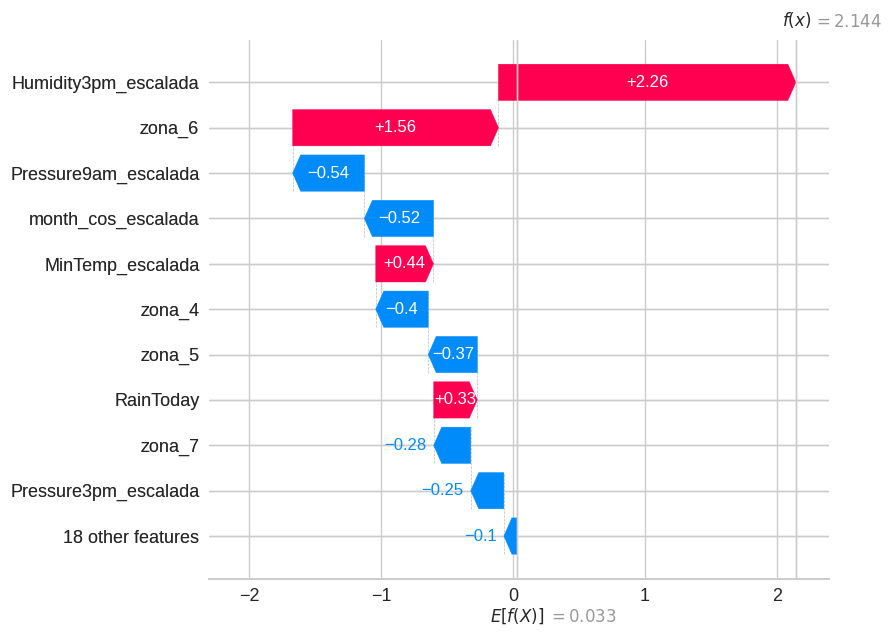

In [ ]:
shap.plots.waterfall(explanation, max_display=11)

La humedad a las 3pm, la pertenencia a la zona climatica 6, la temperatura minima y el hecho de que haya llovido el dia anterior son las variables que mas aumentan la probabilidad de que llueva al otro dia. Luego, la presion a las 9am, la componente coseno del escalado ciclico del mes, la no pertenencia a la zona 4,5 y 7 y la presion a las 3pm son las variables que mas disminuyen la probabilidad de que al otro dia llueva. Luego se observan otras 18 variables que, en su sumatoria, aportan a la disminucion de la probabilidad de que llueva. Finalmente, luego de sumar los valores SHAP a la probabilidad promedio de que llueva (E(f(x)) +  valores SHAP de todas las variables) se obtiene un valor f(x) = 2,144, que represnta una probabilidad de que llueva del 0.895

In [ ]:
Ex = explainer.expected_value
fx = shap_values[index].sum() + Ex  #Valores SHAP + E(f(x))
print('E(f(x)) = ', Ex)
print('f(x) = ',fx)

print('Probabilidad promedio de que llueva:', expit(Ex))
print("Probabilidad de que llueva: ",expit(fx))

E(f(x)) =  0.03279020150161882
f(x) =  2.144199404186739
Probabilidad promedio de que llueva: 0.5081968159556901
Probabilidad de que llueva:  0.8951254877467747


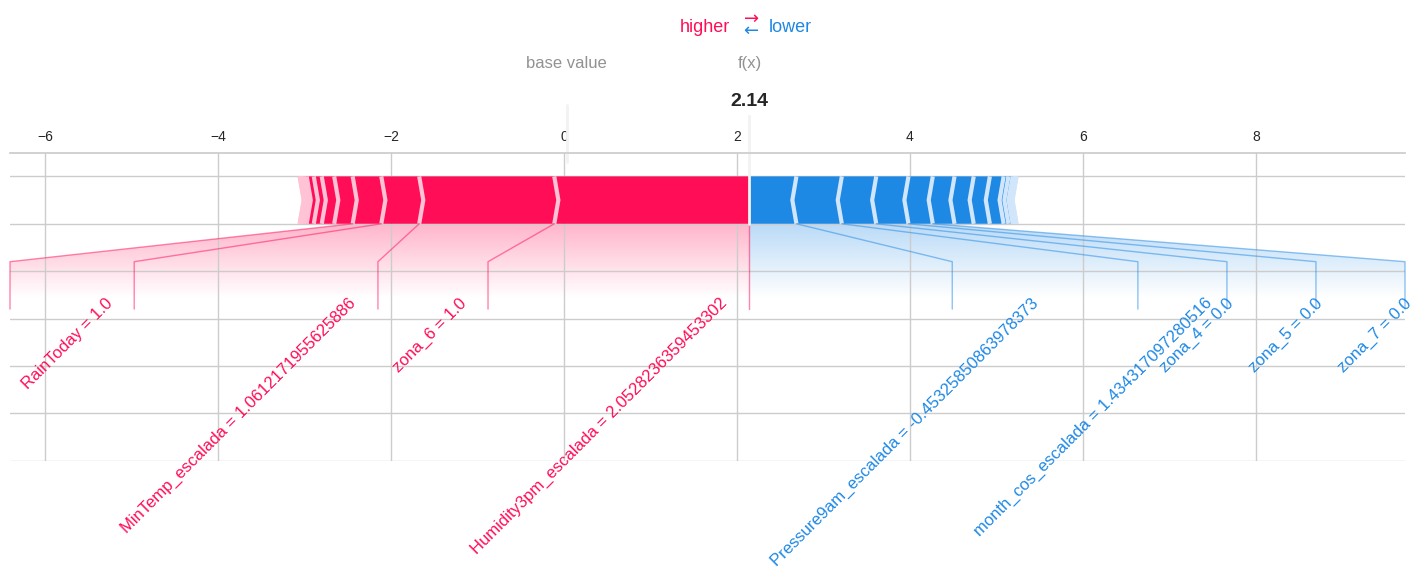

In [ ]:
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_test.iloc[index],
    feature_names = feature_names,
    matplotlib=True,
    figsize=(18, 4),
    text_rotation=45
)

#### Caso 2

In [ ]:
index = 10

In [ ]:
X_test.iloc[index]

,10
MinTemp_escalada,1.998761
MaxTemp_escalada,1.595897
Rainfall_escalada,-0.277055
WindGustSpeed_escalada,0.234089
WindSpeed9am_escalada,-0.120989
WindSpeed3pm_escalada,0.606753
Humidity9am_escalada,-0.038599
Humidity3pm_escalada,-0.211624
Pressure9am_escalada,-0.642294
Pressure3pm_escalada,-1.030901


In [ ]:
#y_prob
print('Probabilidad de que llueva: ',model.predict_proba(X_test)[index][1])

Probabilidad de que llueva:  0.42815654409910675


In [ ]:
feature_names = X_train_bal.columns.values

In [ ]:
explanation = shap.Explanation(
    values=shap_values[index],
    base_values = explainer.expected_value,
    feature_names = feature_names
)

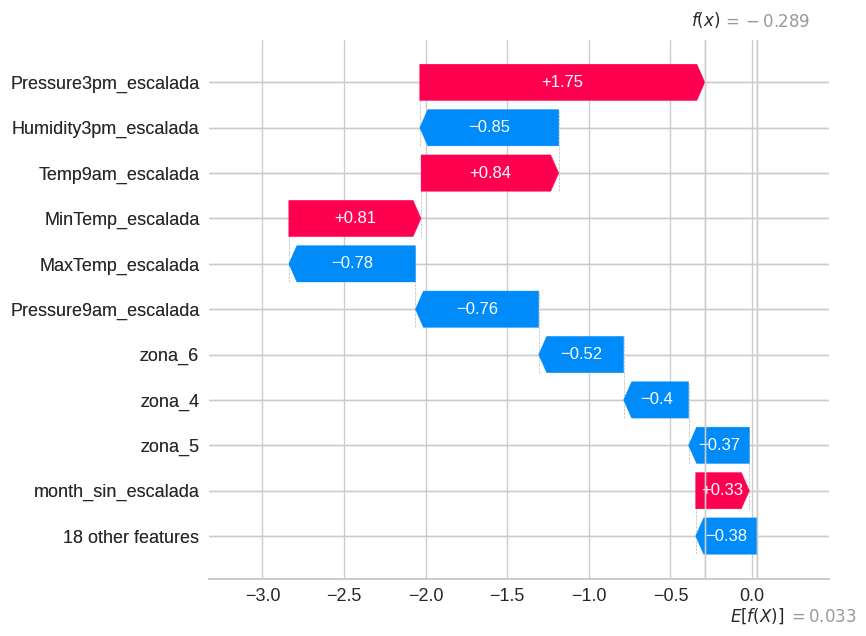

In [ ]:
shap.plots.waterfall(explanation, max_display=11)

In [ ]:
Ex = explainer.expected_value
fx = shap_values[index].sum() + Ex  #Valores SHAP + E(f(x))
print('E(f(x)) = ', Ex)
print('f(x) = ',fx)

print('Probabilidad promedio de que llueva:', expit(Ex))
print("Probabilidad de que llueva: ",expit(fx))


E(f(x)) =  0.03279020150161882
f(x) =  -0.2893763894782375
Probabilidad promedio de que llueva: 0.5081968159556901
Probabilidad de que llueva:  0.4281565440991064


La presion a las 3pm, la temperatura a las 9am, la temperatura minima del dia y la componente seno de la codificacion ciclica de la variable correspondiente al mes son las variables que mas aumentan la probabilidad de que llueva. Luego la humedad a las 3pm, la temperatura maxima del dia, la presion a las 9AM y la no pertenencia a las zonas climaticas 4,5 y 6 son las variables que mas disminuyen la probabilidad de que llueva. Luego se observan otras 18 variables que, en su sumatoria, aportan a la disminucion de la probabilidad de que llueva. Finalmente, luego de sumar los valores SHAP a la probabilidad promedio de que llueva (E(f(x)) +  valores SHAP de todas las variables) se obtiene un valor f(x) = -0.289, que represnta una probabilidad de que llueva del 0,428

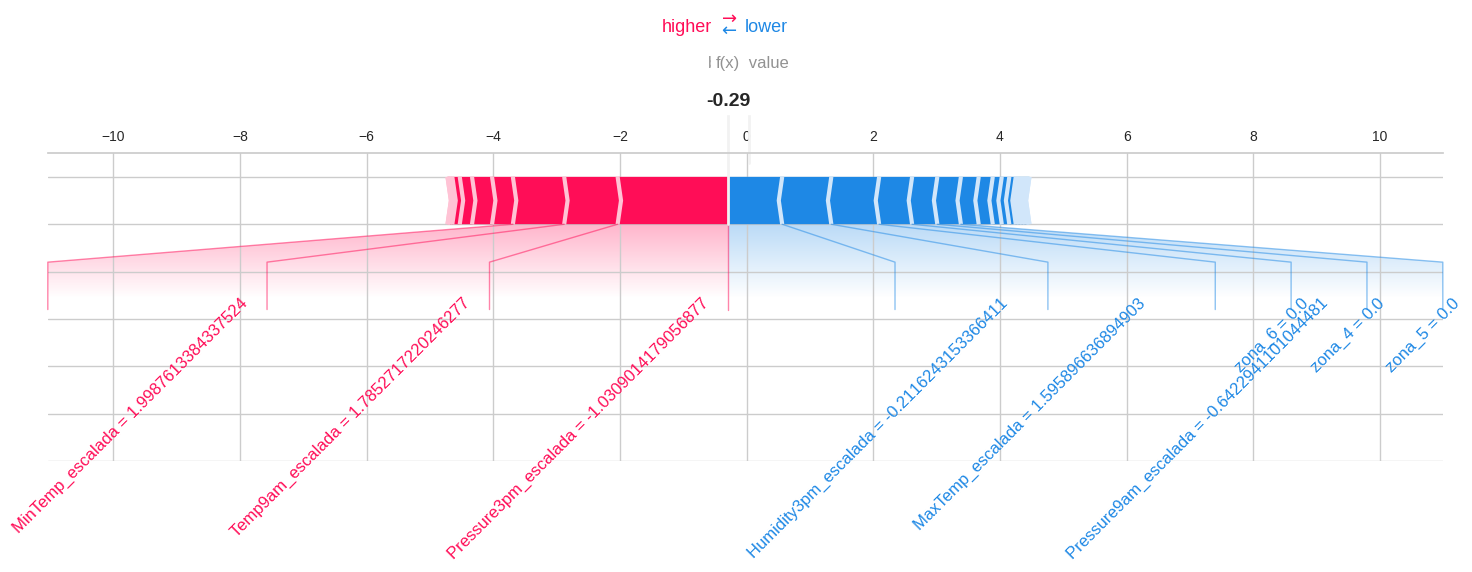

In [ ]:
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_test.iloc[index],
    feature_names = feature_names,
    matplotlib=True,
    figsize=(18, 4),
    text_rotation=45
)

### Interpretabilidad Global

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)

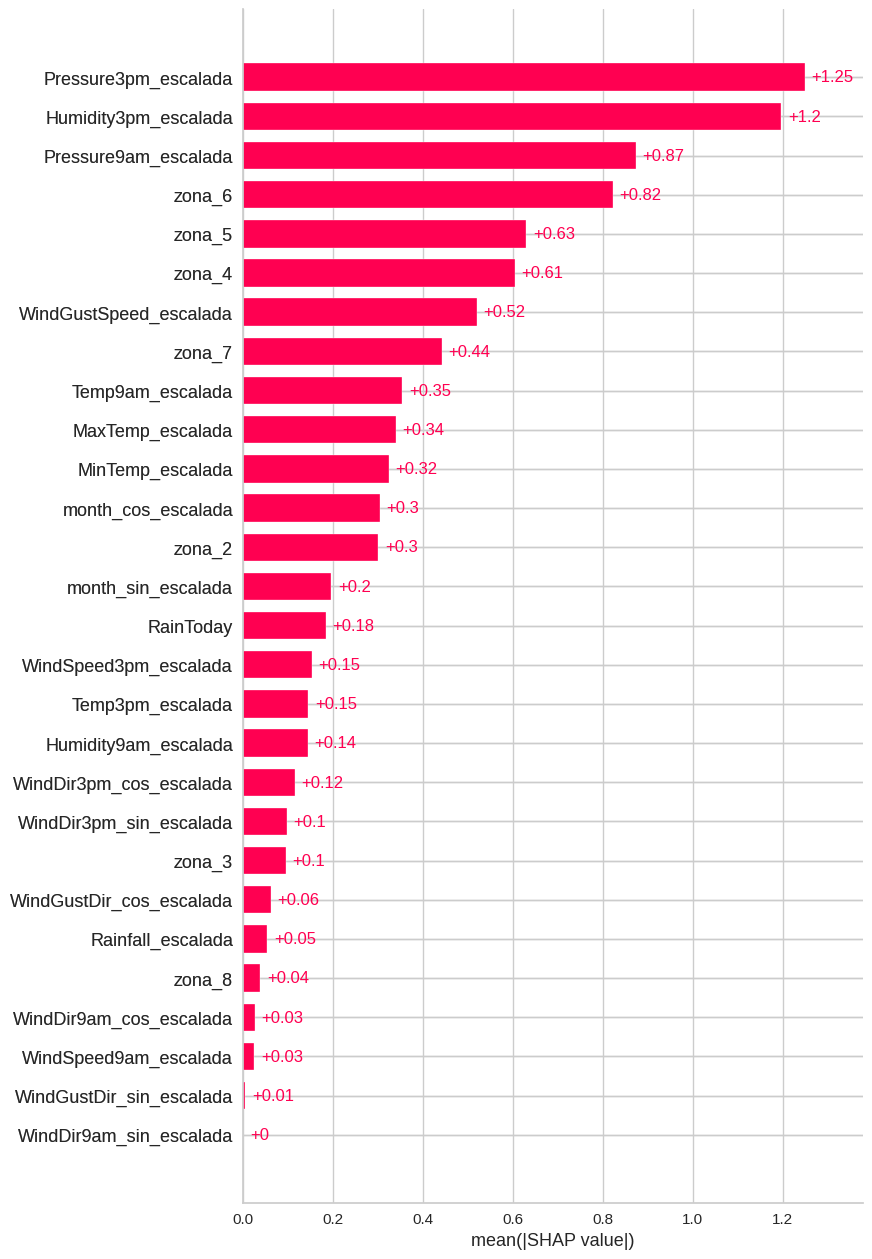

In [ ]:
shap.plots.bar(explanation, max_display=30)

En el gráfico se muestra la importancia global de cada variable en el modelo para predecir si mañana va a llover. Esta importancia se mide con el valor medio absoluto de los SHAP values para cada variable, lo que refleja cuánto contribuye cada variable a las predicciones, en promedio.

La presion a las 3pm y la humedad a las 3pm son las variables más influyentes, con una contribución promedio significativamente mayor al resto, indicando que la presión y la humedad por la tarde son señales clave para el modelo.

También tienen alta relevancia para anticipar la lluvia otras variables como la presion a las 9am y velocidad de las rafagas de viento.

Las variables de zona geográfica (zona_6, zona_5, zona_4, etc.) también presentan un peso no menor, lo que indica que la ubicación tiene un impacto notable en el comportamiento de la lluvia.

En el extremo opuesto, variables como la direccion del viento a las 9am y la velocidad del viento a las 9am tienen una influencia media prácticamente nula, lo que sugiere que no aportan valor predictivo significativo en este modelo.

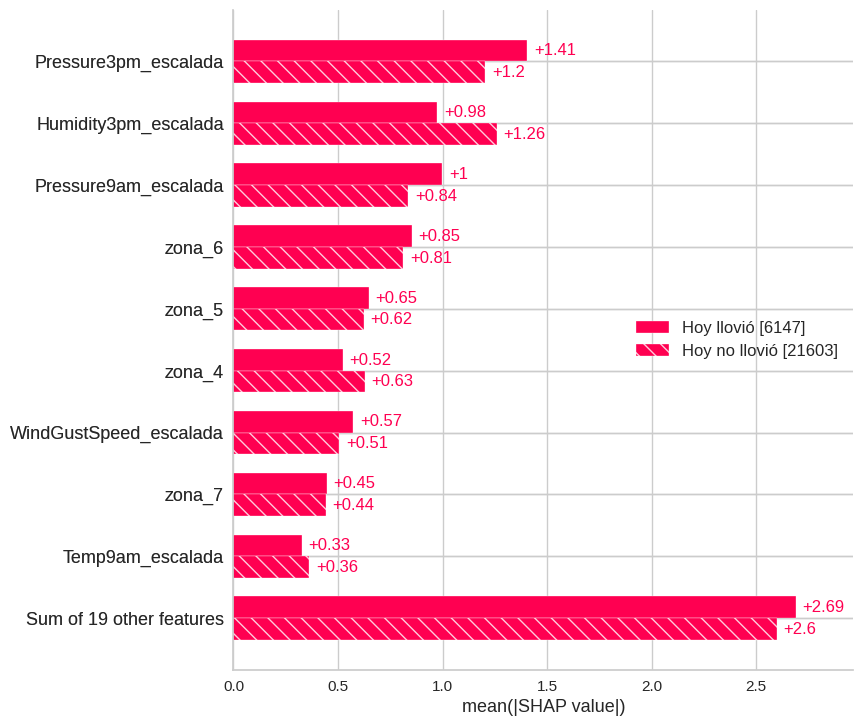

In [ ]:
aux = [
    "Hoy llovió" if explanation.data['RainToday'].iloc[i] == 1 else "Hoy no llovió"
    for i in range(explanation.shape[0])
]
shap.plots.bar(explanation.cohorts(aux).abs.mean(0))

El gráfico compara la importancia promedio absoluta de cada variable en la predicción de si mañana lloverá, diferenciando entre casos donde hoy llovió y hoy no llovió.

La presion a las 3pm tiene más peso en días donde llovió hoy (+1.41 vs +1.20), lo que indica que en esos casos el modelo le da más importancia a la presión de la tarde actual para predecir la lluvia del día siguiente.

En cambio, la humedad a las 3pm tiene ligeramente más influencia cuando no llovió hoy (+1.26 vs +0.98), lo que sugiere que en días secos, la humedad de la tarde se vuelve una señal más relevante para anticipar si mañana lloverá o no.

## Modelo de AutoML

In [ ]:
df_train_bal = pd.concat([X_train_bal, y_train_bal], axis=1)

In [ ]:
# inicializamos el entorno de PyCaret para un problema de regresión
reg = setup(data=df_train_bal, target='RainTomorrow')

,Description,Value
0,Session id,2984
1,Target,RainTomorrow
2,Target type,Regression
3,Original data shape,"(172450, 29)"
4,Transformed data shape,"(172450, 29)"
5,Transformed train set shape,"(120714, 29)"
6,Transformed test set shape,"(51736, 29)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [ ]:
#Entrenar modelos, compararlos y obtener el mejor
best_model = compare_models() #Demora una hora en correr
print(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1800,0.0704,0.2653,0.7184,0.1908,0.1638,70.6940
rf,Random Forest Regressor,0.1918,0.0788,0.2807,0.6848,0.1992,0.1864,191.4030
xgboost,Extreme Gradient Boosting,0.1925,0.0796,0.2821,0.6816,0.1955,0.2167,2.0560
lightgbm,Light Gradient Boosting Machine,0.1933,0.0799,0.2827,0.6802,0.1974,0.2126,6.2410
knn,K Neighbors Regressor,0.1797,0.1048,0.3237,0.5809,0.2330,0.1095,14.9480
gbr,Gradient Boosting Regressor,0.2543,0.1079,0.3284,0.5685,0.2318,0.2582,55.1720
lr,Linear Regression,0.3254,0.1510,0.3886,0.3960,0.2714,0.3365,1.5300
ridge,Ridge Regression,0.3254,0.1510,0.3886,0.3960,0.2714,0.3364,0.2270
br,Bayesian Ridge,0.3254,0.1510,0.3886,0.3960,0.2714,0.3364,0.2320
huber,Huber Regressor,0.3183,0.1528,0.3908,0.3889,0.2706,0.3395,3.0220


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=2984)


In [ ]:
# hacer predicciones sobre los datos de prueba
predictions = predict_model(best_model, data=X_test)
predictions

,MinTemp_escalada,MaxTemp_escalada,Rainfall_escalada,WindGustSpeed_escalada,WindSpeed9am_escalada,WindSpeed3pm_escalada,Humidity9am_escalada,Humidity3pm_escalada,Pressure9am_escalada,Pressure3pm_escalada,...,WindDir3pm_cos_escalada,zona_2,zona_3,zona_4,zona_5,zona_6,zona_7,zona_8,RainToday,prediction_label
0,1.061217,-0.389826,0.443437,-0.215860,0.104859,-0.420900,1.063397,2.052824,-0.453259,0.232194,...,-1.359956,False,False,False,False,True,False,False,1.0,0.96
1,0.545568,0.300248,-0.277055,0.459064,0.330708,0.606753,-0.143551,-0.163445,0.186554,0.276255,...,-0.942087,False,False,False,False,True,False,False,0.0,0.09
2,-1.407649,-1.713640,-0.277055,2.408844,4.057214,2.547877,1.325777,1.426487,1.073568,0.643434,...,1.493462,False,False,False,False,False,True,False,0.0,0.67
3,0.936211,0.455163,0.155240,-0.365843,-1.589007,-1.334370,0.643589,0.751971,-0.482341,-0.516851,...,-0.942087,False,False,False,True,False,False,False,1.0,0.32
4,0.795580,1.539564,-0.277055,-0.740801,-0.572687,-0.649268,-1.927735,-1.319758,-0.642294,-0.884030,...,0.066753,False,False,False,True,False,False,False,0.0,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27745,1.170597,0.553745,-0.277055,0.609047,1.121179,0.835121,-0.773263,-0.018905,-0.976742,-0.942779,...,-0.942087,False,False,False,True,False,False,False,0.0,0.16
27746,-0.610737,-1.600975,0.251305,0.909013,-0.572687,0.035835,1.063397,1.281948,-1.631096,-1.486203,...,0.612726,False,False,True,False,False,False,False,1.0,0.89
27747,-0.516982,0.441079,-0.277055,-0.740801,-1.589007,-0.877635,0.171305,-0.934320,0.099307,0.144071,...,-0.479220,False,False,True,False,False,False,False,0.0,0.00
27748,1.186223,0.694576,-0.253039,0.309081,-0.346838,0.035835,0.276257,0.703791,-0.424176,-0.443415,...,1.075593,True,False,False,False,False,False,False,0.0,0.58


In [ ]:
y_pred = predictions['prediction_label']>0.5

# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.8498
Precision: 0.6665
Recall: 0.6424
F1-Score: 0.6542


Si tomamos el recall como metrica para comprar los modelos, el modelo generado por PyCaret tiene un peor recall (0.64) que el modelo de regresion logistica generado previamente (0.756).